In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna

In [42]:
DATA_PATH = './Data/'

TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_DATA_PATH = DATA_PATH + 'test.csv'
SUBMISSION_DATA_PATH = DATA_PATH + 'sample_submission.csv'

In [43]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
submission_df = pd.read_csv(SUBMISSION_DATA_PATH)

train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [45]:
def show_graph(col):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=train_df[f'{col}'].value_counts().index, 
                y=train_df[f'{col}'].value_counts().values, 
                palette='Set3', 
                ax=ax)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


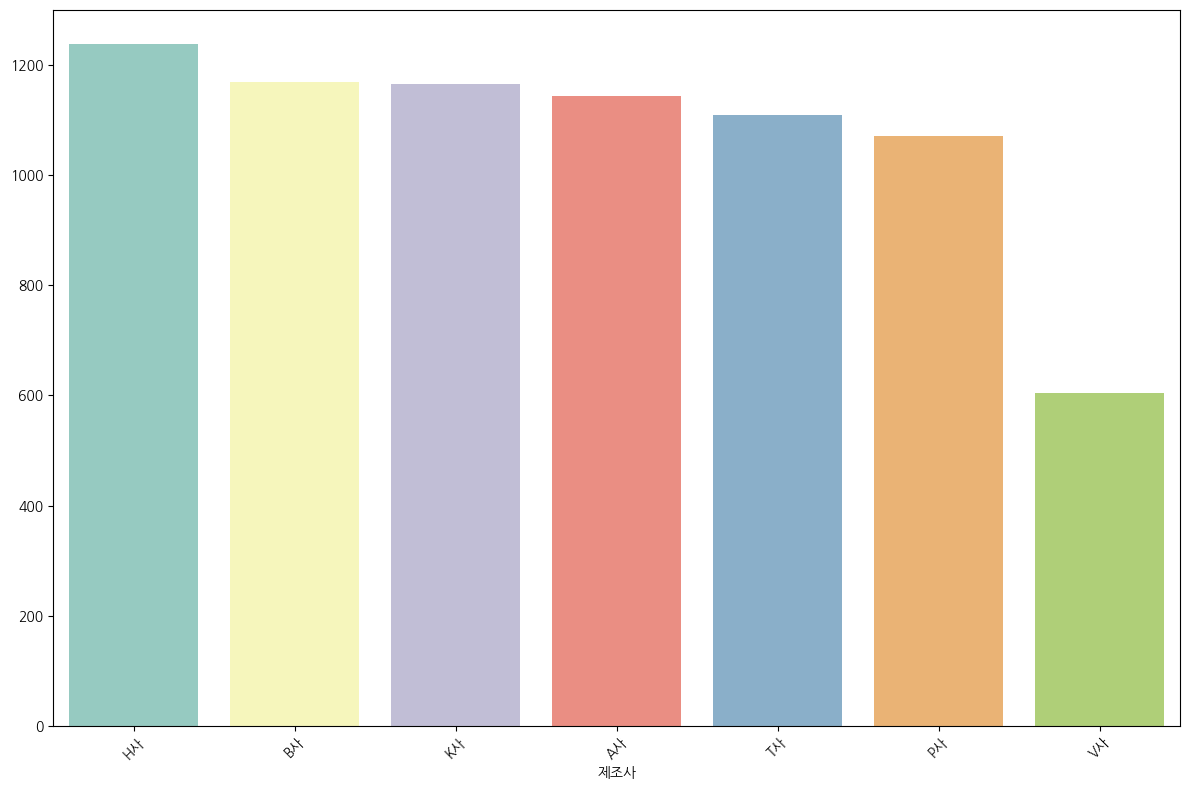

In [46]:
show_graph('제조사')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


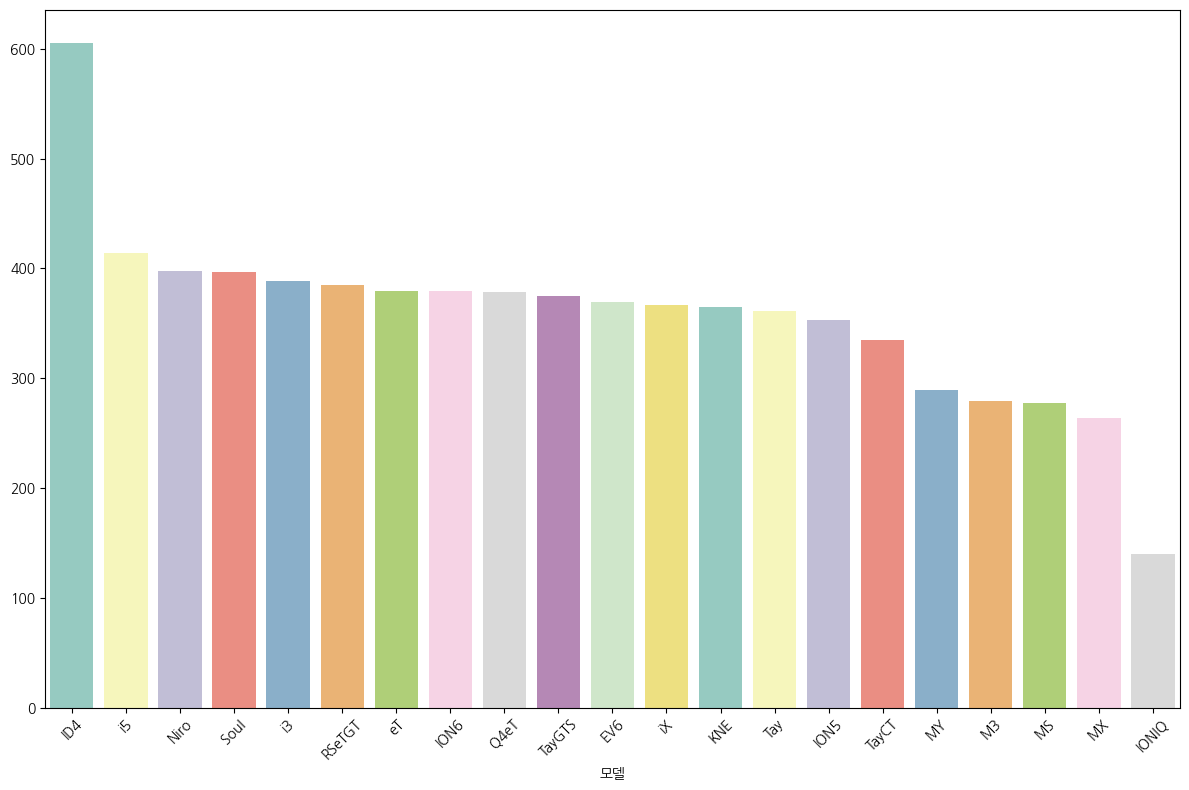

In [47]:
show_graph('모델')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


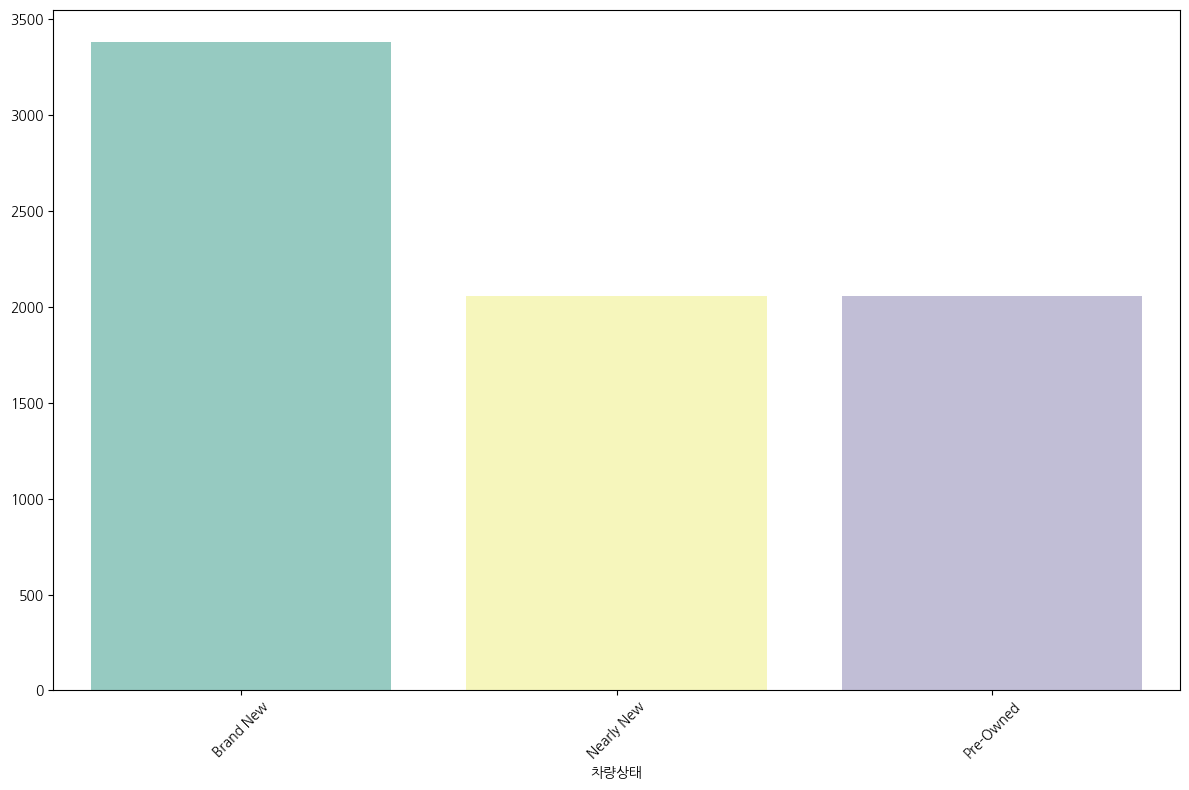

In [48]:
show_graph('차량상태')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


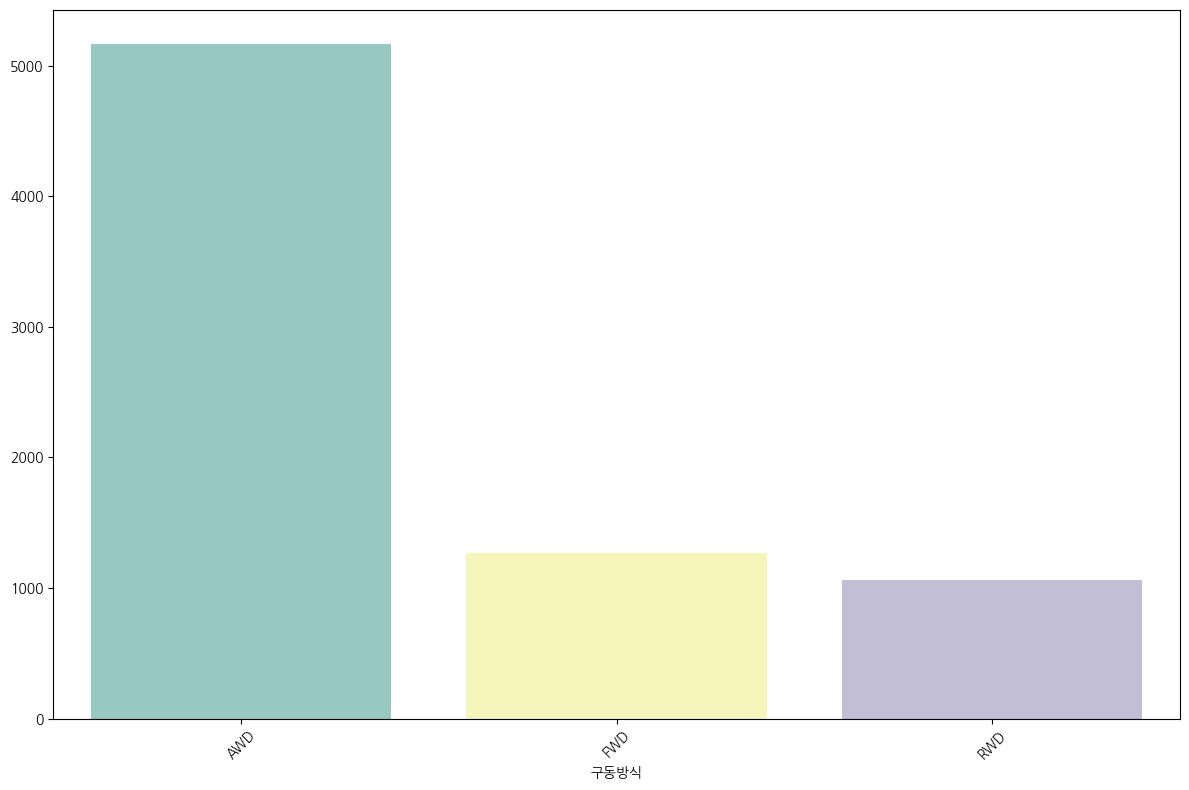

In [49]:
show_graph('구동방식')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


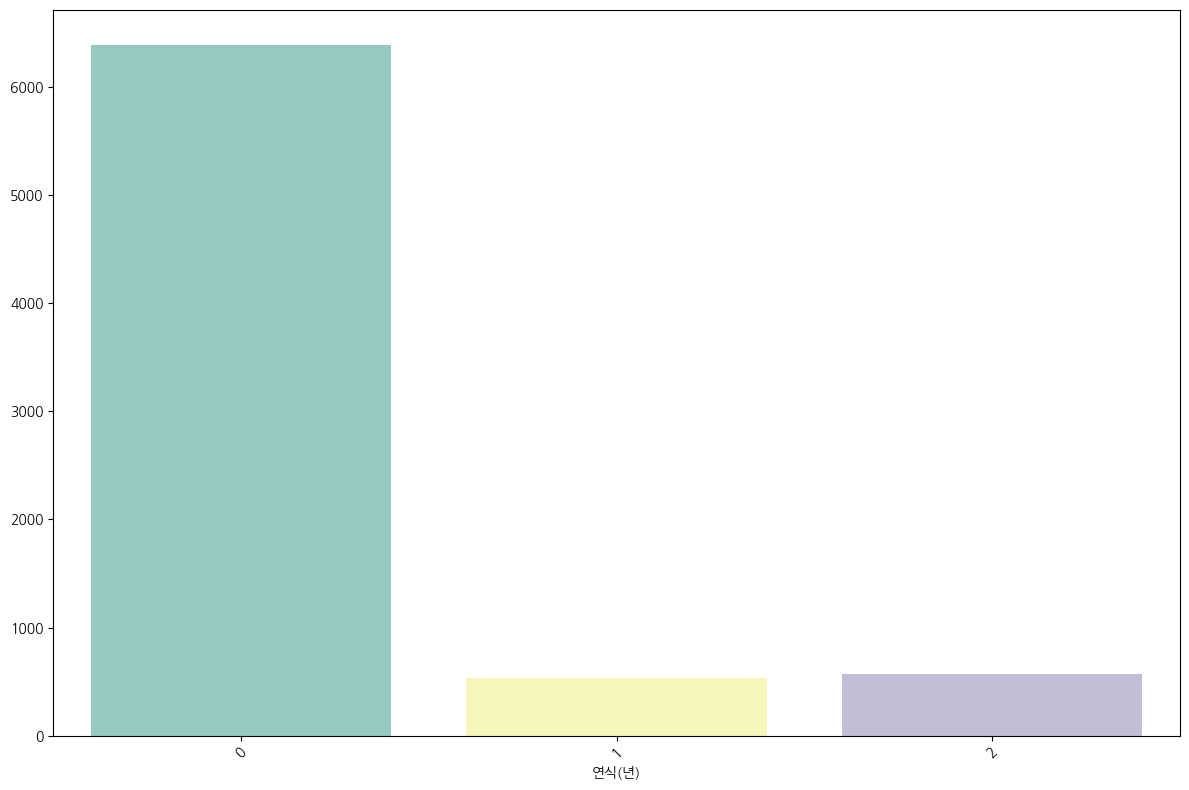

In [50]:
show_graph('연식(년)')

In [51]:
def print_mean_battery(col):
    for i in train_df[col].unique():
        print(f"{col} - {i} : {train_df[train_df[col] == i]['배터리용량'].mean()}")

In [52]:
print_mean_battery('연식(년)')

연식(년) - 2 : 69.538296
연식(년) - 0 : 69.68484126984127
연식(년) - 1 : 66.74253498871332


In [53]:
print_mean_battery('모델')

모델 - TayGTS : 80.45416988416989
모델 - Niro : 54.578933333333325
모델 - eT : 83.77656402439024
모델 - RSeTGT : 84.39925242718446
모델 - i5 : 65.49336119402984
모델 - ION6 : 65.87692340425532
모델 - MS : 89.67221266968326
모델 - MY : 63.91637988826815
모델 - Q4eT : 69.0407149122807
모델 - ID4 : 65.42444
모델 - TayCT : 77.5639326923077
모델 - Soul : 53.71446036585366
모델 - iX : 90.0
모델 - MX : 90.03115121951218
모델 - IONIQ : 62.04435185185184
모델 - EV6 : 90.0
모델 - KNE : 72.11759670781893
모델 - M3 : 64.48288165680474
모델 - i3 : 52.691131498470945
모델 - ION5 : 66.43954545454545
모델 - Tay : 67.16731555555556


In [54]:
print_mean_battery('보증기간(년)')

보증기간(년) - 0 : 59.936046931407944
보증기간(년) - 6 : 68.75179527559055
보증기간(년) - 7 : 83.86369625246549
보증기간(년) - 3 : 61.30074884792627
보증기간(년) - 1 : 59.83024901185771
보증기간(년) - 5 : 64.60444846796658
보증기간(년) - 8 : 84.68549800796812
보증기간(년) - 10 : 90.0
보증기간(년) - 2 : 68.24809410548086
보증기간(년) - 4 : 61.65939722222222
보증기간(년) - 9 : 90.0


In [55]:
print_mean_battery('차량상태')

차량상태 - Nearly New : 66.67888807649044
차량상태 - Brand New : 92.5865671641791
차량상태 - Pre-Owned : 59.053240185950415


In [56]:
print_mean_battery('제조사')

제조사 - P사 : 75.26528034682082
제조사 - K사 : 57.49066711590296
제조사 - A사 : 78.77559787556905
제조사 - B사 : 62.34454742547425
제조사 - H사 : 67.39844044665013
제조사 - T사 : 78.31083204134367
제조사 - V사 : 65.42444


In [57]:
train_df.groupby('연식(년)')['배터리용량'].mean()

연식(년)
0    69.684841
1    66.742535
2    69.538296
Name: 배터리용량, dtype: float64

In [58]:
def draw_mean_battery(col):
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.barplot(x = sorted(train_df[col].unique()),
                y = train_df.groupby(col)['배터리용량'].mean(),
                palette = 'tab20c',
                ax = ax)
    plt.xticks(rotation = 45, size = 20)
    plt.yticks(size = 15)
    plt.title(f'{col} - 평균 배터리', size = 20)
    ax.set_ylabel('배터리 용량 (평균)', fontsize = 20)
    plt.tight_layout()
    plt.show()

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


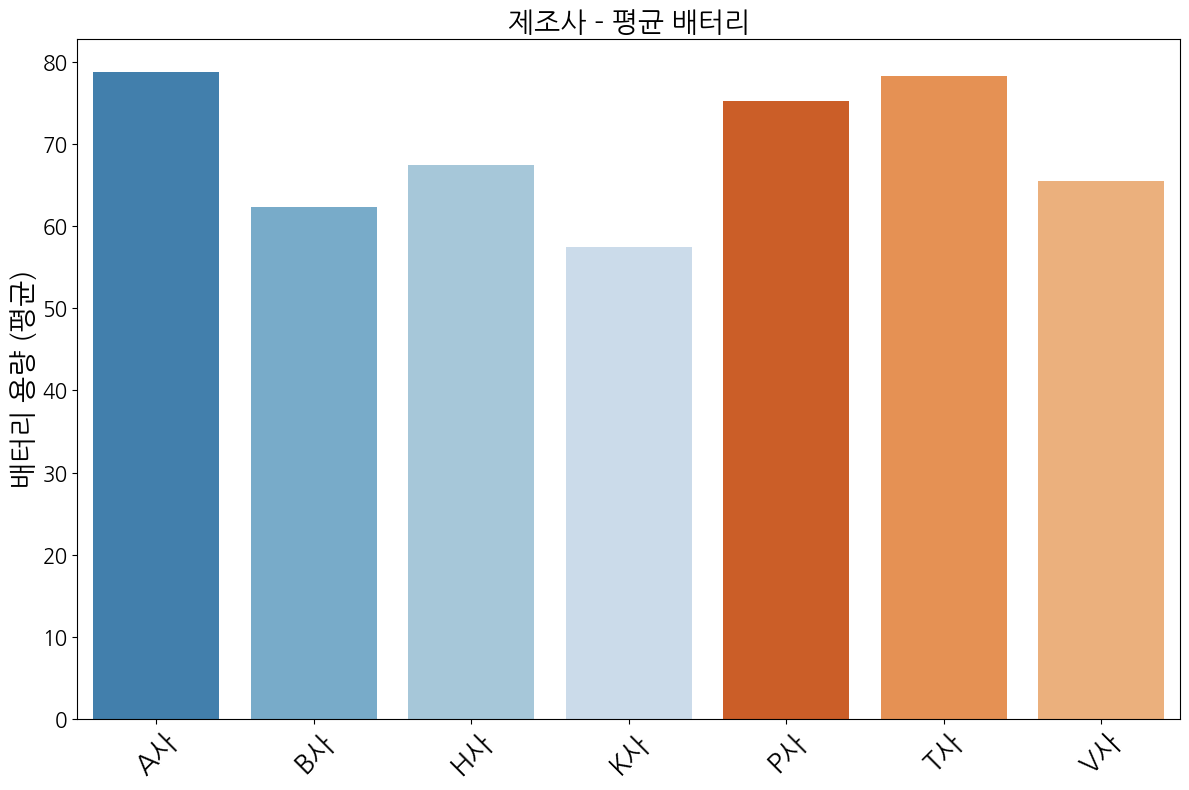

In [59]:
draw_mean_battery('제조사')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


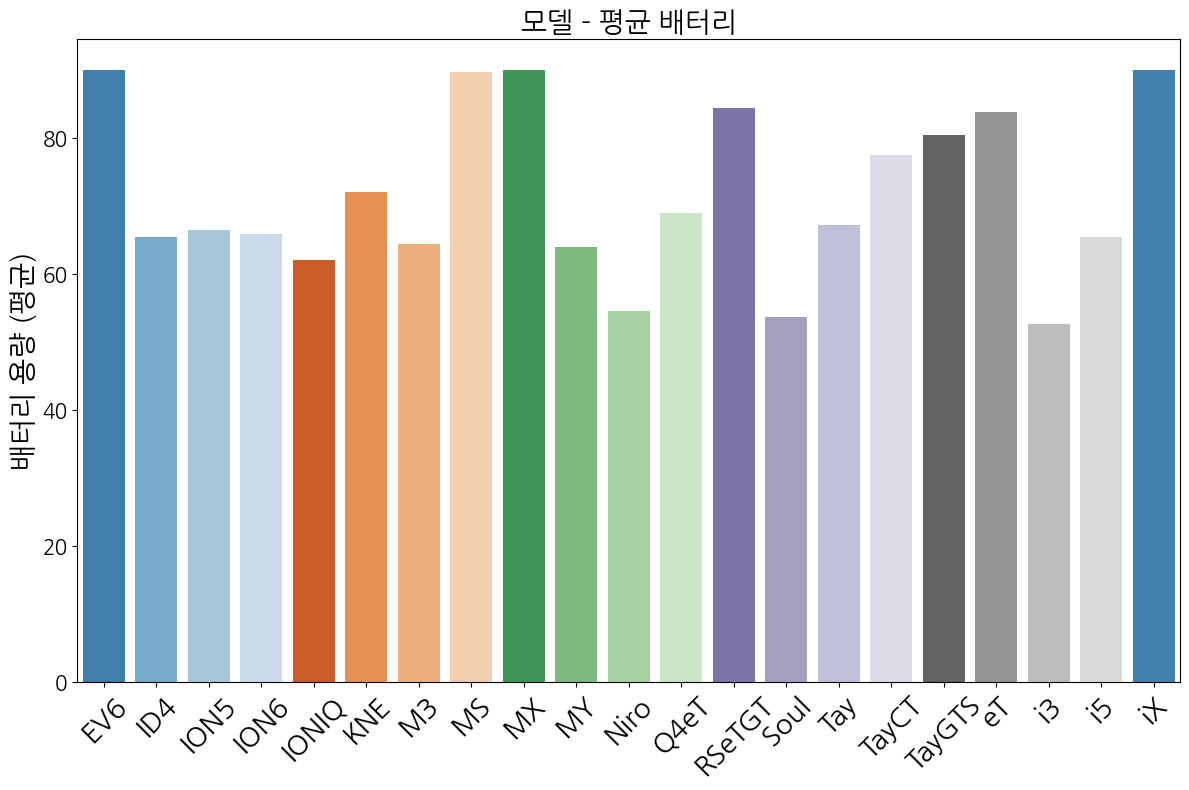

In [60]:
draw_mean_battery('모델')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


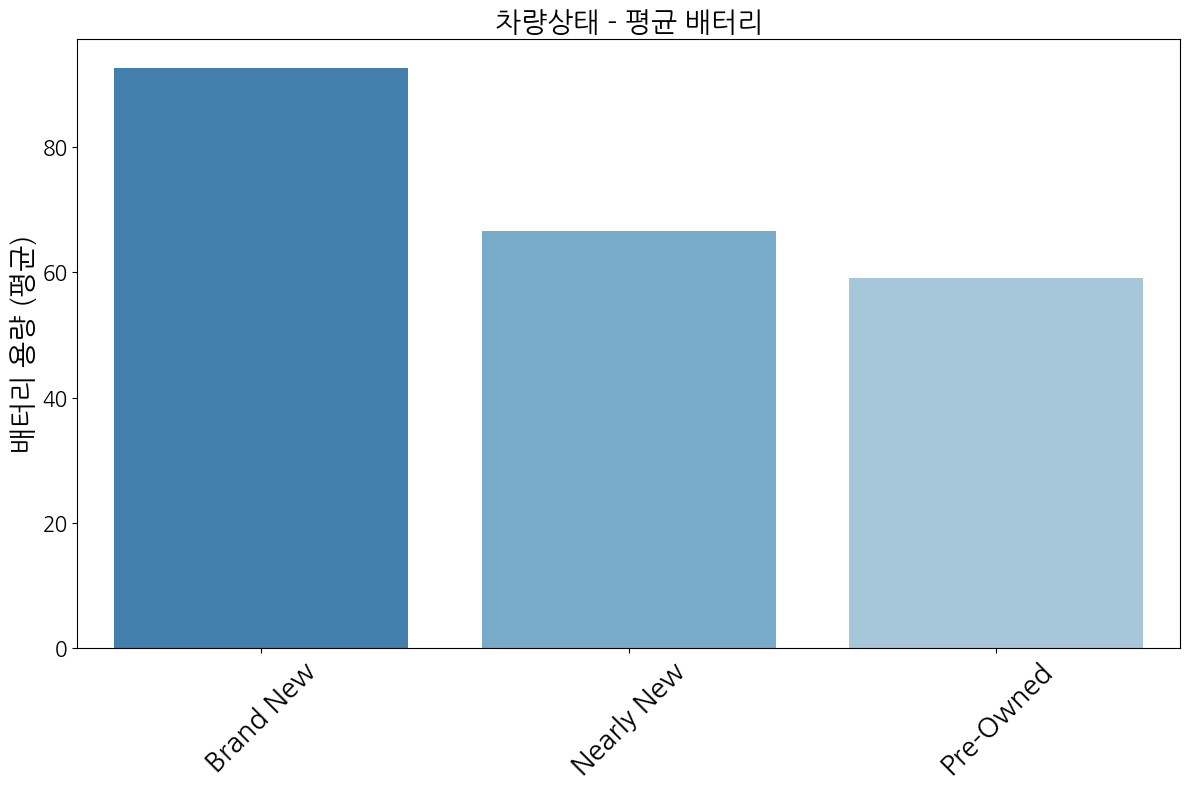

In [61]:
draw_mean_battery('차량상태')

C:\Users\이민하\AppData\Local\Temp\ipykernel_19744\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


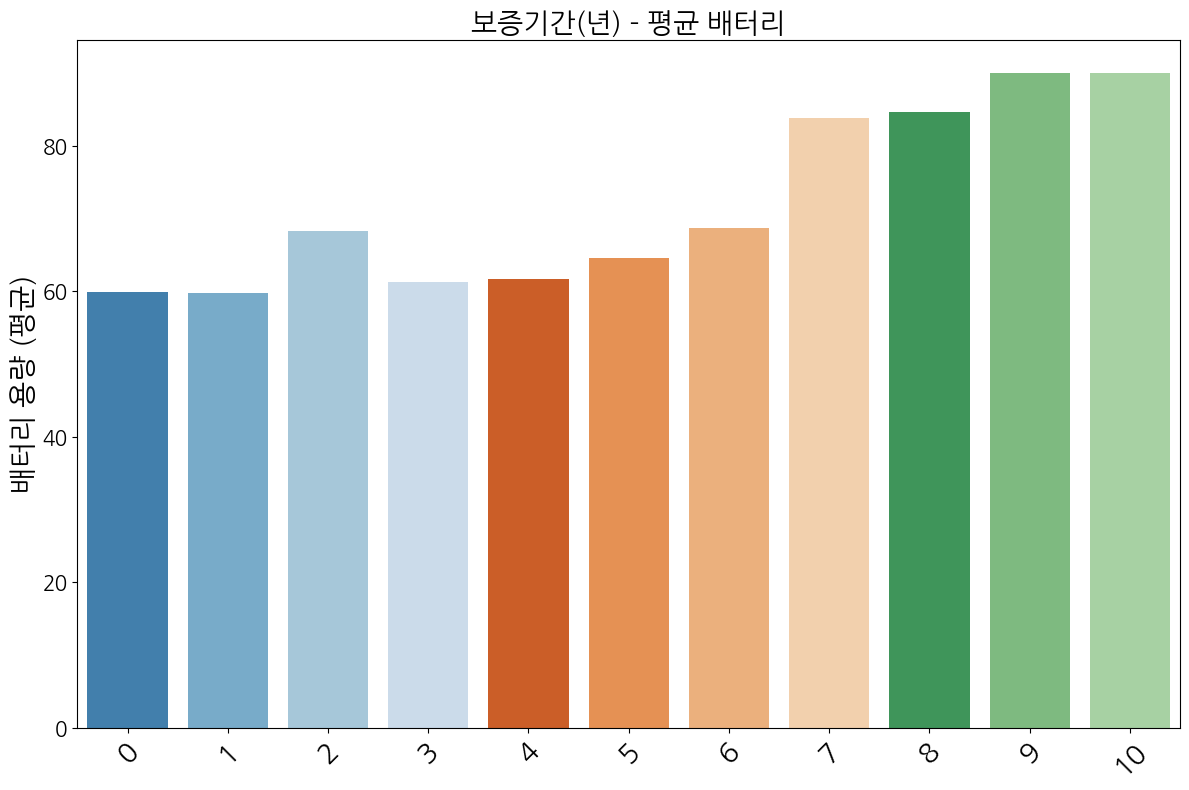

In [62]:
draw_mean_battery('보증기간(년)')

In [63]:
train_df.corr(numeric_only = True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


모델, 보증기간 7년 이상, 차량 상태가 배터리 용량을 결정

In [64]:
train_df[train_df['배터리용량'].isna()]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
6,TRAIN_0006,T사,MS,Nearly New,NaN,AWD,19395,3,No,0,83.42
8,TRAIN_0008,T사,MY,Brand New,NaN,AWD,2226,8,No,0,74.06
9,TRAIN_0009,A사,Q4eT,Brand New,NaN,AWD,3683,7,No,0,59.66
11,TRAIN_0011,V사,ID4,Brand New,NaN,AWD,1131,8,No,0,40.50
...,...,...,...,...,...,...,...,...,...,...,...
7489,TRAIN_7489,H사,ION5,Brand New,NaN,AWD,8871,9,No,0,35.83
7490,TRAIN_7490,A사,Q4eT,Brand New,NaN,AWD,5794,7,No,0,59.95
7491,TRAIN_7491,K사,Soul,Brand New,NaN,FWD,5966,10,No,0,16.75
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95


In [65]:
train_df['보증기간'] = train_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')
test_df['보증기간'] = test_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')

In [66]:
def fill_battery(cond_df, df):
    for i in range(len(cond_df)):
        model = cond_df.iloc[i]['모델']
        status = cond_df.iloc[i]['차량상태']
        warranty = cond_df.iloc[i]['보증기간']
        
        cond = (train_df['모델'] == model) & (train_df['차량상태'] == status) & (train_df['보증기간'] == warranty)       
        df.loc[cond_df.iloc[i].name, '배터리용량'] = train_df[cond]['배터리용량'].mean()

In [67]:
fill_battery(train_df[train_df['배터리용량'].isna()], train_df)
fill_battery(test_df[test_df['배터리용량'].isna()], test_df)

In [68]:
train_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),보증기간
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,low
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,low
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,high
3,TRAIN_0003,A사,RSeTGT,Nearly New,78.227,AWD,21683,3,No,0,99.16,low
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,low
...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,90.000,AWD,3773,10,No,0,35.95,high
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,low
7494,TRAIN_7494,P사,TayCT,Brand New,90.000,AWD,1363,2,No,0,120.00,low
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,low


In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
 11  보증기간      7497 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 703.0+ KB


In [70]:
test_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),보증기간
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0,low
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0,high
2,TEST_002,B사,i5,Brand New,90.000,RWD,7197,7,Yes,0,high
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1,high
4,TEST_004,K사,EV6,Brand New,90.000,FWD,7597,10,No,0,high
...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0,low
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0,low
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0,low
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0,low


In [71]:
encoder = LabelEncoder()

object_list = ['제조사', '모델', '차량상태', '구동방식', '보증기간', '사고이력']

for col in object_list:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.fit_transform(test_df[col])

In [72]:
train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),보증기간
0,TRAIN_0000,4,16,1,86.077,0,13642,0,0,2,159.66,1
1,TRAIN_0001,3,10,1,56.000,1,10199,6,0,0,28.01,1
2,TRAIN_0002,0,17,0,91.200,0,2361,7,0,0,66.27,0
3,TRAIN_0003,0,12,1,78.227,0,21683,3,0,0,99.16,1
4,TRAIN_0004,1,19,2,61.018,0,178205,1,0,0,62.02,1


In [73]:
test_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),보증기간
0,TEST_000,4,15,1,76.093,0,14057,2,0,0,1
1,TEST_001,1,20,0,90.000,0,7547,8,0,0,0
2,TEST_002,1,19,0,90.000,2,7197,7,1,0,0
3,TEST_003,2,2,1,68.479,0,10357,7,0,1,0
4,TEST_004,3,0,0,90.000,1,7597,10,0,0,0


In [74]:
train_df.drop('ID', axis = 1, inplace = True)
test_df.drop('ID', axis = 1, inplace = True)

In [75]:
target = train_df['가격(백만원)']
feature = train_df.drop('가격(백만원)', axis = 1)

In [76]:
# X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 42)

In [77]:
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 5, 256),  # 리프 노드 수
        'max_depth': trial.suggest_int('max_depth', 3, 21),  # 트리 깊이
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log = True),  # 학습률
        'n_estimators': trial.suggest_int('n_estimators', 10, 5000),  # 트리 개수
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 데이터 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []

    for train_idx, val_idx in kf.split(feature):
        X_train, X_val = feature.iloc[train_idx], feature.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        # 모델 학습
        model = lgb.LGBMRegressor(random_state = 42, n_jobs = -1, **param)
        model.fit(X_train, y_train)

        # 검증 데이터 예측 및 RMSE 계산
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds) ** 0.5
        rmse_list.append(rmse)

    # 평균 RMSE 반환 (Optuna가 이 값을 최소화하도록 튜닝)
    return np.mean(rmse_list)

In [78]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 500, show_progress_bar = True, n_jobs = -1)

print("Best hyperparameters:", study.best_params)

# 최적 하이퍼파라미터로 전체 X_train 학습 후 X_test 평가
best_param = study.best_params

final_model = lgb.LGBMRegressor(random_state = 42, n_jobs = -1, **best_param)
final_model.fit(feature, target)

y_pred = final_model.predict(test_df)


[I 2025-01-14 19:22:17,428] A new study created in memory with name: no-name-501314f2-a6c7-48ce-bfa1-44adb4413b45
Best trial: 0. Best value: 6.56996:   0%|          | 1/500 [00:57<8:01:43, 57.92s/it]

[I 2025-01-14 19:23:15,347] Trial 0 finished with value: 6.569960673149474 and parameters: {'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.0026261342156428686, 'n_estimators': 1877, 'subsample': 0.6438763344201579, 'colsample_bytree': 0.5018147942914422}. Best is trial 0 with value: 6.569960673149474.


Best trial: 0. Best value: 6.56996:   0%|          | 2/500 [01:04<3:51:50, 27.93s/it]

[I 2025-01-14 19:23:22,287] Trial 7 finished with value: 30.508267318983986 and parameters: {'num_leaves': 108, 'max_depth': 3, 'learning_rate': 0.00011785914006017195, 'n_estimators': 2022, 'subsample': 0.6091273173332625, 'colsample_bytree': 0.5187932620213409}. Best is trial 0 with value: 6.569960673149474.


Best trial: 9. Best value: 1.41494:   1%|          | 3/500 [02:12<6:19:42, 45.84s/it]

[I 2025-01-14 19:24:29,432] Trial 9 finished with value: 1.4149415393509799 and parameters: {'num_leaves': 103, 'max_depth': 11, 'learning_rate': 0.06465341504722763, 'n_estimators': 203, 'subsample': 0.6624730223848778, 'colsample_bytree': 0.650770703489881}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   1%|          | 4/500 [05:23<14:12:52, 103.17s/it]

[I 2025-01-14 19:27:40,489] Trial 5 finished with value: 1.4618854441182445 and parameters: {'num_leaves': 175, 'max_depth': 13, 'learning_rate': 0.04457516332870817, 'n_estimators': 977, 'subsample': 0.7419231488998332, 'colsample_bytree': 0.8106428798409365}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   1%|          | 5/500 [05:31<9:29:40, 69.05s/it]  

[I 2025-01-14 19:27:49,045] Trial 6 finished with value: 4.7595553147990985 and parameters: {'num_leaves': 21, 'max_depth': 7, 'learning_rate': 0.0006385854147815768, 'n_estimators': 3483, 'subsample': 0.7827087192937565, 'colsample_bytree': 0.9206291997689167}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   1%|          | 6/500 [09:58<18:43:36, 136.47s/it]

[I 2025-01-14 19:32:16,389] Trial 10 finished with value: 22.817891274832913 and parameters: {'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.00022488025874955211, 'n_estimators': 2183, 'subsample': 0.7427711924749045, 'colsample_bytree': 0.7028692683635833}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   1%|▏         | 7/500 [11:56<17:50:22, 130.27s/it]

[I 2025-01-14 19:34:13,902] Trial 13 finished with value: 1.4894371777755762 and parameters: {'num_leaves': 62, 'max_depth': 13, 'learning_rate': 0.04849179917546686, 'n_estimators': 1714, 'subsample': 0.9556533120117818, 'colsample_bytree': 0.7531781492170242}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   2%|▏         | 8/500 [12:22<13:16:37, 97.15s/it] 

[I 2025-01-14 19:34:40,129] Trial 12 finished with value: 1.5306411101173167 and parameters: {'num_leaves': 126, 'max_depth': 21, 'learning_rate': 0.04916989881911735, 'n_estimators': 1712, 'subsample': 0.89757364873241, 'colsample_bytree': 0.7492934309563463}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 9. Best value: 1.41494:   2%|▏         | 9/500 [12:59<10:41:40, 78.41s/it]

[I 2025-01-14 19:35:17,348] Trial 11 finished with value: 1.477527031839641 and parameters: {'num_leaves': 48, 'max_depth': 19, 'learning_rate': 0.023539594312233063, 'n_estimators': 3917, 'subsample': 0.9621720818337802, 'colsample_bytree': 0.5474960760261504}. Best is trial 9 with value: 1.4149415393509799.


Best trial: 14. Best value: 1.35809:   2%|▏         | 10/500 [13:05<7:37:05, 55.97s/it]

[I 2025-01-14 19:35:23,070] Trial 14 finished with value: 1.3580851755580106 and parameters: {'num_leaves': 12, 'max_depth': 14, 'learning_rate': 0.0060051948832367235, 'n_estimators': 4155, 'subsample': 0.5739014595808296, 'colsample_bytree': 0.7602006629441157}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   2%|▏         | 11/500 [13:32<6:24:07, 47.13s/it]

[I 2025-01-14 19:35:50,153] Trial 8 finished with value: 1.4566019237202 and parameters: {'num_leaves': 111, 'max_depth': 14, 'learning_rate': 0.010972641414746303, 'n_estimators': 3355, 'subsample': 0.5000060574395286, 'colsample_bytree': 0.6349128990131159}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   2%|▏         | 12/500 [13:48<5:06:13, 37.65s/it]

[I 2025-01-14 19:36:06,118] Trial 4 finished with value: 1.3869023071823516 and parameters: {'num_leaves': 130, 'max_depth': 8, 'learning_rate': 0.0023069044890153276, 'n_estimators': 4212, 'subsample': 0.6654968839477492, 'colsample_bytree': 0.6798439907911251}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   3%|▎         | 13/500 [14:03<4:08:43, 30.64s/it]

[I 2025-01-14 19:36:20,641] Trial 3 finished with value: 1.4436417166754683 and parameters: {'num_leaves': 239, 'max_depth': 16, 'learning_rate': 0.006055679628264, 'n_estimators': 2527, 'subsample': 0.9103558210795935, 'colsample_bytree': 0.5816412016114358}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   3%|▎         | 14/500 [16:53<9:49:22, 72.76s/it]

[I 2025-01-14 19:39:10,726] Trial 16 finished with value: 28.830737503377378 and parameters: {'num_leaves': 93, 'max_depth': 10, 'learning_rate': 0.00012514200030394482, 'n_estimators': 1979, 'subsample': 0.6535329723680121, 'colsample_bytree': 0.6530684018205458}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   3%|▎         | 15/500 [20:10<14:52:31, 110.42s/it]

[I 2025-01-14 19:42:28,405] Trial 19 finished with value: 1.3833425503702559 and parameters: {'num_leaves': 222, 'max_depth': 8, 'learning_rate': 0.0032873876648759205, 'n_estimators': 4899, 'subsample': 0.5188477166074201, 'colsample_bytree': 0.8922544057217106}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   3%|▎         | 16/500 [20:49<11:57:01, 88.89s/it] 

[I 2025-01-14 19:43:07,295] Trial 18 finished with value: 1.4012084713816741 and parameters: {'num_leaves': 246, 'max_depth': 9, 'learning_rate': 0.004210729756535388, 'n_estimators': 4907, 'subsample': 0.5678478899509994, 'colsample_bytree': 0.8728780211471758}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   3%|▎         | 17/500 [20:58<8:41:13, 64.75s/it] 

[I 2025-01-14 19:43:15,915] Trial 15 finished with value: 1.68517554487301 and parameters: {'num_leaves': 175, 'max_depth': 16, 'learning_rate': 0.09639071262085128, 'n_estimators': 4454, 'subsample': 0.9551208910445474, 'colsample_bytree': 0.5966734677231254}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   4%|▎         | 18/500 [22:50<10:34:19, 78.96s/it]

[I 2025-01-14 19:45:07,967] Trial 20 finished with value: 1.3653184372892033 and parameters: {'num_leaves': 186, 'max_depth': 8, 'learning_rate': 0.0017832118500498745, 'n_estimators': 4749, 'subsample': 0.5271083667435119, 'colsample_bytree': 0.8715926272870584}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   4%|▍         | 19/500 [23:06<8:01:38, 60.08s/it] 

[I 2025-01-14 19:45:24,049] Trial 1 finished with value: 1.514591117628822 and parameters: {'num_leaves': 209, 'max_depth': 11, 'learning_rate': 0.000953988853553786, 'n_estimators': 4492, 'subsample': 0.8931694236822344, 'colsample_bytree': 0.8025160956311124}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   4%|▍         | 20/500 [23:35<6:44:53, 50.61s/it]

[I 2025-01-14 19:45:52,592] Trial 24 finished with value: 1.98020563080985 and parameters: {'num_leaves': 190, 'max_depth': 5, 'learning_rate': 0.0008213019964181369, 'n_estimators': 4832, 'subsample': 0.5226980852121081, 'colsample_bytree': 0.8573999562824639}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   4%|▍         | 21/500 [24:17<6:24:37, 48.18s/it]

[I 2025-01-14 19:46:35,110] Trial 17 finished with value: 1.4644966302064522 and parameters: {'num_leaves': 245, 'max_depth': 17, 'learning_rate': 0.008182691567205334, 'n_estimators': 4922, 'subsample': 0.5072598182777628, 'colsample_bytree': 0.9964291265270109}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   4%|▍         | 22/500 [24:23<4:41:42, 35.36s/it]

[I 2025-01-14 19:46:40,581] Trial 2 finished with value: 1.9493473501524736 and parameters: {'num_leaves': 242, 'max_depth': 13, 'learning_rate': 0.0007678770055822317, 'n_estimators': 4434, 'subsample': 0.917827096114997, 'colsample_bytree': 0.8082319556942977}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   5%|▍         | 23/500 [25:55<6:56:00, 52.33s/it]

[I 2025-01-14 19:48:12,482] Trial 23 finished with value: 1.4309427526102652 and parameters: {'num_leaves': 180, 'max_depth': 6, 'learning_rate': 0.0009473402119491587, 'n_estimators': 4965, 'subsample': 0.507269966104885, 'colsample_bytree': 0.9872035764292582}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   5%|▍         | 24/500 [25:56<4:53:50, 37.04s/it]

[I 2025-01-14 19:48:13,859] Trial 25 finished with value: 2.9028131604379697 and parameters: {'num_leaves': 180, 'max_depth': 6, 'learning_rate': 0.0009164930743308655, 'n_estimators': 3015, 'subsample': 0.582805323299882, 'colsample_bytree': 0.9778435117879145}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 14. Best value: 1.35809:   5%|▌         | 25/500 [26:18<4:18:37, 32.67s/it]

[I 2025-01-14 19:48:36,321] Trial 26 finished with value: 1.684343869800303 and parameters: {'num_leaves': 164, 'max_depth': 6, 'learning_rate': 0.0012221610480876095, 'n_estimators': 3164, 'subsample': 0.5783338462354072, 'colsample_bytree': 0.9976178218284188}. Best is trial 14 with value: 1.3580851755580106.


Best trial: 28. Best value: 1.35095:   5%|▌         | 26/500 [27:46<6:27:57, 49.11s/it]

[I 2025-01-14 19:50:03,782] Trial 28 finished with value: 1.3509533758807748 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.0017678473112935065, 'n_estimators': 3660, 'subsample': 0.5795005137702267, 'colsample_bytree': 0.9457852885349514}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   5%|▌         | 27/500 [27:49<4:37:21, 35.18s/it]

[I 2025-01-14 19:50:06,477] Trial 29 finished with value: 1.3512972314871639 and parameters: {'num_leaves': 159, 'max_depth': 6, 'learning_rate': 0.0017567355156600094, 'n_estimators': 3641, 'subsample': 0.5656639201497182, 'colsample_bytree': 0.9405356544680817}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   6%|▌         | 28/500 [27:57<3:33:30, 27.14s/it]

[I 2025-01-14 19:50:14,851] Trial 22 finished with value: 1.3678768724380594 and parameters: {'num_leaves': 182, 'max_depth': 7, 'learning_rate': 0.001075095113088313, 'n_estimators': 4998, 'subsample': 0.50075417601752, 'colsample_bytree': 0.9828363764791264}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   6%|▌         | 29/500 [28:19<3:21:50, 25.71s/it]

[I 2025-01-14 19:50:37,245] Trial 21 finished with value: 1.3702436634535835 and parameters: {'num_leaves': 185, 'max_depth': 8, 'learning_rate': 0.0010676901422070919, 'n_estimators': 4913, 'subsample': 0.5322419872120864, 'colsample_bytree': 0.8714303075858769}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   6%|▌         | 30/500 [28:51<3:36:08, 27.59s/it]

[I 2025-01-14 19:51:09,226] Trial 33 finished with value: 1.363845379206901 and parameters: {'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.013385867373735266, 'n_estimators': 3750, 'subsample': 0.7094043026965168, 'colsample_bytree': 0.9297453888743832}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   6%|▌         | 31/500 [28:54<2:36:42, 20.05s/it]

[I 2025-01-14 19:51:11,659] Trial 34 finished with value: 1.3549466295267227 and parameters: {'num_leaves': 145, 'max_depth': 4, 'learning_rate': 0.011665132838254093, 'n_estimators': 3707, 'subsample': 0.6105658137767846, 'colsample_bytree': 0.9319217302114338}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   6%|▋         | 32/500 [29:02<2:07:41, 16.37s/it]

[I 2025-01-14 19:51:19,450] Trial 36 finished with value: 10.67882714240046 and parameters: {'num_leaves': 146, 'max_depth': 3, 'learning_rate': 0.00044882407710781635, 'n_estimators': 3788, 'subsample': 0.620707365252588, 'colsample_bytree': 0.9294163585075881}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   7%|▋         | 33/500 [29:18<2:08:28, 16.51s/it]

[I 2025-01-14 19:51:36,285] Trial 37 finished with value: 15.710356267069773 and parameters: {'num_leaves': 145, 'max_depth': 3, 'learning_rate': 0.00040118794339705677, 'n_estimators': 2631, 'subsample': 0.6083880999539018, 'colsample_bytree': 0.9507844612214797}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   7%|▋         | 34/500 [29:21<1:36:38, 12.44s/it]

[I 2025-01-14 19:51:39,248] Trial 38 finished with value: 2.3113669603504703 and parameters: {'num_leaves': 148, 'max_depth': 3, 'learning_rate': 0.005247925962235868, 'n_estimators': 2738, 'subsample': 0.6210862760177767, 'colsample_bytree': 0.9394728897641852}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   7%|▋         | 35/500 [29:49<2:12:36, 17.11s/it]

[I 2025-01-14 19:52:07,249] Trial 39 finished with value: 1.3621765319456463 and parameters: {'num_leaves': 83, 'max_depth': 4, 'learning_rate': 0.018935296614896433, 'n_estimators': 2922, 'subsample': 0.5580909090431299, 'colsample_bytree': 0.9498247117723415}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   7%|▋         | 36/500 [29:52<1:38:53, 12.79s/it]

[I 2025-01-14 19:52:09,952] Trial 27 finished with value: 1.4545725346189138 and parameters: {'num_leaves': 160, 'max_depth': 16, 'learning_rate': 0.011395055258329708, 'n_estimators': 2858, 'subsample': 0.5733309098225352, 'colsample_bytree': 0.9913854446670287}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   7%|▋         | 37/500 [30:22<2:19:03, 18.02s/it]

[I 2025-01-14 19:52:40,175] Trial 31 finished with value: 1.444631675158554 and parameters: {'num_leaves': 212, 'max_depth': 9, 'learning_rate': 0.015053403758836256, 'n_estimators': 3870, 'subsample': 0.552935792981457, 'colsample_bytree': 0.8984956419029353}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   8%|▊         | 38/500 [30:42<2:22:54, 18.56s/it]

[I 2025-01-14 19:52:59,998] Trial 42 finished with value: 2.493998008893248 and parameters: {'num_leaves': 8, 'max_depth': 15, 'learning_rate': 0.002083341050485927, 'n_estimators': 4135, 'subsample': 0.8467750436875062, 'colsample_bytree': 0.8283695504114796}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   8%|▊         | 39/500 [30:56<2:12:48, 17.29s/it]

[I 2025-01-14 19:53:14,305] Trial 32 finished with value: 1.4447562784832029 and parameters: {'num_leaves': 208, 'max_depth': 9, 'learning_rate': 0.014462113355224205, 'n_estimators': 3965, 'subsample': 0.5506847935606055, 'colsample_bytree': 0.9186048521909568}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   8%|▊         | 40/500 [31:17<2:20:23, 18.31s/it]

[I 2025-01-14 19:53:35,016] Trial 40 finished with value: 1.3612575293362337 and parameters: {'num_leaves': 82, 'max_depth': 5, 'learning_rate': 0.004474551576525675, 'n_estimators': 4180, 'subsample': 0.7947307092246568, 'colsample_bytree': 0.8316991845367787}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   8%|▊         | 41/500 [31:32<2:11:24, 17.18s/it]

[I 2025-01-14 19:53:49,537] Trial 41 finished with value: 1.4681255195626215 and parameters: {'num_leaves': 207, 'max_depth': 5, 'learning_rate': 0.0018570531180094642, 'n_estimators': 4139, 'subsample': 0.8369454138781223, 'colsample_bytree': 0.8156240180472966}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   8%|▊         | 42/500 [32:03<2:44:02, 21.49s/it]

[I 2025-01-14 19:54:21,092] Trial 43 finished with value: 1.449959662342851 and parameters: {'num_leaves': 208, 'max_depth': 5, 'learning_rate': 0.0020214510274664467, 'n_estimators': 4157, 'subsample': 0.8273666725789897, 'colsample_bytree': 0.821603207760528}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   9%|▊         | 43/500 [32:15<2:22:03, 18.65s/it]

[I 2025-01-14 19:54:33,117] Trial 45 finished with value: 1.3532425275817945 and parameters: {'num_leaves': 134, 'max_depth': 5, 'learning_rate': 0.007082538286304145, 'n_estimators': 3476, 'subsample': 0.6959307379069205, 'colsample_bytree': 0.7557359613880231}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   9%|▉         | 44/500 [32:35<2:23:32, 18.89s/it]

[I 2025-01-14 19:54:52,566] Trial 44 finished with value: 1.4519076096517884 and parameters: {'num_leaves': 124, 'max_depth': 5, 'learning_rate': 0.0019896583921918728, 'n_estimators': 4153, 'subsample': 0.7914090903178534, 'colsample_bytree': 0.8234903263414156}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   9%|▉         | 45/500 [32:38<1:46:48, 14.08s/it]

[I 2025-01-14 19:54:55,443] Trial 46 finished with value: 1.4098271761057601 and parameters: {'num_leaves': 125, 'max_depth': 5, 'learning_rate': 0.003007102989052393, 'n_estimators': 3514, 'subsample': 0.6873081912351694, 'colsample_bytree': 0.7639951543113617}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   9%|▉         | 46/500 [33:05<2:16:45, 18.07s/it]

[I 2025-01-14 19:55:22,815] Trial 49 finished with value: 1.747781426160286 and parameters: {'num_leaves': 126, 'max_depth': 4, 'learning_rate': 0.0031328208204108193, 'n_estimators': 3495, 'subsample': 0.7243255490843944, 'colsample_bytree': 0.7630782876233446}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:   9%|▉         | 47/500 [33:18<2:04:21, 16.47s/it]

[I 2025-01-14 19:55:35,551] Trial 48 finished with value: 1.4135008330856074 and parameters: {'num_leaves': 125, 'max_depth': 5, 'learning_rate': 0.0030314650174789043, 'n_estimators': 3532, 'subsample': 0.6963507469769771, 'colsample_bytree': 0.7822120225252427}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  10%|▉         | 48/500 [34:56<5:09:36, 41.10s/it]

[I 2025-01-14 19:57:14,120] Trial 35 finished with value: 1.4931033668531 and parameters: {'num_leaves': 144, 'max_depth': 15, 'learning_rate': 0.01727486459849887, 'n_estimators': 3830, 'subsample': 0.7133053240963153, 'colsample_bytree': 0.941006368929494}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  10%|▉         | 49/500 [34:57<3:38:39, 29.09s/it]

[I 2025-01-14 19:57:15,180] Trial 54 finished with value: 1.3689114396881925 and parameters: {'num_leaves': 24, 'max_depth': 7, 'learning_rate': 0.007370643084553405, 'n_estimators': 3243, 'subsample': 0.6370151026772828, 'colsample_bytree': 0.6975625896747367}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  10%|█         | 50/500 [35:09<2:58:03, 23.74s/it]

[I 2025-01-14 19:57:26,451] Trial 50 finished with value: 1.3975691403103685 and parameters: {'num_leaves': 121, 'max_depth': 7, 'learning_rate': 0.008372693886832858, 'n_estimators': 3505, 'subsample': 0.7118243630746135, 'colsample_bytree': 0.7713610850371851}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  10%|█         | 51/500 [36:43<5:37:18, 45.07s/it]

[I 2025-01-14 19:59:01,302] Trial 30 finished with value: 1.370852486954411 and parameters: {'num_leaves': 154, 'max_depth': 9, 'learning_rate': 0.0015556632844517797, 'n_estimators': 3782, 'subsample': 0.5742893716158455, 'colsample_bytree': 0.9030423344436888}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  10%|█         | 52/500 [36:58<4:28:20, 35.94s/it]

[I 2025-01-14 19:59:15,915] Trial 47 finished with value: 1.418573696386904 and parameters: {'num_leaves': 130, 'max_depth': 11, 'learning_rate': 0.006892079465904257, 'n_estimators': 3471, 'subsample': 0.6949836210633111, 'colsample_bytree': 0.7885891056972197}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  11%|█         | 53/500 [37:55<5:14:15, 42.18s/it]

[I 2025-01-14 20:00:12,673] Trial 56 finished with value: 1.4793697171630582 and parameters: {'num_leaves': 168, 'max_depth': 10, 'learning_rate': 0.03303164808088082, 'n_estimators': 2425, 'subsample': 0.6042612822855302, 'colsample_bytree': 0.7074775429195618}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  11%|█         | 54/500 [38:07<4:07:26, 33.29s/it]

[I 2025-01-14 20:00:25,199] Trial 51 finished with value: 1.4262255411561586 and parameters: {'num_leaves': 130, 'max_depth': 11, 'learning_rate': 0.007517221014157732, 'n_estimators': 3573, 'subsample': 0.693445017877125, 'colsample_bytree': 0.7733117600920636}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  11%|█         | 55/500 [38:31<3:46:03, 30.48s/it]

[I 2025-01-14 20:00:49,124] Trial 52 finished with value: 1.4270619312100261 and parameters: {'num_leaves': 135, 'max_depth': 11, 'learning_rate': 0.007249063408439643, 'n_estimators': 3517, 'subsample': 0.7089913047215565, 'colsample_bytree': 0.7170860520202652}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  11%|█         | 56/500 [38:36<2:49:14, 22.87s/it]

[I 2025-01-14 20:00:54,253] Trial 53 finished with value: 1.4318926309027913 and parameters: {'num_leaves': 111, 'max_depth': 12, 'learning_rate': 0.008569519655777716, 'n_estimators': 3255, 'subsample': 0.6424878262105632, 'colsample_bytree': 0.6942210902956039}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  11%|█▏        | 57/500 [38:40<2:07:21, 17.25s/it]

[I 2025-01-14 20:00:58,378] Trial 57 finished with value: 1.4950050870683174 and parameters: {'num_leaves': 167, 'max_depth': 12, 'learning_rate': 0.03444000854840022, 'n_estimators': 2336, 'subsample': 0.6011899481560751, 'colsample_bytree': 0.7366653478954072}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  12%|█▏        | 58/500 [39:25<3:07:04, 25.40s/it]

[I 2025-01-14 20:01:42,781] Trial 61 finished with value: 1.4980347696076755 and parameters: {'num_leaves': 77, 'max_depth': 4, 'learning_rate': 0.004575560788126011, 'n_estimators': 4587, 'subsample': 0.7887218748646381, 'colsample_bytree': 0.72493728322304}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  12%|█▏        | 59/500 [39:49<3:03:03, 24.91s/it]

[I 2025-01-14 20:02:06,540] Trial 58 finished with value: 1.3698515559778048 and parameters: {'num_leaves': 137, 'max_depth': 6, 'learning_rate': 0.004611879643642251, 'n_estimators': 4616, 'subsample': 0.7716521691548469, 'colsample_bytree': 0.731200089121016}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  12%|█▏        | 60/500 [39:57<2:26:11, 19.93s/it]

[I 2025-01-14 20:02:14,886] Trial 63 finished with value: 1.513225905768777 and parameters: {'num_leaves': 75, 'max_depth': 4, 'learning_rate': 0.004297528418429865, 'n_estimators': 4580, 'subsample': 0.7753392603025867, 'colsample_bytree': 0.7333782107604971}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  12%|█▏        | 61/500 [40:11<2:11:51, 18.02s/it]

[I 2025-01-14 20:02:28,446] Trial 55 finished with value: 1.4237508632159226 and parameters: {'num_leaves': 111, 'max_depth': 11, 'learning_rate': 0.007039094626767802, 'n_estimators': 3242, 'subsample': 0.5987780157636392, 'colsample_bytree': 0.7159007938333559}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  12%|█▏        | 62/500 [41:17<3:57:03, 32.47s/it]

[I 2025-01-14 20:03:34,640] Trial 68 finished with value: 1.3741952936735051 and parameters: {'num_leaves': 38, 'max_depth': 4, 'learning_rate': 0.019121763108152875, 'n_estimators': 4289, 'subsample': 0.5528353120901826, 'colsample_bytree': 0.9592719715219025}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  13%|█▎        | 63/500 [41:37<3:28:59, 28.69s/it]

[I 2025-01-14 20:03:54,508] Trial 64 finished with value: 1.3636212386763362 and parameters: {'num_leaves': 94, 'max_depth': 6, 'learning_rate': 0.005064495798988253, 'n_estimators': 4406, 'subsample': 0.76256336993506, 'colsample_bytree': 0.8407463386071863}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  13%|█▎        | 64/500 [41:38<2:30:06, 20.66s/it]

[I 2025-01-14 20:03:56,423] Trial 65 finished with value: 1.351656412603866 and parameters: {'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.0051755686239619335, 'n_estimators': 4454, 'subsample': 0.7535032071680048, 'colsample_bytree': 0.851312980766917}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  13%|█▎        | 65/500 [41:44<1:56:40, 16.09s/it]

[I 2025-01-14 20:04:01,854] Trial 62 finished with value: 1.3646232261099045 and parameters: {'num_leaves': 72, 'max_depth': 6, 'learning_rate': 0.0051051088740153095, 'n_estimators': 4559, 'subsample': 0.7753037312254759, 'colsample_bytree': 0.8475896078470625}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  13%|█▎        | 66/500 [43:02<4:10:57, 34.69s/it]

[I 2025-01-14 20:05:19,961] Trial 59 finished with value: 1.4098998286218358 and parameters: {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.004814550566538349, 'n_estimators': 4596, 'subsample': 0.7711047128225355, 'colsample_bytree': 0.9628334353139845}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  13%|█▎        | 67/500 [43:11<3:15:36, 27.10s/it]

[I 2025-01-14 20:05:29,347] Trial 72 finished with value: 1.3665337454173156 and parameters: {'num_leaves': 16, 'max_depth': 14, 'learning_rate': 0.01023812897939221, 'n_estimators': 4049, 'subsample': 0.8138062989313402, 'colsample_bytree': 0.7945544206497737}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  14%|█▎        | 68/500 [43:27<2:49:40, 23.57s/it]

[I 2025-01-14 20:05:44,664] Trial 71 finished with value: 1.3775119547691765 and parameters: {'num_leaves': 19, 'max_depth': 7, 'learning_rate': 0.002496746559283356, 'n_estimators': 4352, 'subsample': 0.6652554322790554, 'colsample_bytree': 0.8570293902090783}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  14%|█▍        | 69/500 [43:27<1:59:50, 16.68s/it]

[I 2025-01-14 20:05:45,287] Trial 67 finished with value: 1.4114841141525747 and parameters: {'num_leaves': 33, 'max_depth': 18, 'learning_rate': 0.0014146311211034918, 'n_estimators': 4315, 'subsample': 0.591090053480068, 'colsample_bytree': 0.6686482811474941}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  14%|█▍        | 70/500 [43:44<1:59:20, 16.65s/it]

[I 2025-01-14 20:06:01,855] Trial 69 finished with value: 1.3806986100916228 and parameters: {'num_leaves': 99, 'max_depth': 6, 'learning_rate': 0.01014719907600246, 'n_estimators': 4373, 'subsample': 0.6717793755019718, 'colsample_bytree': 0.9685401148715006}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  14%|█▍        | 71/500 [43:57<1:52:20, 15.71s/it]

[I 2025-01-14 20:06:15,378] Trial 77 finished with value: 5.118252088322078 and parameters: {'num_leaves': 193, 'max_depth': 3, 'learning_rate': 0.0036679037449200455, 'n_estimators': 1287, 'subsample': 0.7479989921002844, 'colsample_bytree': 0.8866885783653293}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  14%|█▍        | 72/500 [44:00<1:23:53, 11.76s/it]

[I 2025-01-14 20:06:17,929] Trial 66 finished with value: 1.388025765351855 and parameters: {'num_leaves': 44, 'max_depth': 18, 'learning_rate': 0.003875673879282125, 'n_estimators': 4292, 'subsample': 0.6729167076494051, 'colsample_bytree': 0.8458331416736226}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  15%|█▍        | 73/500 [44:16<1:33:44, 13.17s/it]

[I 2025-01-14 20:06:34,386] Trial 76 finished with value: 1.3578283091453254 and parameters: {'num_leaves': 46, 'max_depth': 8, 'learning_rate': 0.010619334169609541, 'n_estimators': 863, 'subsample': 0.7514092817360289, 'colsample_bytree': 0.9127467771510654}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  15%|█▍        | 74/500 [44:35<1:45:38, 14.88s/it]

[I 2025-01-14 20:06:53,252] Trial 73 finished with value: 1.3735436666127434 and parameters: {'num_leaves': 18, 'max_depth': 7, 'learning_rate': 0.00988805193240852, 'n_estimators': 3983, 'subsample': 0.800328309243744, 'colsample_bytree': 0.8001253991714818}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  15%|█▌        | 75/500 [44:47<1:38:57, 13.97s/it]

[I 2025-01-14 20:07:05,102] Trial 78 finished with value: 1.370996251865438 and parameters: {'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.02506016567533724, 'n_estimators': 3014, 'subsample': 0.5391141753261527, 'colsample_bytree': 0.9129421024429554}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  15%|█▌        | 76/500 [44:50<1:14:14, 10.51s/it]

[I 2025-01-14 20:07:07,515] Trial 81 finished with value: 5.853691661035287 and parameters: {'num_leaves': 28, 'max_depth': 8, 'learning_rate': 0.0059101643992687716, 'n_estimators': 322, 'subsample': 0.8668219208618434, 'colsample_bytree': 0.9105585308426066}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  15%|█▌        | 77/500 [44:50<52:42,  7.48s/it]  

[I 2025-01-14 20:07:07,930] Trial 79 finished with value: 1.3617004844948835 and parameters: {'num_leaves': 158, 'max_depth': 4, 'learning_rate': 0.012437469313063589, 'n_estimators': 2996, 'subsample': 0.5655343308440879, 'colsample_bytree': 0.9134873620436699}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  16%|█▌        | 78/500 [44:52<41:55,  5.96s/it]

[I 2025-01-14 20:07:10,357] Trial 60 finished with value: 1.4170949793537668 and parameters: {'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.004751512938637608, 'n_estimators': 4564, 'subsample': 0.7679227787268522, 'colsample_bytree': 0.7401101619523135}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  16%|█▌        | 79/500 [45:01<47:51,  6.82s/it]

[I 2025-01-14 20:07:19,177] Trial 83 finished with value: 2.3692896563022883 and parameters: {'num_leaves': 6, 'max_depth': 5, 'learning_rate': 0.012409275350955703, 'n_estimators': 1210, 'subsample': 0.7308142321061999, 'colsample_bytree': 0.8824508953721736}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  16%|█▌        | 80/500 [45:09<50:43,  7.25s/it]

[I 2025-01-14 20:07:27,419] Trial 82 finished with value: 1.84341977828293 and parameters: {'num_leaves': 27, 'max_depth': 8, 'learning_rate': 0.006089728817936394, 'n_estimators': 604, 'subsample': 0.7311813408009077, 'colsample_bytree': 0.8818317522432936}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  16%|█▌        | 81/500 [45:22<1:01:24,  8.79s/it]

[I 2025-01-14 20:07:39,826] Trial 70 finished with value: 1.4864045305797395 and parameters: {'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.023434300807633635, 'n_estimators': 3092, 'subsample': 0.6673928051429546, 'colsample_bytree': 0.9742210156993043}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  16%|█▋        | 82/500 [46:31<3:06:18, 26.74s/it]

[I 2025-01-14 20:08:48,444] Trial 80 finished with value: 1.3706612845116 and parameters: {'num_leaves': 29, 'max_depth': 8, 'learning_rate': 0.005812924414478176, 'n_estimators': 3684, 'subsample': 0.8681285839940174, 'colsample_bytree': 0.9148157085128058}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  17%|█▋        | 83/500 [46:38<2:25:56, 21.00s/it]

[I 2025-01-14 20:08:56,045] Trial 85 finished with value: 1.3751695898204654 and parameters: {'num_leaves': 54, 'max_depth': 5, 'learning_rate': 0.0025173715166113457, 'n_estimators': 3687, 'subsample': 0.7292519029275185, 'colsample_bytree': 0.9308483053879384}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  17%|█▋        | 84/500 [47:03<2:32:45, 22.03s/it]

[I 2025-01-14 20:09:20,482] Trial 74 finished with value: 1.3606237484901988 and parameters: {'num_leaves': 42, 'max_depth': 7, 'learning_rate': 0.0013263240703568174, 'n_estimators': 4381, 'subsample': 0.6728909524697306, 'colsample_bytree': 0.881152674572767}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  17%|█▋        | 85/500 [47:13<2:07:38, 18.45s/it]

[I 2025-01-14 20:09:30,597] Trial 90 finished with value: 4.706173371495018 and parameters: {'num_leaves': 153, 'max_depth': 3, 'learning_rate': 0.0016148329963555457, 'n_estimators': 3356, 'subsample': 0.5680774346061783, 'colsample_bytree': 0.9008097493401662}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  17%|█▋        | 86/500 [47:15<1:33:36, 13.57s/it]

[I 2025-01-14 20:09:32,761] Trial 88 finished with value: 1.374190942123444 and parameters: {'num_leaves': 159, 'max_depth': 5, 'learning_rate': 0.0025797159511401846, 'n_estimators': 3674, 'subsample': 0.6238762208926937, 'colsample_bytree': 0.9258629550939963}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  17%|█▋        | 87/500 [48:08<2:55:45, 25.53s/it]

[I 2025-01-14 20:10:26,210] Trial 75 finished with value: 1.3681191008090827 and parameters: {'num_leaves': 54, 'max_depth': 8, 'learning_rate': 0.0013065156646751403, 'n_estimators': 3988, 'subsample': 0.8668015069379661, 'colsample_bytree': 0.8821392720134528}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  18%|█▊        | 88/500 [48:20<2:25:51, 21.24s/it]

[I 2025-01-14 20:10:37,447] Trial 89 finished with value: 6.327651102851954 and parameters: {'num_leaves': 158, 'max_depth': 5, 'learning_rate': 0.0005988378331456193, 'n_estimators': 3321, 'subsample': 0.5436926311502522, 'colsample_bytree': 0.928874594871816}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 28. Best value: 1.35095:  18%|█▊        | 89/500 [49:42<4:31:41, 39.66s/it]

[I 2025-01-14 20:12:00,084] Trial 84 finished with value: 4.223421530501682 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.0005998736870707096, 'n_estimators': 3722, 'subsample': 0.6285868452056719, 'colsample_bytree': 0.8797905788033692}. Best is trial 28 with value: 1.3509533758807748.


Best trial: 91. Best value: 1.35007:  18%|█▊        | 90/500 [49:44<3:13:29, 28.32s/it]

[I 2025-01-14 20:12:01,933] Trial 91 finished with value: 1.3500681334391413 and parameters: {'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.00356881333411595, 'n_estimators': 4774, 'subsample': 0.6259151986793166, 'colsample_bytree': 0.8705523642515187}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  18%|█▊        | 91/500 [49:59<2:44:53, 24.19s/it]

[I 2025-01-14 20:12:16,490] Trial 87 finished with value: 3.7798981754995986 and parameters: {'num_leaves': 57, 'max_depth': 21, 'learning_rate': 0.0006410100967016213, 'n_estimators': 3683, 'subsample': 0.6257226206743073, 'colsample_bytree': 0.9317325684962627}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  18%|█▊        | 92/500 [50:08<2:14:14, 19.74s/it]

[I 2025-01-14 20:12:25,851] Trial 92 finished with value: 5.251200187855562 and parameters: {'num_leaves': 40, 'max_depth': 6, 'learning_rate': 0.0005269279658814632, 'n_estimators': 3897, 'subsample': 0.625257769658404, 'colsample_bytree': 0.942867258721854}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  19%|█▊        | 93/500 [51:27<4:13:55, 37.43s/it]

[I 2025-01-14 20:13:44,570] Trial 99 finished with value: 1.3939880598512382 and parameters: {'num_leaves': 12, 'max_depth': 7, 'learning_rate': 0.0034105067224778907, 'n_estimators': 4758, 'subsample': 0.651799100589155, 'colsample_bytree': 0.863813173270866}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  19%|█▉        | 94/500 [52:10<4:25:15, 39.20s/it]

[I 2025-01-14 20:14:27,895] Trial 95 finished with value: 2.275763273277929 and parameters: {'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.0006569029254510393, 'n_estimators': 4797, 'subsample': 0.7575181598820753, 'colsample_bytree': 0.8656699682240014}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  19%|█▉        | 95/500 [52:34<3:53:50, 34.64s/it]

[I 2025-01-14 20:14:51,895] Trial 94 finished with value: 2.0443451803513106 and parameters: {'num_leaves': 41, 'max_depth': 21, 'learning_rate': 0.0006913424481485982, 'n_estimators': 4683, 'subsample': 0.758297692102032, 'colsample_bytree': 0.867365633245984}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  19%|█▉        | 96/500 [53:12<4:00:10, 35.67s/it]

[I 2025-01-14 20:15:29,960] Trial 97 finished with value: 1.381331313102248 and parameters: {'num_leaves': 39, 'max_depth': 6, 'learning_rate': 0.0011158786964341506, 'n_estimators': 4745, 'subsample': 0.6512680236278219, 'colsample_bytree': 0.8646833669959925}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  19%|█▉        | 97/500 [53:20<3:04:42, 27.50s/it]

[I 2025-01-14 20:15:38,398] Trial 86 finished with value: 3.8887341286062034 and parameters: {'num_leaves': 140, 'max_depth': 8, 'learning_rate': 0.0006972150957358198, 'n_estimators': 3687, 'subsample': 0.9880345295632091, 'colsample_bytree': 0.6160860362756766}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  20%|█▉        | 98/500 [53:57<3:22:20, 30.20s/it]

[I 2025-01-14 20:16:14,909] Trial 100 finished with value: 1.3824278612897374 and parameters: {'num_leaves': 35, 'max_depth': 6, 'learning_rate': 0.008869189800403084, 'n_estimators': 4722, 'subsample': 0.7581706884227402, 'colsample_bytree': 0.8327434338008467}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  20%|█▉        | 99/500 [54:36<3:39:46, 32.88s/it]

[I 2025-01-14 20:16:54,043] Trial 98 finished with value: 1.3747959800728526 and parameters: {'num_leaves': 140, 'max_depth': 7, 'learning_rate': 0.0035562973325045867, 'n_estimators': 4691, 'subsample': 0.6528505351084102, 'colsample_bytree': 0.8685803042042557}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  20%|██        | 100/500 [54:45<2:51:01, 25.65s/it]

[I 2025-01-14 20:17:02,836] Trial 93 finished with value: 3.6545744066474555 and parameters: {'num_leaves': 141, 'max_depth': 7, 'learning_rate': 0.0005712123632358507, 'n_estimators': 4711, 'subsample': 0.7562243186634507, 'colsample_bytree': 0.6177382192594676}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  20%|██        | 101/500 [56:09<4:47:45, 43.27s/it]

[I 2025-01-14 20:18:27,208] Trial 104 finished with value: 1.3677871489824889 and parameters: {'num_leaves': 34, 'max_depth': 7, 'learning_rate': 0.0022103395349313067, 'n_estimators': 4090, 'subsample': 0.5834689942358896, 'colsample_bytree': 0.8337160552760926}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  20%|██        | 102/500 [56:41<4:24:18, 39.85s/it]

[I 2025-01-14 20:18:59,059] Trial 107 finished with value: 1.4047769820556595 and parameters: {'num_leaves': 173, 'max_depth': 5, 'learning_rate': 0.0028309649543341144, 'n_estimators': 4209, 'subsample': 0.5886350796220737, 'colsample_bytree': 0.7508520566301589}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  21%|██        | 103/500 [57:20<4:22:35, 39.69s/it]

[I 2025-01-14 20:19:38,385] Trial 108 finished with value: 1.36497682608941 and parameters: {'num_leaves': 150, 'max_depth': 4, 'learning_rate': 0.014611833937850061, 'n_estimators': 4478, 'subsample': 0.5635190067340972, 'colsample_bytree': 0.8926135887650576}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  21%|██        | 104/500 [57:26<3:14:24, 29.46s/it]

[I 2025-01-14 20:19:43,957] Trial 109 finished with value: 1.3566137177241668 and parameters: {'num_leaves': 173, 'max_depth': 4, 'learning_rate': 0.014392111614774198, 'n_estimators': 2752, 'subsample': 0.5689331521390728, 'colsample_bytree': 0.9059082133255878}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  21%|██        | 105/500 [57:51<3:04:05, 27.96s/it]

[I 2025-01-14 20:20:08,434] Trial 102 finished with value: 1.3700407075246157 and parameters: {'num_leaves': 138, 'max_depth': 7, 'learning_rate': 0.002186296632825232, 'n_estimators': 4075, 'subsample': 0.5835812344127949, 'colsample_bytree': 0.829899149425237}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  21%|██        | 106/500 [58:55<4:16:32, 39.07s/it]

[I 2025-01-14 20:21:13,416] Trial 106 finished with value: 1.365050132127082 and parameters: {'num_leaves': 47, 'max_depth': 13, 'learning_rate': 0.002112869757620178, 'n_estimators': 4092, 'subsample': 0.8046141741939021, 'colsample_bytree': 0.8928685790478809}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  21%|██▏       | 107/500 [59:12<3:31:06, 32.23s/it]

[I 2025-01-14 20:21:29,692] Trial 105 finished with value: 1.3591054251016061 and parameters: {'num_leaves': 118, 'max_depth': 7, 'learning_rate': 0.002194487901854234, 'n_estimators': 4085, 'subsample': 0.6095235079433127, 'colsample_bytree': 0.893083174930545}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  22%|██▏       | 108/500 [59:26<2:55:49, 26.91s/it]

[I 2025-01-14 20:21:44,194] Trial 103 finished with value: 1.371097533834353 and parameters: {'num_leaves': 139, 'max_depth': 7, 'learning_rate': 0.001657437306271156, 'n_estimators': 4224, 'subsample': 0.6813793266922694, 'colsample_bytree': 0.8358257099038247}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  22%|██▏       | 109/500 [59:31<2:12:09, 20.28s/it]

[I 2025-01-14 20:21:49,006] Trial 101 finished with value: 1.3944860735125828 and parameters: {'num_leaves': 139, 'max_depth': 7, 'learning_rate': 0.0011503990537314363, 'n_estimators': 4702, 'subsample': 0.5919375578771803, 'colsample_bytree': 0.8380791237053286}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  22%|██▏       | 110/500 [59:46<2:01:00, 18.62s/it]

[I 2025-01-14 20:22:03,734] Trial 113 finished with value: 1.4102888335907937 and parameters: {'num_leaves': 120, 'max_depth': 5, 'learning_rate': 0.006531285090108907, 'n_estimators': 1766, 'subsample': 0.6141587803193764, 'colsample_bytree': 0.8151437581617157}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  22%|██▏       | 111/500 [1:00:58<3:45:24, 34.77s/it]

[I 2025-01-14 20:23:16,193] Trial 111 finished with value: 1.4428088225433497 and parameters: {'num_leaves': 164, 'max_depth': 13, 'learning_rate': 0.017050409922751503, 'n_estimators': 2071, 'subsample': 0.6129949416059115, 'colsample_bytree': 0.9531072954630734}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  22%|██▏       | 112/500 [1:01:54<4:25:00, 40.98s/it]

[I 2025-01-14 20:24:11,672] Trial 112 finished with value: 1.3738461153587924 and parameters: {'num_leaves': 47, 'max_depth': 13, 'learning_rate': 0.0017904325701231247, 'n_estimators': 3833, 'subsample': 0.6853104925911285, 'colsample_bytree': 0.8077894861243808}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  23%|██▎       | 113/500 [1:02:32<4:19:50, 40.29s/it]

[I 2025-01-14 20:24:50,340] Trial 115 finished with value: 1.435914933575398 and parameters: {'num_leaves': 195, 'max_depth': 9, 'learning_rate': 0.0163925303883077, 'n_estimators': 2793, 'subsample': 0.6360530072298468, 'colsample_bytree': 0.9539662070110708}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  23%|██▎       | 114/500 [1:02:47<3:29:21, 32.54s/it]

[I 2025-01-14 20:25:04,805] Trial 110 finished with value: 1.421816564638424 and parameters: {'num_leaves': 117, 'max_depth': 15, 'learning_rate': 0.006491473265027713, 'n_estimators': 2762, 'subsample': 0.6155194772556709, 'colsample_bytree': 0.8136672175278592}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  23%|██▎       | 115/500 [1:03:18<3:25:23, 32.01s/it]

[I 2025-01-14 20:25:35,570] Trial 119 finished with value: 3.405796729965605 and parameters: {'num_leaves': 22, 'max_depth': 15, 'learning_rate': 0.0009436999756730106, 'n_estimators': 2822, 'subsample': 0.5259945642801358, 'colsample_bytree': 0.9020083067453724}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  23%|██▎       | 116/500 [1:03:24<2:36:11, 24.41s/it]

[I 2025-01-14 20:25:42,234] Trial 96 finished with value: 1.757754957327323 and parameters: {'num_leaves': 140, 'max_depth': 13, 'learning_rate': 0.00074296294224042, 'n_estimators': 4757, 'subsample': 0.7568744983584704, 'colsample_bytree': 0.9434643634999105}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  23%|██▎       | 117/500 [1:03:25<1:51:06, 17.41s/it]

[I 2025-01-14 20:25:43,316] Trial 114 finished with value: 2.0639165414089455 and parameters: {'num_leaves': 118, 'max_depth': 9, 'learning_rate': 0.001721351195805735, 'n_estimators': 1830, 'subsample': 0.5956139675683958, 'colsample_bytree': 0.950340098896964}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  24%|██▎       | 118/500 [1:04:46<3:52:04, 36.45s/it]

[I 2025-01-14 20:27:04,201] Trial 118 finished with value: 1.7539464278566466 and parameters: {'num_leaves': 173, 'max_depth': 6, 'learning_rate': 0.0009520248100686779, 'n_estimators': 3882, 'subsample': 0.5181204456529558, 'colsample_bytree': 0.9062886072654156}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  24%|██▍       | 119/500 [1:05:15<3:37:32, 34.26s/it]

[I 2025-01-14 20:27:33,337] Trial 121 finished with value: 1.9053395693997373 and parameters: {'num_leaves': 22, 'max_depth': 10, 'learning_rate': 0.0008750899497597113, 'n_estimators': 4447, 'subsample': 0.7427759588425047, 'colsample_bytree': 0.9009161909030641}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  24%|██▍       | 120/500 [1:05:28<2:55:42, 27.74s/it]

[I 2025-01-14 20:27:45,877] Trial 125 finished with value: 2.189677055594264 and parameters: {'num_leaves': 83, 'max_depth': 3, 'learning_rate': 0.003978459454685788, 'n_estimators': 3993, 'subsample': 0.5466061252496119, 'colsample_bytree': 0.8560975158063405}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  24%|██▍       | 121/500 [1:05:48<2:40:48, 25.46s/it]

[I 2025-01-14 20:28:06,004] Trial 124 finished with value: 1.3735242209635627 and parameters: {'num_leaves': 173, 'max_depth': 6, 'learning_rate': 0.009235014221001729, 'n_estimators': 3916, 'subsample': 0.7422607881485668, 'colsample_bytree': 0.8532411601979257}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  24%|██▍       | 122/500 [1:05:54<2:03:17, 19.57s/it]

[I 2025-01-14 20:28:11,835] Trial 126 finished with value: 2.254602459788596 and parameters: {'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.00410301034209391, 'n_estimators': 3586, 'subsample': 0.574223820550471, 'colsample_bytree': 0.8547696156855733}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  25%|██▍       | 123/500 [1:05:56<1:29:59, 14.32s/it]

[I 2025-01-14 20:28:13,913] Trial 122 finished with value: 1.378444261053327 and parameters: {'num_leaves': 173, 'max_depth': 6, 'learning_rate': 0.008753629668851657, 'n_estimators': 4439, 'subsample': 0.5973554012127379, 'colsample_bytree': 0.8523254232294177}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  25%|██▍       | 124/500 [1:06:01<1:12:23, 11.55s/it]

[I 2025-01-14 20:28:19,007] Trial 120 finished with value: 1.4042635052749763 and parameters: {'num_leaves': 253, 'max_depth': 6, 'learning_rate': 0.0014469433272695463, 'n_estimators': 3403, 'subsample': 0.5154320777187952, 'colsample_bytree': 0.8527258273018683}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  25%|██▌       | 125/500 [1:06:03<54:53,  8.78s/it]  

[I 2025-01-14 20:28:21,317] Trial 123 finished with value: 1.380015316136607 and parameters: {'num_leaves': 171, 'max_depth': 6, 'learning_rate': 0.008392726410801925, 'n_estimators': 4453, 'subsample': 0.5740948854424812, 'colsample_bytree': 0.8505375293770676}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  25%|██▌       | 126/500 [1:06:51<2:06:36, 20.31s/it]

[I 2025-01-14 20:29:08,528] Trial 131 finished with value: 1.3579330846319881 and parameters: {'num_leaves': 131, 'max_depth': 4, 'learning_rate': 0.013745450486944765, 'n_estimators': 2536, 'subsample': 0.5576816695801045, 'colsample_bytree': 0.9203627187130929}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  25%|██▌       | 127/500 [1:06:54<1:35:24, 15.35s/it]

[I 2025-01-14 20:29:12,301] Trial 132 finished with value: 1.3531677115735712 and parameters: {'num_leaves': 159, 'max_depth': 4, 'learning_rate': 0.01179606528594336, 'n_estimators': 2651, 'subsample': 0.5594364251778259, 'colsample_bytree': 0.9197784275927203}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  26%|██▌       | 128/500 [1:06:55<1:07:36, 10.90s/it]

[I 2025-01-14 20:29:12,838] Trial 128 finished with value: 1.357746258193042 and parameters: {'num_leaves': 156, 'max_depth': 4, 'learning_rate': 0.011431399088486283, 'n_estimators': 3425, 'subsample': 0.5737014047341734, 'colsample_bytree': 0.919073197689914}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  26%|██▌       | 129/500 [1:06:59<54:22,  8.79s/it]  

[I 2025-01-14 20:29:16,708] Trial 130 finished with value: 1.3586725442108747 and parameters: {'num_leaves': 132, 'max_depth': 4, 'learning_rate': 0.01314199511323382, 'n_estimators': 3406, 'subsample': 0.5561685882482168, 'colsample_bytree': 0.9181819703493357}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  26%|██▌       | 130/500 [1:06:59<39:03,  6.33s/it]

[I 2025-01-14 20:29:17,302] Trial 129 finished with value: 1.3566822020904308 and parameters: {'num_leaves': 146, 'max_depth': 4, 'learning_rate': 0.010969951076055851, 'n_estimators': 3397, 'subsample': 0.5736638835279048, 'colsample_bytree': 0.9189268147908611}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  26%|██▌       | 131/500 [1:07:03<34:34,  5.62s/it]

[I 2025-01-14 20:29:21,252] Trial 127 finished with value: 1.350848652082698 and parameters: {'num_leaves': 68, 'max_depth': 5, 'learning_rate': 0.008847883003633235, 'n_estimators': 3412, 'subsample': 0.5712302494355365, 'colsample_bytree': 0.9228293710941459}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  26%|██▋       | 132/500 [1:07:34<1:19:59, 13.04s/it]

[I 2025-01-14 20:29:51,617] Trial 133 finished with value: 1.3579843329641788 and parameters: {'num_leaves': 133, 'max_depth': 4, 'learning_rate': 0.011608644007382072, 'n_estimators': 2353, 'subsample': 0.5577073428867072, 'colsample_bytree': 0.9220949136787487}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  27%|██▋       | 133/500 [1:07:38<1:04:30, 10.55s/it]

[I 2025-01-14 20:29:56,331] Trial 134 finished with value: 1.358036307551881 and parameters: {'num_leaves': 133, 'max_depth': 4, 'learning_rate': 0.01994079641145048, 'n_estimators': 2547, 'subsample': 0.5341092337975939, 'colsample_bytree': 0.9663717150445023}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  27%|██▋       | 134/500 [1:07:39<46:14,  7.58s/it]  

[I 2025-01-14 20:29:56,994] Trial 135 finished with value: 1.35451559456097 and parameters: {'num_leaves': 133, 'max_depth': 4, 'learning_rate': 0.011422773616025327, 'n_estimators': 2474, 'subsample': 0.5586268436167232, 'colsample_bytree': 0.918240174427377}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  27%|██▋       | 135/500 [1:07:43<39:21,  6.47s/it]

[I 2025-01-14 20:30:00,869] Trial 137 finished with value: 1.3632337396469232 and parameters: {'num_leaves': 147, 'max_depth': 4, 'learning_rate': 0.010818972578390748, 'n_estimators': 2421, 'subsample': 0.5355931935866591, 'colsample_bytree': 0.9375804047681875}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  27%|██▋       | 136/500 [1:07:46<32:13,  5.31s/it]

[I 2025-01-14 20:30:03,492] Trial 136 finished with value: 1.3531597433325873 and parameters: {'num_leaves': 146, 'max_depth': 4, 'learning_rate': 0.011095008729085204, 'n_estimators': 2584, 'subsample': 0.5336731738742028, 'colsample_bytree': 0.9237076200058082}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  27%|██▋       | 137/500 [1:07:49<29:08,  4.82s/it]

[I 2025-01-14 20:30:07,154] Trial 138 finished with value: 1.3627706706680751 and parameters: {'num_leaves': 151, 'max_depth': 4, 'learning_rate': 0.011063202042689763, 'n_estimators': 2522, 'subsample': 0.5347264019789975, 'colsample_bytree': 0.9376727151337431}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  28%|██▊       | 138/500 [1:08:05<48:35,  8.05s/it]

[I 2025-01-14 20:30:22,747] Trial 141 finished with value: 1.6411332430339463 and parameters: {'num_leaves': 146, 'max_depth': 3, 'learning_rate': 0.011164793032121773, 'n_estimators': 2202, 'subsample': 0.5404791548495871, 'colsample_bytree': 0.9369792641213408}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  28%|██▊       | 139/500 [1:08:12<47:02,  7.82s/it]

[I 2025-01-14 20:30:30,018] Trial 142 finished with value: 1.515539728875714 and parameters: {'num_leaves': 165, 'max_depth': 3, 'learning_rate': 0.01380555694574233, 'n_estimators': 2583, 'subsample': 0.5803503418186305, 'colsample_bytree': 0.9356466641769957}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  28%|██▊       | 140/500 [1:08:18<43:13,  7.20s/it]

[I 2025-01-14 20:30:35,798] Trial 139 finished with value: 1.3550052401339259 and parameters: {'num_leaves': 164, 'max_depth': 4, 'learning_rate': 0.01143247220486135, 'n_estimators': 2342, 'subsample': 0.5363555610314665, 'colsample_bytree': 0.9205605657010619}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  28%|██▊       | 141/500 [1:08:21<36:14,  6.06s/it]

[I 2025-01-14 20:30:39,172] Trial 143 finished with value: 1.6896152387444097 and parameters: {'num_leaves': 151, 'max_depth': 3, 'learning_rate': 0.007728987004079989, 'n_estimators': 3096, 'subsample': 0.5711716975812733, 'colsample_bytree': 0.9794774924388704}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  28%|██▊       | 142/500 [1:08:24<30:10,  5.06s/it]

[I 2025-01-14 20:30:41,896] Trial 144 finished with value: 1.4420665074022025 and parameters: {'num_leaves': 163, 'max_depth': 3, 'learning_rate': 0.015174930294413518, 'n_estimators': 3151, 'subsample': 0.5669010684391645, 'colsample_bytree': 0.9101953277127658}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  29%|██▊       | 143/500 [1:08:28<28:37,  4.81s/it]

[I 2025-01-14 20:30:46,125] Trial 140 finished with value: 1.3561430194219255 and parameters: {'num_leaves': 149, 'max_depth': 4, 'learning_rate': 0.010501484017883214, 'n_estimators': 2669, 'subsample': 0.5603572348516067, 'colsample_bytree': 0.9208440831235704}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  29%|██▉       | 144/500 [1:08:38<37:04,  6.25s/it]

[I 2025-01-14 20:30:55,740] Trial 117 finished with value: 4.504968141794693 and parameters: {'num_leaves': 171, 'max_depth': 10, 'learning_rate': 0.0008260455532880833, 'n_estimators': 2593, 'subsample': 0.6382990803831906, 'colsample_bytree': 0.9559852252577256}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  29%|██▉       | 145/500 [1:09:28<1:55:07, 19.46s/it]

[I 2025-01-14 20:31:46,017] Trial 145 finished with value: 1.3828764750504259 and parameters: {'num_leaves': 156, 'max_depth': 5, 'learning_rate': 0.021364470706505573, 'n_estimators': 3150, 'subsample': 0.5794914300603079, 'colsample_bytree': 0.9089676730025218}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  29%|██▉       | 146/500 [1:09:33<1:28:46, 15.05s/it]

[I 2025-01-14 20:31:50,760] Trial 148 finished with value: 1.3745014840078018 and parameters: {'num_leaves': 181, 'max_depth': 5, 'learning_rate': 0.02216027759694309, 'n_estimators': 2697, 'subsample': 0.5091076699188283, 'colsample_bytree': 0.9141751363045333}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  29%|██▉       | 147/500 [1:09:34<1:03:22, 10.77s/it]

[I 2025-01-14 20:31:51,571] Trial 149 finished with value: 1.3796071456189896 and parameters: {'num_leaves': 155, 'max_depth': 5, 'learning_rate': 0.022155267871412036, 'n_estimators': 2694, 'subsample': 0.5097978424465729, 'colsample_bytree': 0.9264401730726874}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 91. Best value: 1.35007:  30%|██▉       | 148/500 [1:09:39<54:10,  9.24s/it]  

[I 2025-01-14 20:31:57,210] Trial 150 finished with value: 1.3762274477607779 and parameters: {'num_leaves': 159, 'max_depth': 5, 'learning_rate': 0.02271541550589371, 'n_estimators': 2684, 'subsample': 0.50461146283956, 'colsample_bytree': 0.9231024907158071}. Best is trial 91 with value: 1.3500681334391413.


Best trial: 146. Best value: 1.34582:  30%|██▉       | 149/500 [1:09:40<39:06,  6.69s/it]

[I 2025-01-14 20:31:57,955] Trial 146 finished with value: 1.3458156219835395 and parameters: {'num_leaves': 156, 'max_depth': 5, 'learning_rate': 0.007804206365126323, 'n_estimators': 3151, 'subsample': 0.5704213327024237, 'colsample_bytree': 0.9759972156462594}. Best is trial 146 with value: 1.3458156219835395.


Best trial: 146. Best value: 1.34582:  30%|███       | 150/500 [1:09:53<50:19,  8.63s/it]

[I 2025-01-14 20:32:11,111] Trial 147 finished with value: 1.3938222401827816 and parameters: {'num_leaves': 156, 'max_depth': 5, 'learning_rate': 0.020449460737199287, 'n_estimators': 3221, 'subsample': 0.5495388702104397, 'colsample_bytree': 0.5680484069684839}. Best is trial 146 with value: 1.3458156219835395.


Best trial: 146. Best value: 1.34582:  30%|███       | 151/500 [1:10:00<46:44,  8.03s/it]

[I 2025-01-14 20:32:17,756] Trial 151 finished with value: 1.4120124016365758 and parameters: {'num_leaves': 144, 'max_depth': 5, 'learning_rate': 0.021553994039864337, 'n_estimators': 2666, 'subsample': 0.5495717659890262, 'colsample_bytree': 0.5488277836462448}. Best is trial 146 with value: 1.3458156219835395.


Best trial: 146. Best value: 1.34582:  30%|███       | 152/500 [1:10:20<1:07:37, 11.66s/it]

[I 2025-01-14 20:32:37,880] Trial 155 finished with value: 1.3743189630372878 and parameters: {'num_leaves': 146, 'max_depth': 4, 'learning_rate': 0.009549648671940117, 'n_estimators': 2243, 'subsample': 0.5459706291089584, 'colsample_bytree': 0.9454942099681242}. Best is trial 146 with value: 1.3458156219835395.


Best trial: 146. Best value: 1.34582:  31%|███       | 153/500 [1:10:22<49:54,  8.63s/it]  

[I 2025-01-14 20:32:39,432] Trial 156 finished with value: 1.4673077712141847 and parameters: {'num_leaves': 146, 'max_depth': 4, 'learning_rate': 0.005511197835935278, 'n_estimators': 2254, 'subsample': 0.5439899891282327, 'colsample_bytree': 0.9985209525263866}. Best is trial 146 with value: 1.3458156219835395.


Best trial: 154. Best value: 1.34495:  31%|███       | 154/500 [1:10:37<1:01:57, 10.75s/it]

[I 2025-01-14 20:32:55,124] Trial 154 finished with value: 1.3449538458776804 and parameters: {'num_leaves': 145, 'max_depth': 5, 'learning_rate': 0.009607717779326577, 'n_estimators': 2246, 'subsample': 0.5516063379514096, 'colsample_bytree': 0.923282096447868}. Best is trial 154 with value: 1.3449538458776804.


Best trial: 153. Best value: 1.34226:  31%|███       | 155/500 [1:10:38<44:21,  7.71s/it]  

[I 2025-01-14 20:32:55,763] Trial 153 finished with value: 1.3422633637794843 and parameters: {'num_leaves': 145, 'max_depth': 5, 'learning_rate': 0.00963592764071132, 'n_estimators': 2259, 'subsample': 0.5510588798216476, 'colsample_bytree': 0.9236030530214564}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  31%|███       | 156/500 [1:10:39<33:44,  5.89s/it]

[I 2025-01-14 20:32:57,384] Trial 152 finished with value: 1.4797469599982587 and parameters: {'num_leaves': 185, 'max_depth': 5, 'learning_rate': 0.00959540860585054, 'n_estimators': 2180, 'subsample': 0.5455268150013486, 'colsample_bytree': 0.5097945998592379}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  31%|███▏      | 157/500 [1:10:40<23:53,  4.18s/it]

[I 2025-01-14 20:32:57,582] Trial 158 finished with value: 1.4093775664630854 and parameters: {'num_leaves': 162, 'max_depth': 4, 'learning_rate': 0.007899516115066249, 'n_estimators': 2174, 'subsample': 0.5627970704708737, 'colsample_bytree': 0.9477656265333265}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  32%|███▏      | 158/500 [1:10:46<27:25,  4.81s/it]

[I 2025-01-14 20:33:03,871] Trial 157 finished with value: 1.3512737381970943 and parameters: {'num_leaves': 144, 'max_depth': 4, 'learning_rate': 0.009775455407354043, 'n_estimators': 2933, 'subsample': 0.526299647943643, 'colsample_bytree': 0.9839005185285303}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  32%|███▏      | 159/500 [1:11:13<1:05:37, 11.55s/it]

[I 2025-01-14 20:33:31,136] Trial 160 finished with value: 1.3630333589444266 and parameters: {'num_leaves': 158, 'max_depth': 4, 'learning_rate': 0.0075827356654822676, 'n_estimators': 2900, 'subsample': 0.5629705912757554, 'colsample_bytree': 0.9720755626806196}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  32%|███▏      | 160/500 [1:11:14<47:27,  8.38s/it]  

[I 2025-01-14 20:33:32,108] Trial 159 finished with value: 1.364061986030288 and parameters: {'num_leaves': 166, 'max_depth': 4, 'learning_rate': 0.007685834261281147, 'n_estimators': 2953, 'subsample': 0.5626333611139928, 'colsample_bytree': 0.9877132413229885}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 153. Best value: 1.34226:  32%|███▏      | 161/500 [1:11:22<45:59,  8.14s/it]

[I 2025-01-14 20:33:39,699] Trial 116 finished with value: 2.4321380227742364 and parameters: {'num_leaves': 256, 'max_depth': 9, 'learning_rate': 0.0008529844245430014, 'n_estimators': 3393, 'subsample': 0.5210177487996613, 'colsample_bytree': 0.9583129473468703}. Best is trial 153 with value: 1.3422633637794843.


Best trial: 162. Best value: 1.34058:  32%|███▏      | 162/500 [1:11:42<1:07:07, 11.92s/it]

[I 2025-01-14 20:34:00,416] Trial 162 finished with value: 1.3405775960490423 and parameters: {'num_leaves': 165, 'max_depth': 5, 'learning_rate': 0.007322608752040848, 'n_estimators': 2061, 'subsample': 0.5266371379090785, 'colsample_bytree': 0.9647364231533174}. Best is trial 162 with value: 1.3405775960490423.


Best trial: 163. Best value: 1.34039:  33%|███▎      | 163/500 [1:11:51<1:00:48, 10.83s/it]

[I 2025-01-14 20:34:08,703] Trial 163 finished with value: 1.3403916774446585 and parameters: {'num_leaves': 163, 'max_depth': 5, 'learning_rate': 0.007541485150625656, 'n_estimators': 2425, 'subsample': 0.5238564627671357, 'colsample_bytree': 0.971859054092547}. Best is trial 163 with value: 1.3403916774446585.


Best trial: 163. Best value: 1.34039:  33%|███▎      | 164/500 [1:12:02<1:01:10, 10.93s/it]

[I 2025-01-14 20:34:19,867] Trial 161 finished with value: 1.3432089889976546 and parameters: {'num_leaves': 178, 'max_depth': 5, 'learning_rate': 0.007395825835705769, 'n_estimators': 2956, 'subsample': 0.5306118701145139, 'colsample_bytree': 0.9874024617087722}. Best is trial 163 with value: 1.3403916774446585.


Best trial: 163. Best value: 1.34039:  33%|███▎      | 165/500 [1:12:04<45:43,  8.19s/it]  

[I 2025-01-14 20:34:21,669] Trial 164 finished with value: 1.3405298990268975 and parameters: {'num_leaves': 151, 'max_depth': 5, 'learning_rate': 0.007172677523444699, 'n_estimators': 2902, 'subsample': 0.519920089914693, 'colsample_bytree': 0.9895849602091566}. Best is trial 163 with value: 1.3403916774446585.


Best trial: 163. Best value: 1.34039:  33%|███▎      | 166/500 [1:12:11<44:47,  8.05s/it]

[I 2025-01-14 20:34:29,376] Trial 165 finished with value: 1.3425684580632973 and parameters: {'num_leaves': 153, 'max_depth': 5, 'learning_rate': 0.0074851092942513735, 'n_estimators': 2953, 'subsample': 0.5270820881830185, 'colsample_bytree': 0.9752560967044525}. Best is trial 163 with value: 1.3403916774446585.


Best trial: 163. Best value: 1.34039:  33%|███▎      | 167/500 [1:12:18<41:39,  7.51s/it]

[I 2025-01-14 20:34:35,618] Trial 168 finished with value: 1.3461482379675385 and parameters: {'num_leaves': 151, 'max_depth': 5, 'learning_rate': 0.012100331746121545, 'n_estimators': 1995, 'subsample': 0.5301624708358665, 'colsample_bytree': 0.9643443895889573}. Best is trial 163 with value: 1.3403916774446585.


Best trial: 166. Best value: 1.33977:  34%|███▎      | 168/500 [1:12:27<45:17,  8.18s/it]

[I 2025-01-14 20:34:45,395] Trial 166 finished with value: 1.3397710052517202 and parameters: {'num_leaves': 152, 'max_depth': 5, 'learning_rate': 0.006741735987131534, 'n_estimators': 2436, 'subsample': 0.5183633366445944, 'colsample_bytree': 0.9867402622372056}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  34%|███▍      | 169/500 [1:12:45<59:56, 10.87s/it]

[I 2025-01-14 20:35:02,509] Trial 167 finished with value: 1.3617275670845947 and parameters: {'num_leaves': 125, 'max_depth': 5, 'learning_rate': 0.01270040838533991, 'n_estimators': 3306, 'subsample': 0.5258949024512304, 'colsample_bytree': 0.965178194412988}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  34%|███▍      | 170/500 [1:12:53<55:32, 10.10s/it]

[I 2025-01-14 20:35:10,821] Trial 169 finished with value: 1.3417518855813142 and parameters: {'num_leaves': 128, 'max_depth': 5, 'learning_rate': 0.007058082275019585, 'n_estimators': 2418, 'subsample': 0.5273195922977858, 'colsample_bytree': 0.981042474759122}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  34%|███▍      | 171/500 [1:13:01<51:40,  9.42s/it]

[I 2025-01-14 20:35:18,673] Trial 171 finished with value: 1.3501822623948474 and parameters: {'num_leaves': 127, 'max_depth': 5, 'learning_rate': 0.006558197843897259, 'n_estimators': 1924, 'subsample': 0.520838412647246, 'colsample_bytree': 0.9848772058941399}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  34%|███▍      | 172/500 [1:13:04<40:52,  7.48s/it]

[I 2025-01-14 20:35:21,606] Trial 170 finished with value: 1.3438115256054366 and parameters: {'num_leaves': 152, 'max_depth': 5, 'learning_rate': 0.006302650586847197, 'n_estimators': 2444, 'subsample': 0.5287874331928123, 'colsample_bytree': 0.9799386513848477}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  35%|███▍      | 173/500 [1:13:05<31:08,  5.71s/it]

[I 2025-01-14 20:35:23,215] Trial 172 finished with value: 1.3484047214920303 and parameters: {'num_leaves': 153, 'max_depth': 5, 'learning_rate': 0.006475412861097619, 'n_estimators': 2024, 'subsample': 0.5284339768634847, 'colsample_bytree': 0.9853134681998225}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  35%|███▍      | 174/500 [1:13:11<31:06,  5.73s/it]

[I 2025-01-14 20:35:28,970] Trial 173 finished with value: 1.3462888501407568 and parameters: {'num_leaves': 152, 'max_depth': 5, 'learning_rate': 0.00701871777052332, 'n_estimators': 1956, 'subsample': 0.524353168057269, 'colsample_bytree': 0.9861581500731231}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  35%|███▌      | 175/500 [1:13:26<46:24,  8.57s/it]

[I 2025-01-14 20:35:44,169] Trial 175 finished with value: 1.3493313234421773 and parameters: {'num_leaves': 152, 'max_depth': 5, 'learning_rate': 0.006425970554537394, 'n_estimators': 1953, 'subsample': 0.5260063514516706, 'colsample_bytree': 0.9882660227856227}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 166. Best value: 1.33977:  35%|███▌      | 176/500 [1:13:53<1:15:45, 14.03s/it]

[I 2025-01-14 20:36:10,939] Trial 179 finished with value: 1.3556262169323288 and parameters: {'num_leaves': 154, 'max_depth': 5, 'learning_rate': 0.006641629517621581, 'n_estimators': 1629, 'subsample': 0.5174632601815292, 'colsample_bytree': 0.9844646195122576}. Best is trial 166 with value: 1.3397710052517202.


Best trial: 174. Best value: 1.33636:  35%|███▌      | 177/500 [1:13:54<54:11, 10.07s/it]  

[I 2025-01-14 20:36:11,756] Trial 174 finished with value: 1.3363628419561155 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.006367472574183826, 'n_estimators': 2039, 'subsample': 0.5207324849914026, 'colsample_bytree': 0.979868951774222}. Best is trial 174 with value: 1.3363628419561155.


Best trial: 174. Best value: 1.33636:  36%|███▌      | 178/500 [1:14:02<50:36,  9.43s/it]

[I 2025-01-14 20:36:19,690] Trial 180 finished with value: 1.349860955523771 and parameters: {'num_leaves': 151, 'max_depth': 5, 'learning_rate': 0.006564381469627203, 'n_estimators': 1914, 'subsample': 0.5209817495848518, 'colsample_bytree': 0.9837983021887777}. Best is trial 174 with value: 1.3363628419561155.


Best trial: 174. Best value: 1.33636:  36%|███▌      | 179/500 [1:14:11<50:04,  9.36s/it]

[I 2025-01-14 20:36:28,895] Trial 181 finished with value: 1.349996788853095 and parameters: {'num_leaves': 152, 'max_depth': 5, 'learning_rate': 0.0059778318429222895, 'n_estimators': 2002, 'subsample': 0.5131682450751843, 'colsample_bytree': 0.9788600827645211}. Best is trial 174 with value: 1.3363628419561155.


Best trial: 174. Best value: 1.33636:  36%|███▌      | 180/500 [1:14:17<43:54,  8.23s/it]

[I 2025-01-14 20:36:34,500] Trial 176 finished with value: 1.3367387985074286 and parameters: {'num_leaves': 153, 'max_depth': 6, 'learning_rate': 0.006493650128310768, 'n_estimators': 1891, 'subsample': 0.524747862904538, 'colsample_bytree': 0.9868848108037293}. Best is trial 174 with value: 1.3363628419561155.


Best trial: 174. Best value: 1.33636:  36%|███▌      | 181/500 [1:14:17<31:36,  5.95s/it]

[I 2025-01-14 20:36:35,103] Trial 182 finished with value: 1.3684589459255556 and parameters: {'num_leaves': 178, 'max_depth': 5, 'learning_rate': 0.005681713467823072, 'n_estimators': 1601, 'subsample': 0.514099475622202, 'colsample_bytree': 0.9890301563460401}. Best is trial 174 with value: 1.3363628419561155.


Best trial: 177. Best value: 1.33416:  36%|███▋      | 182/500 [1:14:29<40:04,  7.56s/it]

[I 2025-01-14 20:36:46,442] Trial 177 finished with value: 1.3341610815937681 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.006535494117884413, 'n_estimators': 2100, 'subsample': 0.5169587789564574, 'colsample_bytree': 0.973970318856762}. Best is trial 177 with value: 1.3341610815937681.


Best trial: 178. Best value: 1.33216:  37%|███▋      | 183/500 [1:14:32<32:49,  6.21s/it]

[I 2025-01-14 20:36:49,498] Trial 178 finished with value: 1.332161021790385 and parameters: {'num_leaves': 179, 'max_depth': 6, 'learning_rate': 0.006460961043674798, 'n_estimators': 1928, 'subsample': 0.5178013418794495, 'colsample_bytree': 0.9880517943730918}. Best is trial 178 with value: 1.332161021790385.


Best trial: 178. Best value: 1.33216:  37%|███▋      | 184/500 [1:14:51<53:03, 10.07s/it]

[I 2025-01-14 20:37:08,590] Trial 183 finished with value: 1.3530270183247455 and parameters: {'num_leaves': 230, 'max_depth': 5, 'learning_rate': 0.006025606428025093, 'n_estimators': 1940, 'subsample': 0.5025052581184151, 'colsample_bytree': 0.9992093601711654}. Best is trial 178 with value: 1.332161021790385.


Best trial: 178. Best value: 1.33216:  37%|███▋      | 185/500 [1:15:11<1:09:33, 13.25s/it]

[I 2025-01-14 20:37:29,248] Trial 186 finished with value: 1.3537752111649568 and parameters: {'num_leaves': 151, 'max_depth': 5, 'learning_rate': 0.005812012366400402, 'n_estimators': 2048, 'subsample': 0.5014868060850386, 'colsample_bytree': 0.9996352812927694}. Best is trial 178 with value: 1.332161021790385.


Best trial: 178. Best value: 1.33216:  37%|███▋      | 186/500 [1:15:31<1:19:41, 15.23s/it]

[I 2025-01-14 20:37:49,087] Trial 184 finished with value: 1.3340035162116801 and parameters: {'num_leaves': 179, 'max_depth': 6, 'learning_rate': 0.005707950150149381, 'n_estimators': 1977, 'subsample': 0.5039216047790357, 'colsample_bytree': 0.9943978595134423}. Best is trial 178 with value: 1.332161021790385.


Best trial: 178. Best value: 1.33216:  37%|███▋      | 187/500 [1:15:40<1:09:18, 13.28s/it]

[I 2025-01-14 20:37:57,837] Trial 185 finished with value: 1.333906091426846 and parameters: {'num_leaves': 178, 'max_depth': 6, 'learning_rate': 0.005368177726362237, 'n_estimators': 2046, 'subsample': 0.5019023716421607, 'colsample_bytree': 0.9978223117919852}. Best is trial 178 with value: 1.332161021790385.


Best trial: 187. Best value: 1.32948:  38%|███▊      | 188/500 [1:15:43<52:35, 10.11s/it]  

[I 2025-01-14 20:38:00,548] Trial 187 finished with value: 1.3294793246898287 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.005304164804294922, 'n_estimators': 1625, 'subsample': 0.5014403611249001, 'colsample_bytree': 0.9997329088278246}. Best is trial 187 with value: 1.3294793246898287.


Best trial: 187. Best value: 1.32948:  38%|███▊      | 189/500 [1:15:51<49:10,  9.49s/it]

[I 2025-01-14 20:38:08,579] Trial 188 finished with value: 1.332361237097192 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.005850928396509769, 'n_estimators': 1989, 'subsample': 0.5055573562850948, 'colsample_bytree': 0.9994602920224531}. Best is trial 187 with value: 1.3294793246898287.


Best trial: 187. Best value: 1.32948:  38%|███▊      | 190/500 [1:16:03<52:48, 10.22s/it]

[I 2025-01-14 20:38:20,507] Trial 189 finished with value: 1.3324149373916314 and parameters: {'num_leaves': 152, 'max_depth': 6, 'learning_rate': 0.005112567030286693, 'n_estimators': 1848, 'subsample': 0.5274865297589759, 'colsample_bytree': 0.9961508025288586}. Best is trial 187 with value: 1.3294793246898287.


Best trial: 190. Best value: 1.32829:  38%|███▊      | 191/500 [1:16:15<55:57, 10.87s/it]

[I 2025-01-14 20:38:32,878] Trial 190 finished with value: 1.3282901167427243 and parameters: {'num_leaves': 169, 'max_depth': 6, 'learning_rate': 0.004871191360026289, 'n_estimators': 2079, 'subsample': 0.5016174277481839, 'colsample_bytree': 0.9954939696205131}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  38%|███▊      | 192/500 [1:16:30<1:01:29, 11.98s/it]

[I 2025-01-14 20:38:47,468] Trial 191 finished with value: 1.3313725065816737 and parameters: {'num_leaves': 167, 'max_depth': 6, 'learning_rate': 0.005156320333158873, 'n_estimators': 2044, 'subsample': 0.5318581730278186, 'colsample_bytree': 0.9720448995341094}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  39%|███▊      | 193/500 [1:16:54<1:19:42, 15.58s/it]

[I 2025-01-14 20:39:11,428] Trial 192 finished with value: 1.3295109201880215 and parameters: {'num_leaves': 168, 'max_depth': 6, 'learning_rate': 0.00495011759702858, 'n_estimators': 2092, 'subsample': 0.526393774447562, 'colsample_bytree': 0.9724359956619425}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  39%|███▉      | 194/500 [1:17:18<1:33:32, 18.34s/it]

[I 2025-01-14 20:39:36,224] Trial 193 finished with value: 1.3320033877169162 and parameters: {'num_leaves': 178, 'max_depth': 6, 'learning_rate': 0.004706562369409366, 'n_estimators': 2100, 'subsample': 0.5287652071417615, 'colsample_bytree': 0.970850298254103}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  39%|███▉      | 195/500 [1:17:25<1:15:12, 14.79s/it]

[I 2025-01-14 20:39:42,746] Trial 194 finished with value: 1.3309151118903038 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.004887751028998149, 'n_estimators': 2096, 'subsample': 0.500286521834763, 'colsample_bytree': 0.9713963111201659}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  39%|███▉      | 196/500 [1:17:27<55:33, 10.97s/it]  

[I 2025-01-14 20:39:44,780] Trial 195 finished with value: 1.3304851102434117 and parameters: {'num_leaves': 177, 'max_depth': 6, 'learning_rate': 0.004765375928846597, 'n_estimators': 2113, 'subsample': 0.5096936677458724, 'colsample_bytree': 0.9737888875429136}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  39%|███▉      | 197/500 [1:17:35<51:38, 10.23s/it]

[I 2025-01-14 20:39:53,279] Trial 196 finished with value: 1.3297546039249928 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.004688839221966444, 'n_estimators': 2106, 'subsample': 0.5009733572908089, 'colsample_bytree': 0.972694622152696}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  40%|███▉      | 198/500 [1:17:36<37:09,  7.38s/it]

[I 2025-01-14 20:39:54,023] Trial 197 finished with value: 1.3314528580597536 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.005038252421148608, 'n_estimators': 1820, 'subsample': 0.5094712103003254, 'colsample_bytree': 0.9712574755349856}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  40%|███▉      | 199/500 [1:17:43<36:22,  7.25s/it]

[I 2025-01-14 20:40:00,956] Trial 198 finished with value: 1.3323562215684635 and parameters: {'num_leaves': 197, 'max_depth': 6, 'learning_rate': 0.0046820763219517485, 'n_estimators': 1505, 'subsample': 0.5037965447642513, 'colsample_bytree': 0.9714922645878885}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  40%|████      | 200/500 [1:18:03<55:53, 11.18s/it]

[I 2025-01-14 20:40:21,301] Trial 199 finished with value: 1.3294647163474957 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.005016211235506281, 'n_estimators': 1802, 'subsample': 0.5008075976861766, 'colsample_bytree': 0.9722391397885729}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  40%|████      | 201/500 [1:18:27<1:13:49, 14.82s/it]

[I 2025-01-14 20:40:44,603] Trial 200 finished with value: 1.3287544163769476 and parameters: {'num_leaves': 178, 'max_depth': 6, 'learning_rate': 0.004816483422407106, 'n_estimators': 1735, 'subsample': 0.5007134839135448, 'colsample_bytree': 0.9725098529646441}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  40%|████      | 202/500 [1:18:56<1:35:04, 19.14s/it]

[I 2025-01-14 20:41:13,857] Trial 203 finished with value: 1.3300549336172898 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.004923145784516045, 'n_estimators': 1661, 'subsample': 0.5028106832255002, 'colsample_bytree': 0.9710828413781009}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  41%|████      | 203/500 [1:18:59<1:11:29, 14.44s/it]

[I 2025-01-14 20:41:17,316] Trial 202 finished with value: 1.3306326598903397 and parameters: {'num_leaves': 201, 'max_depth': 6, 'learning_rate': 0.004869536200483074, 'n_estimators': 1794, 'subsample': 0.5014075235147454, 'colsample_bytree': 0.9702072624549747}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  41%|████      | 204/500 [1:19:03<54:31, 11.05s/it]  

[I 2025-01-14 20:41:20,461] Trial 201 finished with value: 1.3315741372428629 and parameters: {'num_leaves': 187, 'max_depth': 6, 'learning_rate': 0.004763072856156439, 'n_estimators': 2123, 'subsample': 0.5017521638364769, 'colsample_bytree': 0.9706126474931437}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  41%|████      | 205/500 [1:19:08<45:24,  9.23s/it]

[I 2025-01-14 20:41:25,462] Trial 206 finished with value: 1.3324610107100043 and parameters: {'num_leaves': 198, 'max_depth': 6, 'learning_rate': 0.00464811153452357, 'n_estimators': 1444, 'subsample': 0.500216769948705, 'colsample_bytree': 0.9996969693180825}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  41%|████      | 206/500 [1:19:12<38:30,  7.86s/it]

[I 2025-01-14 20:41:30,111] Trial 204 finished with value: 1.331974943816371 and parameters: {'num_leaves': 199, 'max_depth': 6, 'learning_rate': 0.004608633814455132, 'n_estimators': 1822, 'subsample': 0.5051641005896613, 'colsample_bytree': 0.9678941049829859}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  41%|████▏     | 207/500 [1:19:13<27:37,  5.66s/it]

[I 2025-01-14 20:41:30,634] Trial 205 finished with value: 1.329698391424039 and parameters: {'num_leaves': 198, 'max_depth': 6, 'learning_rate': 0.0046567058088408195, 'n_estimators': 1815, 'subsample': 0.5017076009436028, 'colsample_bytree': 0.9996917467051649}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  42%|████▏     | 208/500 [1:19:32<47:02,  9.67s/it]

[I 2025-01-14 20:41:49,641] Trial 207 finished with value: 1.3289895133785934 and parameters: {'num_leaves': 199, 'max_depth': 6, 'learning_rate': 0.004825368071975261, 'n_estimators': 1476, 'subsample': 0.5009407892522103, 'colsample_bytree': 0.9997267390362132}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  42%|████▏     | 209/500 [1:20:02<1:16:47, 15.83s/it]

[I 2025-01-14 20:42:19,872] Trial 208 finished with value: 1.3284070328942594 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.004632840359410889, 'n_estimators': 1793, 'subsample': 0.5007503440062328, 'colsample_bytree': 0.9992457099764152}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  42%|████▏     | 210/500 [1:20:23<1:24:25, 17.47s/it]

[I 2025-01-14 20:42:41,143] Trial 209 finished with value: 1.330832604344415 and parameters: {'num_leaves': 202, 'max_depth': 6, 'learning_rate': 0.0046368222589956995, 'n_estimators': 1573, 'subsample': 0.5002935050172086, 'colsample_bytree': 0.9986605143748686}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  42%|████▏     | 211/500 [1:20:26<1:03:32, 13.19s/it]

[I 2025-01-14 20:42:44,358] Trial 210 finished with value: 1.3333499134757687 and parameters: {'num_leaves': 198, 'max_depth': 6, 'learning_rate': 0.004465355856587273, 'n_estimators': 1477, 'subsample': 0.5054910243210952, 'colsample_bytree': 0.9670104716956404}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  42%|████▏     | 212/500 [1:20:27<44:52,  9.35s/it]  

[I 2025-01-14 20:42:44,756] Trial 211 finished with value: 1.332582212342096 and parameters: {'num_leaves': 199, 'max_depth': 6, 'learning_rate': 0.004573383843025305, 'n_estimators': 1469, 'subsample': 0.5000967879173518, 'colsample_bytree': 0.9997267777961548}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  43%|████▎     | 213/500 [1:20:33<40:41,  8.51s/it]

[I 2025-01-14 20:42:51,300] Trial 212 finished with value: 1.3337037014882371 and parameters: {'num_leaves': 200, 'max_depth': 6, 'learning_rate': 0.00460002311406221, 'n_estimators': 1448, 'subsample': 0.501998076058924, 'colsample_bytree': 0.9993020390548373}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  43%|████▎     | 214/500 [1:20:37<33:34,  7.04s/it]

[I 2025-01-14 20:42:54,917] Trial 213 finished with value: 1.3338488029446798 and parameters: {'num_leaves': 200, 'max_depth': 6, 'learning_rate': 0.004613691734098479, 'n_estimators': 1467, 'subsample': 0.5038642325276512, 'colsample_bytree': 0.9597220625712634}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  43%|████▎     | 215/500 [1:21:26<1:32:47, 19.54s/it]

[I 2025-01-14 20:43:43,608] Trial 214 finished with value: 1.3528112583706737 and parameters: {'num_leaves': 201, 'max_depth': 7, 'learning_rate': 0.004377245401592153, 'n_estimators': 1487, 'subsample': 0.500213451163427, 'colsample_bytree': 0.9587839653531894}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  43%|████▎     | 216/500 [1:21:55<1:46:46, 22.56s/it]

[I 2025-01-14 20:44:13,211] Trial 215 finished with value: 1.3521379106457376 and parameters: {'num_leaves': 202, 'max_depth': 7, 'learning_rate': 0.004345071166899224, 'n_estimators': 1719, 'subsample': 0.5095085350925472, 'colsample_bytree': 0.9633046383218961}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  43%|████▎     | 217/500 [1:22:28<2:01:02, 25.66s/it]

[I 2025-01-14 20:44:46,122] Trial 216 finished with value: 1.352252907003578 and parameters: {'num_leaves': 202, 'max_depth': 7, 'learning_rate': 0.0042479230984951285, 'n_estimators': 1731, 'subsample': 0.5090967891723944, 'colsample_bytree': 0.9612645793244038}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  44%|████▎     | 218/500 [1:22:51<1:56:49, 24.86s/it]

[I 2025-01-14 20:45:09,103] Trial 217 finished with value: 1.352178770764582 and parameters: {'num_leaves': 204, 'max_depth': 7, 'learning_rate': 0.004236113561390958, 'n_estimators': 1699, 'subsample': 0.5096691255462926, 'colsample_bytree': 0.9567845467790779}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  44%|████▍     | 219/500 [1:22:56<1:28:18, 18.86s/it]

[I 2025-01-14 20:45:13,952] Trial 219 finished with value: 1.3521150258029004 and parameters: {'num_leaves': 189, 'max_depth': 7, 'learning_rate': 0.003978698712033306, 'n_estimators': 1711, 'subsample': 0.5103638875296037, 'colsample_bytree': 0.961929126499902}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  44%|████▍     | 220/500 [1:22:59<1:05:13, 13.98s/it]

[I 2025-01-14 20:45:16,542] Trial 218 finished with value: 1.3523986468540241 and parameters: {'num_leaves': 188, 'max_depth': 7, 'learning_rate': 0.004111669767763137, 'n_estimators': 1717, 'subsample': 0.5092579655817551, 'colsample_bytree': 0.9578281351321072}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  44%|████▍     | 221/500 [1:23:05<55:02, 11.84s/it]  

[I 2025-01-14 20:45:23,393] Trial 220 finished with value: 1.3520560552372891 and parameters: {'num_leaves': 190, 'max_depth': 7, 'learning_rate': 0.0038658943455346807, 'n_estimators': 1722, 'subsample': 0.5095070501059867, 'colsample_bytree': 0.9633061050343146}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  44%|████▍     | 222/500 [1:23:14<50:40, 10.94s/it]

[I 2025-01-14 20:45:32,226] Trial 221 finished with value: 1.3554226611412428 and parameters: {'num_leaves': 189, 'max_depth': 7, 'learning_rate': 0.0036359337850335217, 'n_estimators': 1713, 'subsample': 0.5110107622453136, 'colsample_bytree': 0.9701613186833862}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  45%|████▍     | 223/500 [1:24:06<1:46:40, 23.10s/it]

[I 2025-01-14 20:46:23,718] Trial 222 finished with value: 1.3623964609823118 and parameters: {'num_leaves': 189, 'max_depth': 7, 'learning_rate': 0.0032611970623667884, 'n_estimators': 1720, 'subsample': 0.5103994931878174, 'colsample_bytree': 0.9709150892392119}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  45%|████▍     | 224/500 [1:24:27<1:43:22, 22.47s/it]

[I 2025-01-14 20:46:44,715] Trial 223 finished with value: 1.3569418856168483 and parameters: {'num_leaves': 188, 'max_depth': 7, 'learning_rate': 0.0036670548564427304, 'n_estimators': 1641, 'subsample': 0.5121084008682124, 'colsample_bytree': 0.9713714941422517}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  45%|████▌     | 225/500 [1:24:29<1:14:58, 16.36s/it]

[I 2025-01-14 20:46:46,808] Trial 225 finished with value: 1.381079953881978 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.0032365983261471824, 'n_estimators': 1618, 'subsample': 0.5126375277174651, 'colsample_bytree': 0.9729275823949435}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  45%|████▌     | 226/500 [1:24:33<58:18, 12.77s/it]  

[I 2025-01-14 20:46:51,195] Trial 227 finished with value: 1.3659029048024691 and parameters: {'num_leaves': 193, 'max_depth': 6, 'learning_rate': 0.003446000508313901, 'n_estimators': 1586, 'subsample': 0.5123917876164554, 'colsample_bytree': 0.9710378703318101}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  45%|████▌     | 227/500 [1:24:34<41:31,  9.13s/it]

[I 2025-01-14 20:46:51,835] Trial 226 finished with value: 1.3889696722461005 and parameters: {'num_leaves': 212, 'max_depth': 6, 'learning_rate': 0.0031959862734032432, 'n_estimators': 1608, 'subsample': 0.5140668236590963, 'colsample_bytree': 0.973513142301644}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  46%|████▌     | 228/500 [1:24:52<53:50, 11.88s/it]

[I 2025-01-14 20:47:10,134] Trial 228 finished with value: 1.3379853861906617 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.0034289180864321847, 'n_estimators': 1818, 'subsample': 0.5131792670616472, 'colsample_bytree': 0.9718336702757678}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  46%|████▌     | 229/500 [1:24:58<45:55, 10.17s/it]

[I 2025-01-14 20:47:16,307] Trial 224 finished with value: 1.3575337038003616 and parameters: {'num_leaves': 191, 'max_depth': 7, 'learning_rate': 0.0036778319569829554, 'n_estimators': 1614, 'subsample': 0.5109366066735317, 'colsample_bytree': 0.9736901235598392}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  46%|████▌     | 230/500 [1:25:07<43:49,  9.74s/it]

[I 2025-01-14 20:47:25,043] Trial 229 finished with value: 1.3507307211378734 and parameters: {'num_leaves': 212, 'max_depth': 6, 'learning_rate': 0.0031641787313892154, 'n_estimators': 1843, 'subsample': 0.5139875042164581, 'colsample_bytree': 0.9766127372592419}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  46%|████▌     | 231/500 [1:25:39<1:12:57, 16.27s/it]

[I 2025-01-14 20:47:56,573] Trial 230 finished with value: 1.3301512552621957 and parameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.005169498172342487, 'n_estimators': 1856, 'subsample': 0.5144950690175981, 'colsample_bytree': 0.9747937206007432}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  46%|████▋     | 232/500 [1:25:51<1:07:18, 15.07s/it]

[I 2025-01-14 20:48:08,829] Trial 233 finished with value: 1.3368737425043205 and parameters: {'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.0050600364227518894, 'n_estimators': 1287, 'subsample': 0.5012187255511446, 'colsample_bytree': 0.9910346446472121}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  47%|████▋     | 233/500 [1:26:00<59:29, 13.37s/it]  

[I 2025-01-14 20:48:18,237] Trial 232 finished with value: 1.33146607135147 and parameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.005311645839624915, 'n_estimators': 1841, 'subsample': 0.5020668980027596, 'colsample_bytree': 0.9923128872194801}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  47%|████▋     | 234/500 [1:26:03<44:34, 10.05s/it]

[I 2025-01-14 20:48:20,552] Trial 231 finished with value: 1.3308534313836677 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.005040792601391745, 'n_estimators': 1803, 'subsample': 0.5013228452217083, 'colsample_bytree': 0.9771560072923318}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  47%|████▋     | 235/500 [1:26:06<35:20,  8.00s/it]

[I 2025-01-14 20:48:23,771] Trial 234 finished with value: 1.3324664665039687 and parameters: {'num_leaves': 183, 'max_depth': 6, 'learning_rate': 0.005130141900668166, 'n_estimators': 1804, 'subsample': 0.5015734144888134, 'colsample_bytree': 0.9920727403366071}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  47%|████▋     | 236/500 [1:26:15<36:08,  8.21s/it]

[I 2025-01-14 20:48:32,476] Trial 236 finished with value: 1.332900705274848 and parameters: {'num_leaves': 182, 'max_depth': 6, 'learning_rate': 0.0052179556311447006, 'n_estimators': 1308, 'subsample': 0.5008567832215058, 'colsample_bytree': 0.992327935755226}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  47%|████▋     | 237/500 [1:26:29<43:38,  9.96s/it]

[I 2025-01-14 20:48:46,494] Trial 235 finished with value: 1.3316424999699998 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.005152957991060275, 'n_estimators': 1841, 'subsample': 0.5007781044048133, 'colsample_bytree': 0.9938824013014851}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  48%|████▊     | 238/500 [1:26:38<43:05,  9.87s/it]

[I 2025-01-14 20:48:56,160] Trial 237 finished with value: 1.3298134227395466 and parameters: {'num_leaves': 183, 'max_depth': 6, 'learning_rate': 0.005325290337022365, 'n_estimators': 1841, 'subsample': 0.5009776289632208, 'colsample_bytree': 0.9919626906106528}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  48%|████▊     | 239/500 [1:26:56<53:34, 12.32s/it]

[I 2025-01-14 20:49:14,178] Trial 238 finished with value: 1.333392043972512 and parameters: {'num_leaves': 182, 'max_depth': 6, 'learning_rate': 0.00514066575449649, 'n_estimators': 1336, 'subsample': 0.5027794792054515, 'colsample_bytree': 0.9904622575045244}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  48%|████▊     | 240/500 [1:27:23<1:12:02, 16.63s/it]

[I 2025-01-14 20:49:40,868] Trial 239 finished with value: 1.3303211360025942 and parameters: {'num_leaves': 184, 'max_depth': 6, 'learning_rate': 0.005290855518235848, 'n_estimators': 1833, 'subsample': 0.5001153358526509, 'colsample_bytree': 0.9894517912781773}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  48%|████▊     | 241/500 [1:27:37<1:09:01, 15.99s/it]

[I 2025-01-14 20:49:55,373] Trial 241 finished with value: 1.3329810112801506 and parameters: {'num_leaves': 222, 'max_depth': 6, 'learning_rate': 0.005345889574038165, 'n_estimators': 1930, 'subsample': 0.5008885623678124, 'colsample_bytree': 0.9815958619805613}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  48%|████▊     | 242/500 [1:27:40<51:25, 11.96s/it]  

[I 2025-01-14 20:49:57,919] Trial 242 finished with value: 1.331881227220466 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.005113995726001947, 'n_estimators': 1843, 'subsample': 0.5003045210543234, 'colsample_bytree': 0.9502780014381528}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  49%|████▊     | 243/500 [1:27:44<40:58,  9.57s/it]

[I 2025-01-14 20:50:01,909] Trial 240 finished with value: 1.3289676033439066 and parameters: {'num_leaves': 218, 'max_depth': 6, 'learning_rate': 0.005073928888697987, 'n_estimators': 2126, 'subsample': 0.5001254058870139, 'colsample_bytree': 0.9929643901594531}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  49%|████▉     | 244/500 [1:27:56<44:00, 10.32s/it]

[I 2025-01-14 20:50:13,964] Trial 243 finished with value: 1.3312039409652248 and parameters: {'num_leaves': 195, 'max_depth': 6, 'learning_rate': 0.005110755390306121, 'n_estimators': 2121, 'subsample': 0.5004419489687684, 'colsample_bytree': 0.9813096948286972}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  49%|████▉     | 245/500 [1:28:02<37:42,  8.87s/it]

[I 2025-01-14 20:50:19,465] Trial 244 finished with value: 1.3288909784061613 and parameters: {'num_leaves': 206, 'max_depth': 6, 'learning_rate': 0.005147798610682724, 'n_estimators': 1818, 'subsample': 0.5000757398531407, 'colsample_bytree': 0.9834675265084184}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  49%|████▉     | 246/500 [1:28:23<53:37, 12.67s/it]

[I 2025-01-14 20:50:40,988] Trial 245 finished with value: 1.3325721517512643 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.005038691163482159, 'n_estimators': 2145, 'subsample': 0.5008381103647185, 'colsample_bytree': 0.9811182109952457}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  49%|████▉     | 247/500 [1:28:39<57:32, 13.65s/it]

[I 2025-01-14 20:50:56,933] Trial 246 finished with value: 1.330689262045104 and parameters: {'num_leaves': 195, 'max_depth': 6, 'learning_rate': 0.005074013805789048, 'n_estimators': 2120, 'subsample': 0.5183682071605102, 'colsample_bytree': 0.9809544627038528}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  50%|████▉     | 248/500 [1:28:54<59:37, 14.20s/it]

[I 2025-01-14 20:51:12,402] Trial 247 finished with value: 1.3291531217039803 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.005237935357813627, 'n_estimators': 1811, 'subsample': 0.5169408377922863, 'colsample_bytree': 0.981765333485957}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  50%|████▉     | 249/500 [1:29:13<1:05:00, 15.54s/it]

[I 2025-01-14 20:51:31,081] Trial 249 finished with value: 1.3300216527956992 and parameters: {'num_leaves': 221, 'max_depth': 6, 'learning_rate': 0.005176659287327931, 'n_estimators': 1852, 'subsample': 0.5160103444454315, 'colsample_bytree': 0.9811173932091573}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  50%|█████     | 250/500 [1:29:14<46:28, 11.15s/it]  

[I 2025-01-14 20:51:32,000] Trial 248 finished with value: 1.3307751990752528 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.00497386564914398, 'n_estimators': 1819, 'subsample': 0.5178080059840282, 'colsample_bytree': 0.9803188667256654}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  50%|█████     | 251/500 [1:29:18<36:47,  8.87s/it]

[I 2025-01-14 20:51:35,517] Trial 250 finished with value: 1.3321246717249577 and parameters: {'num_leaves': 223, 'max_depth': 6, 'learning_rate': 0.005252299426125388, 'n_estimators': 1879, 'subsample': 0.5158787612183536, 'colsample_bytree': 0.9819667183569064}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  50%|█████     | 252/500 [1:29:42<55:26, 13.41s/it]

[I 2025-01-14 20:51:59,546] Trial 251 finished with value: 1.3335950479123577 and parameters: {'num_leaves': 205, 'max_depth': 6, 'learning_rate': 0.005114400268720926, 'n_estimators': 2140, 'subsample': 0.5176487311562686, 'colsample_bytree': 0.9801440030069679}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  51%|█████     | 253/500 [1:29:42<38:59,  9.47s/it]

[I 2025-01-14 20:51:59,827] Trial 252 finished with value: 1.3313998029443055 and parameters: {'num_leaves': 206, 'max_depth': 6, 'learning_rate': 0.005292861960854885, 'n_estimators': 2113, 'subsample': 0.5180500278632819, 'colsample_bytree': 0.979543662365669}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  51%|█████     | 254/500 [1:30:14<1:07:15, 16.40s/it]

[I 2025-01-14 20:52:32,403] Trial 253 finished with value: 1.3292726729387456 and parameters: {'num_leaves': 207, 'max_depth': 6, 'learning_rate': 0.004226398770893199, 'n_estimators': 2108, 'subsample': 0.5187079262278557, 'colsample_bytree': 0.9818385547016518}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  51%|█████     | 255/500 [1:30:30<1:06:14, 16.22s/it]

[I 2025-01-14 20:52:48,206] Trial 254 finished with value: 26.2312087689304 and parameters: {'num_leaves': 207, 'max_depth': 6, 'learning_rate': 0.00018893697878629917, 'n_estimators': 1792, 'subsample': 0.5168063354281761, 'colsample_bytree': 0.9809705509660577}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  51%|█████     | 256/500 [1:30:47<1:06:35, 16.37s/it]

[I 2025-01-14 20:53:04,921] Trial 255 finished with value: 1.3296028590742148 and parameters: {'num_leaves': 226, 'max_depth': 6, 'learning_rate': 0.0039701816349877635, 'n_estimators': 2160, 'subsample': 0.9260558515795159, 'colsample_bytree': 0.9806854167187348}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  51%|█████▏    | 257/500 [1:30:51<51:20, 12.68s/it]  

[I 2025-01-14 20:53:08,979] Trial 257 finished with value: 1.3303538037960185 and parameters: {'num_leaves': 225, 'max_depth': 6, 'learning_rate': 0.004305853569016215, 'n_estimators': 1771, 'subsample': 0.5181183394646113, 'colsample_bytree': 0.9819041532316605}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  52%|█████▏    | 258/500 [1:31:03<50:34, 12.54s/it]

[I 2025-01-14 20:53:21,189] Trial 256 finished with value: 1.32905088660949 and parameters: {'num_leaves': 228, 'max_depth': 6, 'learning_rate': 0.004047330246419095, 'n_estimators': 2132, 'subsample': 0.5189935366832833, 'colsample_bytree': 0.982550106110011}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  52%|█████▏    | 259/500 [1:31:51<1:33:00, 23.16s/it]

[I 2025-01-14 20:54:09,135] Trial 258 finished with value: 1.352150603237575 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.003954187880969979, 'n_estimators': 1760, 'subsample': 0.5176680916942265, 'colsample_bytree': 0.9838081300434871}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  52%|█████▏    | 260/500 [1:32:01<1:16:51, 19.22s/it]

[I 2025-01-14 20:54:19,154] Trial 259 finished with value: 1.3563293520836015 and parameters: {'num_leaves': 230, 'max_depth': 7, 'learning_rate': 0.003978246102072263, 'n_estimators': 1541, 'subsample': 0.518695367357559, 'colsample_bytree': 0.9999619262865859}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  52%|█████▏    | 261/500 [1:32:12<1:06:52, 16.79s/it]

[I 2025-01-14 20:54:30,280] Trial 260 finished with value: 1.3523587592157287 and parameters: {'num_leaves': 231, 'max_depth': 7, 'learning_rate': 0.004105623837166531, 'n_estimators': 1754, 'subsample': 0.5200224118303787, 'colsample_bytree': 0.9897984044090348}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  52%|█████▏    | 262/500 [1:32:34<1:12:39, 18.32s/it]

[I 2025-01-14 20:54:52,159] Trial 261 finished with value: 1.355439218243061 and parameters: {'num_leaves': 228, 'max_depth': 7, 'learning_rate': 0.003993090064400192, 'n_estimators': 1560, 'subsample': 0.5199196067376658, 'colsample_bytree': 0.9894498038132052}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  53%|█████▎    | 263/500 [1:32:49<1:08:43, 17.40s/it]

[I 2025-01-14 20:55:07,404] Trial 262 finished with value: 1.3565918480155432 and parameters: {'num_leaves': 233, 'max_depth': 7, 'learning_rate': 0.003935499985986265, 'n_estimators': 1539, 'subsample': 0.5191530854589224, 'colsample_bytree': 0.9908770223504799}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  53%|█████▎    | 264/500 [1:33:07<1:08:50, 17.50s/it]

[I 2025-01-14 20:55:25,147] Trial 263 finished with value: 1.3537805319856868 and parameters: {'num_leaves': 219, 'max_depth': 7, 'learning_rate': 0.004059913304999488, 'n_estimators': 1573, 'subsample': 0.5193499099619135, 'colsample_bytree': 0.9997280189690867}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  53%|█████▎    | 265/500 [1:33:30<1:14:55, 19.13s/it]

[I 2025-01-14 20:55:48,088] Trial 264 finished with value: 1.3527779154251092 and parameters: {'num_leaves': 230, 'max_depth': 7, 'learning_rate': 0.004008548949790292, 'n_estimators': 1931, 'subsample': 0.9169284806722969, 'colsample_bytree': 0.9873878199150642}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  53%|█████▎    | 266/500 [1:33:53<1:18:33, 20.14s/it]

[I 2025-01-14 20:56:10,584] Trial 265 finished with value: 1.3556274799757742 and parameters: {'num_leaves': 231, 'max_depth': 7, 'learning_rate': 0.004055819989244607, 'n_estimators': 2263, 'subsample': 0.5380328674720825, 'colsample_bytree': 0.990952267774469}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  53%|█████▎    | 267/500 [1:34:26<1:33:46, 24.15s/it]

[I 2025-01-14 20:56:44,077] Trial 269 finished with value: 1.3321101383004421 and parameters: {'num_leaves': 218, 'max_depth': 6, 'learning_rate': 0.004231889595568999, 'n_estimators': 2259, 'subsample': 0.9288717316228496, 'colsample_bytree': 0.9901038816899056}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  54%|█████▎    | 268/500 [1:34:28<1:07:28, 17.45s/it]

[I 2025-01-14 20:56:45,904] Trial 270 finished with value: 1.333027857321508 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.005929856617220039, 'n_estimators': 2249, 'subsample': 0.5376225398726282, 'colsample_bytree': 0.9520115751426161}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  54%|█████▍    | 269/500 [1:34:45<1:07:14, 17.47s/it]

[I 2025-01-14 20:57:03,398] Trial 266 finished with value: 1.3550243395727932 and parameters: {'num_leaves': 228, 'max_depth': 7, 'learning_rate': 0.0038959703724917804, 'n_estimators': 2268, 'subsample': 0.5198176291974358, 'colsample_bytree': 0.9880862849576824}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  54%|█████▍    | 270/500 [1:34:48<49:32, 12.92s/it]  

[I 2025-01-14 20:57:05,728] Trial 271 finished with value: 1.336103136989697 and parameters: {'num_leaves': 237, 'max_depth': 6, 'learning_rate': 0.005667065810673054, 'n_estimators': 2268, 'subsample': 0.5362070061794058, 'colsample_bytree': 0.9882016163531488}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  54%|█████▍    | 271/500 [1:35:30<1:22:39, 21.66s/it]

[I 2025-01-14 20:57:47,765] Trial 267 finished with value: 1.3561525231328857 and parameters: {'num_leaves': 230, 'max_depth': 7, 'learning_rate': 0.0027061706359029804, 'n_estimators': 2275, 'subsample': 0.9971025373510292, 'colsample_bytree': 0.9885728291979446}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  54%|█████▍    | 272/500 [1:35:38<1:06:56, 17.62s/it]

[I 2025-01-14 20:57:55,958] Trial 272 finished with value: 1.3340155397782898 and parameters: {'num_leaves': 217, 'max_depth': 6, 'learning_rate': 0.002964706522591263, 'n_estimators': 2213, 'subsample': 0.9551460803232366, 'colsample_bytree': 0.9829710752394631}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  55%|█████▍    | 273/500 [1:35:44<53:50, 14.23s/it]  

[I 2025-01-14 20:58:02,282] Trial 268 finished with value: 1.3552519898321485 and parameters: {'num_leaves': 220, 'max_depth': 7, 'learning_rate': 0.002693314723263641, 'n_estimators': 2316, 'subsample': 0.9054053130421255, 'colsample_bytree': 0.987786480932773}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  55%|█████▍    | 274/500 [1:36:07<1:02:56, 16.71s/it]

[I 2025-01-14 20:58:24,780] Trial 273 finished with value: 1.333291115903355 and parameters: {'num_leaves': 240, 'max_depth': 6, 'learning_rate': 0.0028917314820462304, 'n_estimators': 2309, 'subsample': 0.5392977476278165, 'colsample_bytree': 0.9514294670257915}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  55%|█████▌    | 275/500 [1:36:23<1:01:34, 16.42s/it]

[I 2025-01-14 20:58:40,522] Trial 274 finished with value: 1.3650789459534909 and parameters: {'num_leaves': 238, 'max_depth': 6, 'learning_rate': 0.0028365109930022997, 'n_estimators': 1944, 'subsample': 0.8951042028109344, 'colsample_bytree': 0.9811306344997001}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  55%|█████▌    | 276/500 [1:36:23<43:29, 11.65s/it]  

[I 2025-01-14 20:58:41,045] Trial 276 finished with value: 1.3301988881990612 and parameters: {'num_leaves': 224, 'max_depth': 6, 'learning_rate': 0.005535077832823597, 'n_estimators': 1973, 'subsample': 0.5311801665310729, 'colsample_bytree': 0.9604228615485572}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  55%|█████▌    | 277/500 [1:36:28<35:18,  9.50s/it]

[I 2025-01-14 20:58:45,528] Trial 275 finished with value: 1.3553349481244674 and parameters: {'num_leaves': 225, 'max_depth': 6, 'learning_rate': 0.002923225354604975, 'n_estimators': 1954, 'subsample': 0.8517316658337653, 'colsample_bytree': 0.9823969402687283}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  56%|█████▌    | 278/500 [1:36:46<44:31, 12.03s/it]

[I 2025-01-14 20:59:03,460] Trial 277 finished with value: 1.3541619189783733 and parameters: {'num_leaves': 224, 'max_depth': 6, 'learning_rate': 0.0029206411791928752, 'n_estimators': 1956, 'subsample': 0.8968554027245131, 'colsample_bytree': 0.980455591682269}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  56%|█████▌    | 279/500 [1:37:11<59:03, 16.03s/it]

[I 2025-01-14 20:59:28,828] Trial 279 finished with value: 1.3326481837189963 and parameters: {'num_leaves': 225, 'max_depth': 6, 'learning_rate': 0.005789136100961893, 'n_estimators': 1980, 'subsample': 0.5119373417245444, 'colsample_bytree': 0.9628010420465846}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  56%|█████▌    | 280/500 [1:37:17<47:47, 13.03s/it]

[I 2025-01-14 20:59:34,873] Trial 280 finished with value: 1.3322094285410429 and parameters: {'num_leaves': 224, 'max_depth': 6, 'learning_rate': 0.005740326836861909, 'n_estimators': 1982, 'subsample': 0.5123246296150057, 'colsample_bytree': 0.9605155875145986}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  56%|█████▌    | 281/500 [1:37:30<47:10, 12.92s/it]

[I 2025-01-14 20:59:47,537] Trial 278 finished with value: 1.35513955641176 and parameters: {'num_leaves': 225, 'max_depth': 6, 'learning_rate': 0.0028701749081477684, 'n_estimators': 1988, 'subsample': 0.5121230816606852, 'colsample_bytree': 0.9586465561937936}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  56%|█████▋    | 282/500 [1:37:41<45:20, 12.48s/it]

[I 2025-01-14 20:59:58,986] Trial 281 finished with value: 1.3326688317332889 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.00579535288337487, 'n_estimators': 1975, 'subsample': 0.5116908890984349, 'colsample_bytree': 0.9574162649981546}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  57%|█████▋    | 283/500 [1:37:54<45:54, 12.70s/it]

[I 2025-01-14 21:00:12,175] Trial 282 finished with value: 1.3328352430519494 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.005967010319082428, 'n_estimators': 2011, 'subsample': 0.5119722048438431, 'colsample_bytree': 0.9606487019098049}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  57%|█████▋    | 284/500 [1:37:58<36:12, 10.06s/it]

[I 2025-01-14 21:00:16,070] Trial 283 finished with value: 1.331698820817552 and parameters: {'num_leaves': 224, 'max_depth': 6, 'learning_rate': 0.0058691145633439174, 'n_estimators': 2038, 'subsample': 0.5110524908980072, 'colsample_bytree': 0.9634577333478224}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  57%|█████▋    | 285/500 [1:37:59<26:35,  7.42s/it]

[I 2025-01-14 21:00:17,357] Trial 284 finished with value: 1.3347676075968624 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.005937389770446797, 'n_estimators': 2012, 'subsample': 0.5125004411606058, 'colsample_bytree': 0.9627001570091857}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  57%|█████▋    | 286/500 [1:38:18<38:28, 10.79s/it]

[I 2025-01-14 21:00:35,982] Trial 285 finished with value: 1.3351083153387688 and parameters: {'num_leaves': 213, 'max_depth': 6, 'learning_rate': 0.00574921872612036, 'n_estimators': 2032, 'subsample': 0.5308800530434048, 'colsample_bytree': 0.961739338309443}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  57%|█████▋    | 287/500 [1:38:51<1:02:09, 17.51s/it]

[I 2025-01-14 21:01:09,176] Trial 287 finished with value: 1.33125486666288 and parameters: {'num_leaves': 208, 'max_depth': 6, 'learning_rate': 0.004461731590738897, 'n_estimators': 1681, 'subsample': 0.5277394244679708, 'colsample_bytree': 0.9669615662357852}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  58%|█████▊    | 288/500 [1:39:00<53:01, 15.01s/it]  

[I 2025-01-14 21:01:18,360] Trial 288 finished with value: 1.329377826601753 and parameters: {'num_leaves': 212, 'max_depth': 6, 'learning_rate': 0.004499720893804555, 'n_estimators': 1674, 'subsample': 0.5273304840073522, 'colsample_bytree': 0.967192461944078}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  58%|█████▊    | 289/500 [1:39:10<47:07, 13.40s/it]

[I 2025-01-14 21:01:27,998] Trial 289 finished with value: 1.328522304201081 and parameters: {'num_leaves': 184, 'max_depth': 6, 'learning_rate': 0.004606735621754894, 'n_estimators': 1661, 'subsample': 0.5308966929006153, 'colsample_bytree': 0.9983618254928315}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  58%|█████▊    | 290/500 [1:39:25<48:28, 13.85s/it]

[I 2025-01-14 21:01:42,901] Trial 290 finished with value: 1.3310173300792523 and parameters: {'num_leaves': 184, 'max_depth': 6, 'learning_rate': 0.004482827184648016, 'n_estimators': 1673, 'subsample': 0.5312242753517025, 'colsample_bytree': 0.999523920547393}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  58%|█████▊    | 291/500 [1:39:28<37:16, 10.70s/it]

[I 2025-01-14 21:01:46,256] Trial 291 finished with value: 1.3303361710157457 and parameters: {'num_leaves': 184, 'max_depth': 6, 'learning_rate': 0.0045315471868569235, 'n_estimators': 1674, 'subsample': 0.5310829553376383, 'colsample_bytree': 0.9995192190040103}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  58%|█████▊    | 292/500 [1:39:48<46:53, 13.52s/it]

[I 2025-01-14 21:02:06,376] Trial 293 finished with value: 1.3312690535347533 and parameters: {'num_leaves': 175, 'max_depth': 6, 'learning_rate': 0.00448385471384545, 'n_estimators': 1646, 'subsample': 0.5282574215975885, 'colsample_bytree': 0.9997165996411327}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  59%|█████▊    | 293/500 [1:41:18<2:05:38, 36.42s/it]

[I 2025-01-14 21:03:36,214] Trial 295 finished with value: 1.352100019722449 and parameters: {'num_leaves': 183, 'max_depth': 7, 'learning_rate': 0.004259361969232387, 'n_estimators': 1663, 'subsample': 0.5288515355992233, 'colsample_bytree': 0.9983165683626761}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  59%|█████▉    | 294/500 [1:41:20<1:29:30, 26.07s/it]

[I 2025-01-14 21:03:38,128] Trial 294 finished with value: 1.3568457065747492 and parameters: {'num_leaves': 184, 'max_depth': 7, 'learning_rate': 0.004542672146924362, 'n_estimators': 2147, 'subsample': 0.5266929382581451, 'colsample_bytree': 0.9987181189792189}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  59%|█████▉    | 295/500 [1:41:36<1:18:56, 23.10s/it]

[I 2025-01-14 21:03:54,320] Trial 299 finished with value: 1.515239331914791 and parameters: {'num_leaves': 182, 'max_depth': 7, 'learning_rate': 0.0034890024155170003, 'n_estimators': 1158, 'subsample': 0.5354077901544926, 'colsample_bytree': 0.9996617164948989}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  59%|█████▉    | 296/500 [1:42:19<1:38:56, 29.10s/it]

[I 2025-01-14 21:04:37,408] Trial 300 finished with value: 1.4229037035922196 and parameters: {'num_leaves': 217, 'max_depth': 5, 'learning_rate': 0.003591590623903658, 'n_estimators': 1872, 'subsample': 0.5404725361381785, 'colsample_bytree': 0.9997981646757813}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  59%|█████▉    | 297/500 [1:42:20<1:09:21, 20.50s/it]

[I 2025-01-14 21:04:37,835] Trial 301 finished with value: 1.4528552449818686 and parameters: {'num_leaves': 215, 'max_depth': 5, 'learning_rate': 0.0033225296813782497, 'n_estimators': 1855, 'subsample': 0.5424239726390074, 'colsample_bytree': 0.976681039182428}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  60%|█████▉    | 298/500 [1:42:20<48:35, 14.43s/it]  

[I 2025-01-14 21:04:38,115] Trial 302 finished with value: 1.6216753784388402 and parameters: {'num_leaves': 215, 'max_depth': 5, 'learning_rate': 0.0034963258554229055, 'n_estimators': 1378, 'subsample': 0.5377485803144515, 'colsample_bytree': 0.975776882851772}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  60%|█████▉    | 299/500 [1:42:50<1:04:07, 19.14s/it]

[I 2025-01-14 21:05:08,248] Trial 286 finished with value: 1.3895412133705745 and parameters: {'num_leaves': 214, 'max_depth': 17, 'learning_rate': 0.005934326027906993, 'n_estimators': 1666, 'subsample': 0.5332597015968816, 'colsample_bytree': 0.9593157909484941}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  60%|██████    | 300/500 [1:43:05<59:10, 17.75s/it]  

[I 2025-01-14 21:05:22,758] Trial 304 finished with value: 1.541128465914874 and parameters: {'num_leaves': 171, 'max_depth': 5, 'learning_rate': 0.0037842239249640955, 'n_estimators': 1387, 'subsample': 0.5264673071294939, 'colsample_bytree': 0.9909723219770921}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  60%|██████    | 301/500 [1:43:15<51:14, 15.45s/it]

[I 2025-01-14 21:05:32,833] Trial 303 finished with value: 1.6379823434044503 and parameters: {'num_leaves': 216, 'max_depth': 5, 'learning_rate': 0.0035857200734190596, 'n_estimators': 1725, 'subsample': 0.5430093343794817, 'colsample_bytree': 0.6571032477288871}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  60%|██████    | 302/500 [1:43:57<1:17:07, 23.37s/it]

[I 2025-01-14 21:06:14,694] Trial 292 finished with value: 1.3774200939000216 and parameters: {'num_leaves': 184, 'max_depth': 20, 'learning_rate': 0.004459562359475332, 'n_estimators': 1680, 'subsample': 0.5297297653987312, 'colsample_bytree': 0.9989911062866276}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  61%|██████    | 303/500 [1:44:23<1:19:21, 24.17s/it]

[I 2025-01-14 21:06:40,725] Trial 297 finished with value: 1.3690313952324207 and parameters: {'num_leaves': 184, 'max_depth': 17, 'learning_rate': 0.004477974711798498, 'n_estimators': 1394, 'subsample': 0.540551824825324, 'colsample_bytree': 0.9999966654546227}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  61%|██████    | 304/500 [1:44:24<56:30, 17.30s/it]  

[I 2025-01-14 21:06:41,984] Trial 306 finished with value: 1.3298277852213918 and parameters: {'num_leaves': 170, 'max_depth': 6, 'learning_rate': 0.004393337842613254, 'n_estimators': 1778, 'subsample': 0.5236368103313486, 'colsample_bytree': 0.990223524528082}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  61%|██████    | 305/500 [1:44:37<51:34, 15.87s/it]

[I 2025-01-14 21:06:54,521] Trial 307 finished with value: 1.330381445312844 and parameters: {'num_leaves': 185, 'max_depth': 6, 'learning_rate': 0.004581224374347837, 'n_estimators': 1749, 'subsample': 0.5222961932248845, 'colsample_bytree': 0.9897267729394738}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  61%|██████    | 306/500 [1:44:50<49:17, 15.25s/it]

[I 2025-01-14 21:07:08,311] Trial 308 finished with value: 1.3307059545805857 and parameters: {'num_leaves': 235, 'max_depth': 6, 'learning_rate': 0.004453259599212631, 'n_estimators': 1852, 'subsample': 0.5184956644816339, 'colsample_bytree': 0.9784889409878051}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  61%|██████▏   | 307/500 [1:44:55<39:10, 12.18s/it]

[I 2025-01-14 21:07:13,330] Trial 305 finished with value: 1.352328887404965 and parameters: {'num_leaves': 174, 'max_depth': 7, 'learning_rate': 0.003794755663656982, 'n_estimators': 1764, 'subsample': 0.943129070450687, 'colsample_bytree': 0.9902429094255575}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  62%|██████▏   | 308/500 [1:44:58<29:33,  9.24s/it]

[I 2025-01-14 21:07:15,711] Trial 296 finished with value: 1.370565831553712 and parameters: {'num_leaves': 182, 'max_depth': 20, 'learning_rate': 0.0035029395864992286, 'n_estimators': 1633, 'subsample': 0.5345089679838272, 'colsample_bytree': 0.998454133717312}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  62%|██████▏   | 309/500 [1:45:30<51:37, 16.22s/it]

[I 2025-01-14 21:07:48,210] Trial 298 finished with value: 1.3700902409317468 and parameters: {'num_leaves': 185, 'max_depth': 20, 'learning_rate': 0.0035819123072811402, 'n_estimators': 1645, 'subsample': 0.5357413808620546, 'colsample_bytree': 0.9953232314662371}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  62%|██████▏   | 310/500 [1:45:32<37:26, 11.82s/it]

[I 2025-01-14 21:07:49,784] Trial 312 finished with value: 1.4623770846388373 and parameters: {'num_leaves': 175, 'max_depth': 6, 'learning_rate': 0.07596305652773379, 'n_estimators': 1863, 'subsample': 0.5103481020074251, 'colsample_bytree': 0.9770267757995394}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  62%|██████▏   | 311/500 [1:45:35<29:18,  9.30s/it]

[I 2025-01-14 21:07:53,214] Trial 309 finished with value: 1.330235309312175 and parameters: {'num_leaves': 176, 'max_depth': 6, 'learning_rate': 0.004444423318029895, 'n_estimators': 1871, 'subsample': 0.5097540087824944, 'colsample_bytree': 0.9778191548253251}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  62%|██████▏   | 312/500 [1:45:55<38:51, 12.40s/it]

[I 2025-01-14 21:08:12,851] Trial 311 finished with value: 1.3344405421330776 and parameters: {'num_leaves': 171, 'max_depth': 6, 'learning_rate': 0.005457860368651032, 'n_estimators': 1875, 'subsample': 0.5093994116494401, 'colsample_bytree': 0.9890641301937285}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  63%|██████▎   | 313/500 [1:46:02<33:28, 10.74s/it]

[I 2025-01-14 21:08:19,715] Trial 310 finished with value: 1.3284156853614266 and parameters: {'num_leaves': 205, 'max_depth': 6, 'learning_rate': 0.004511160149689165, 'n_estimators': 1802, 'subsample': 0.5195626027997633, 'colsample_bytree': 0.9784338952171667}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  63%|██████▎   | 314/500 [1:46:28<47:26, 15.31s/it]

[I 2025-01-14 21:08:45,670] Trial 314 finished with value: 1.3298555769511502 and parameters: {'num_leaves': 169, 'max_depth': 6, 'learning_rate': 0.005508228259568819, 'n_estimators': 1906, 'subsample': 0.5088509674402617, 'colsample_bytree': 0.9776565909068965}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  63%|██████▎   | 316/500 [1:46:29<24:07,  7.87s/it]

[I 2025-01-14 21:08:47,149] Trial 315 finished with value: 1.3322575771140532 and parameters: {'num_leaves': 170, 'max_depth': 6, 'learning_rate': 0.0054186069608389, 'n_estimators': 1876, 'subsample': 0.5092414380573352, 'colsample_bytree': 0.9749904994931624}. Best is trial 190 with value: 1.3282901167427243.
[I 2025-01-14 21:08:47,332] Trial 316 finished with value: 1.4600108114284938 and parameters: {'num_leaves': 174, 'max_depth': 6, 'learning_rate': 0.07467896731363241, 'n_estimators': 1912, 'subsample': 0.5099548903590344, 'colsample_bytree': 0.9773613976665549}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  63%|██████▎   | 317/500 [1:47:02<47:02, 15.42s/it]

[I 2025-01-14 21:09:20,393] Trial 317 finished with value: 1.334356762747444 and parameters: {'num_leaves': 168, 'max_depth': 6, 'learning_rate': 0.00538471382538621, 'n_estimators': 1885, 'subsample': 0.510697512319698, 'colsample_bytree': 0.9857008605559179}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  64%|██████▎   | 318/500 [1:47:05<35:11, 11.60s/it]

[I 2025-01-14 21:09:23,076] Trial 313 finished with value: 1.3579445714033502 and parameters: {'num_leaves': 175, 'max_depth': 7, 'learning_rate': 0.005502628083196592, 'n_estimators': 1889, 'subsample': 0.5102308180329151, 'colsample_bytree': 0.9882125404443777}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  64%|██████▍   | 319/500 [1:47:51<1:06:00, 21.88s/it]

[I 2025-01-14 21:10:08,947] Trial 318 finished with value: 1.3581374213723088 and parameters: {'num_leaves': 205, 'max_depth': 7, 'learning_rate': 0.005403587173824844, 'n_estimators': 1847, 'subsample': 0.5003497465763148, 'colsample_bytree': 0.9477740204204853}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  64%|██████▍   | 320/500 [1:47:54<48:32, 16.18s/it]  

[I 2025-01-14 21:10:11,824] Trial 320 finished with value: 1.3583844299000074 and parameters: {'num_leaves': 205, 'max_depth': 7, 'learning_rate': 0.006632861314181291, 'n_estimators': 1544, 'subsample': 0.5228466835138702, 'colsample_bytree': 0.971026923314552}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  64%|██████▍   | 321/500 [1:48:01<40:08, 13.45s/it]

[I 2025-01-14 21:10:18,913] Trial 319 finished with value: 1.363412741715566 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.006560444526794941, 'n_estimators': 1896, 'subsample': 0.5090148795975448, 'colsample_bytree': 0.9434029504143396}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  64%|██████▍   | 322/500 [1:48:18<42:59, 14.49s/it]

[I 2025-01-14 21:10:35,830] Trial 321 finished with value: 1.3579979234510455 and parameters: {'num_leaves': 170, 'max_depth': 7, 'learning_rate': 0.006640813302855634, 'n_estimators': 1561, 'subsample': 0.5221767895895547, 'colsample_bytree': 0.9674426819411884}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  65%|██████▍   | 323/500 [1:48:21<32:59, 11.19s/it]

[I 2025-01-14 21:10:39,299] Trial 323 finished with value: 1.3584135209719437 and parameters: {'num_leaves': 245, 'max_depth': 7, 'learning_rate': 0.006643151383663491, 'n_estimators': 1523, 'subsample': 0.8774446732516095, 'colsample_bytree': 0.9504233200290939}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  65%|██████▍   | 324/500 [1:48:23<24:44,  8.43s/it]

[I 2025-01-14 21:10:41,308] Trial 322 finished with value: 1.3580962516049362 and parameters: {'num_leaves': 202, 'max_depth': 7, 'learning_rate': 0.006279455925547425, 'n_estimators': 1498, 'subsample': 0.5241374585736742, 'colsample_bytree': 0.9466461177711725}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  65%|██████▌   | 325/500 [1:48:37<28:46,  9.86s/it]

[I 2025-01-14 21:10:54,518] Trial 326 finished with value: 1.3729373771005822 and parameters: {'num_leaves': 205, 'max_depth': 5, 'learning_rate': 0.006824071056586791, 'n_estimators': 1501, 'subsample': 0.8174223274394751, 'colsample_bytree': 0.9488483187053953}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  65%|██████▌   | 326/500 [1:48:48<29:58, 10.33s/it]

[I 2025-01-14 21:11:05,945] Trial 327 finished with value: 1.3548972998097693 and parameters: {'num_leaves': 198, 'max_depth': 5, 'learning_rate': 0.006425508490113626, 'n_estimators': 1757, 'subsample': 0.5244990238287389, 'colsample_bytree': 0.9672374702819109}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  65%|██████▌   | 327/500 [1:48:57<28:54, 10.02s/it]

[I 2025-01-14 21:11:15,239] Trial 324 finished with value: 1.3595106831474535 and parameters: {'num_leaves': 245, 'max_depth': 7, 'learning_rate': 0.006670711930944419, 'n_estimators': 1567, 'subsample': 0.5219052597673143, 'colsample_bytree': 0.9465785830271611}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  66%|██████▌   | 328/500 [1:48:59<21:31,  7.51s/it]

[I 2025-01-14 21:11:16,880] Trial 325 finished with value: 1.3587536782945144 and parameters: {'num_leaves': 198, 'max_depth': 7, 'learning_rate': 0.006676497542464705, 'n_estimators': 1538, 'subsample': 0.5000917316937302, 'colsample_bytree': 0.9480412952069488}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  66%|██████▌   | 329/500 [1:49:10<24:41,  8.66s/it]

[I 2025-01-14 21:11:28,236] Trial 328 finished with value: 1.3743905308275906 and parameters: {'num_leaves': 197, 'max_depth': 5, 'learning_rate': 0.004023073854064668, 'n_estimators': 2159, 'subsample': 0.5220844500748475, 'colsample_bytree': 0.9648312146670737}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  66%|██████▌   | 330/500 [1:49:27<31:13, 11.02s/it]

[I 2025-01-14 21:11:44,768] Trial 329 finished with value: 1.3752684918648652 and parameters: {'num_leaves': 195, 'max_depth': 5, 'learning_rate': 0.003956141978859127, 'n_estimators': 2163, 'subsample': 0.9741708925025384, 'colsample_bytree': 0.9702807018909365}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  66%|██████▌   | 331/500 [1:49:29<23:20,  8.29s/it]

[I 2025-01-14 21:11:46,680] Trial 330 finished with value: 1.3836994232816362 and parameters: {'num_leaves': 197, 'max_depth': 5, 'learning_rate': 0.003866354469301003, 'n_estimators': 2081, 'subsample': 0.5209543808314702, 'colsample_bytree': 0.9680985185762223}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  66%|██████▋   | 332/500 [1:49:34<20:43,  7.40s/it]

[I 2025-01-14 21:11:52,025] Trial 331 finished with value: 1.373334124428797 and parameters: {'num_leaves': 194, 'max_depth': 5, 'learning_rate': 0.004038122426066478, 'n_estimators': 2162, 'subsample': 0.5001315023455645, 'colsample_bytree': 0.9693312352800592}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  67%|██████▋   | 333/500 [1:50:03<38:32, 13.84s/it]

[I 2025-01-14 21:12:20,896] Trial 335 finished with value: 1.3776722542076667 and parameters: {'num_leaves': 193, 'max_depth': 5, 'learning_rate': 0.004080035051465065, 'n_estimators': 2053, 'subsample': 0.5181656908044417, 'colsample_bytree': 0.9739005618221312}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  67%|██████▋   | 334/500 [1:50:05<28:28, 10.29s/it]

[I 2025-01-14 21:12:22,898] Trial 334 finished with value: 1.3777929710862087 and parameters: {'num_leaves': 192, 'max_depth': 5, 'learning_rate': 0.003903883671527842, 'n_estimators': 2159, 'subsample': 0.5188770876094121, 'colsample_bytree': 0.9830122196116187}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  67%|██████▋   | 335/500 [1:50:33<42:47, 15.56s/it]

[I 2025-01-14 21:12:50,756] Trial 333 finished with value: 1.3313411523679253 and parameters: {'num_leaves': 193, 'max_depth': 6, 'learning_rate': 0.004885234254117613, 'n_estimators': 2153, 'subsample': 0.5196736784451125, 'colsample_bytree': 0.981203766411934}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 190. Best value: 1.32829:  67%|██████▋   | 336/500 [1:50:53<46:15, 16.93s/it]

[I 2025-01-14 21:13:10,866] Trial 336 finished with value: 1.3302081390673053 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.00486239208657392, 'n_estimators': 2080, 'subsample': 0.515385421679913, 'colsample_bytree': 0.9812841261580713}. Best is trial 190 with value: 1.3282901167427243.


Best trial: 338. Best value: 1.32815:  67%|██████▋   | 337/500 [1:51:03<40:11, 14.79s/it]

[I 2025-01-14 21:13:20,679] Trial 338 finished with value: 1.3281454251281937 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.004617885701660794, 'n_estimators': 1754, 'subsample': 0.510724729339335, 'colsample_bytree': 0.980851504479064}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  68%|██████▊   | 338/500 [1:51:05<29:28, 10.91s/it]

[I 2025-01-14 21:13:22,550] Trial 339 finished with value: 1.3300730007317692 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.0049372961113317215, 'n_estimators': 1755, 'subsample': 0.5119849548744841, 'colsample_bytree': 0.9813231631312194}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  68%|██████▊   | 339/500 [1:51:07<22:46,  8.48s/it]

[I 2025-01-14 21:13:25,354] Trial 337 finished with value: 1.3301504541734595 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.004800821452524515, 'n_estimators': 2041, 'subsample': 0.5004587058050739, 'colsample_bytree': 0.9838108547574625}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  68%|██████▊   | 340/500 [1:51:35<38:15, 14.35s/it]

[I 2025-01-14 21:13:53,386] Trial 340 finished with value: 1.328906650220658 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.004822446610166979, 'n_estimators': 1773, 'subsample': 0.5117006207791555, 'colsample_bytree': 0.9817486505976516}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  68%|██████▊   | 341/500 [1:51:37<27:41, 10.45s/it]

[I 2025-01-14 21:13:54,739] Trial 341 finished with value: 1.3294631154000265 and parameters: {'num_leaves': 221, 'max_depth': 6, 'learning_rate': 0.004756045979762915, 'n_estimators': 1733, 'subsample': 0.5473854330470201, 'colsample_bytree': 0.9826290669357388}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  68%|██████▊   | 342/500 [1:52:05<41:20, 15.70s/it]

[I 2025-01-14 21:14:22,686] Trial 342 finished with value: 1.3287807678699093 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.004761496767822523, 'n_estimators': 1758, 'subsample': 0.5106631589200862, 'colsample_bytree': 0.9878833812978625}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  69%|██████▊   | 343/500 [1:52:33<51:11, 19.57s/it]

[I 2025-01-14 21:14:51,282] Trial 344 finished with value: 1.331891780072434 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.004810660860026025, 'n_estimators': 1763, 'subsample': 0.5081192709333274, 'colsample_bytree': 0.9900199844110626}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  69%|██████▉   | 344/500 [1:52:39<39:47, 15.30s/it]

[I 2025-01-14 21:14:56,639] Trial 345 finished with value: 1.3281589821331194 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.004645874096712765, 'n_estimators': 1760, 'subsample': 0.5003231218402872, 'colsample_bytree': 0.9909129037323409}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  69%|██████▉   | 345/500 [1:52:41<29:21, 11.36s/it]

[I 2025-01-14 21:14:58,803] Trial 332 finished with value: 1.3663363875036625 and parameters: {'num_leaves': 197, 'max_depth': 8, 'learning_rate': 0.004100630981016864, 'n_estimators': 2163, 'subsample': 0.5210111262765301, 'colsample_bytree': 0.9692499770635343}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  69%|██████▉   | 346/500 [1:53:17<48:26, 18.87s/it]

[I 2025-01-14 21:15:35,188] Trial 347 finished with value: 1.3563419968627612 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.003275520568720338, 'n_estimators': 1747, 'subsample': 0.500220069602017, 'colsample_bytree': 0.9905286349610329}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  69%|██████▉   | 347/500 [1:53:28<42:01, 16.48s/it]

[I 2025-01-14 21:15:46,095] Trial 348 finished with value: 1.360232099238966 and parameters: {'num_leaves': 212, 'max_depth': 6, 'learning_rate': 0.0031880387241963993, 'n_estimators': 1764, 'subsample': 0.5096524438237721, 'colsample_bytree': 0.9897578351795198}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  70%|██████▉   | 348/500 [1:53:39<37:15, 14.71s/it]

[I 2025-01-14 21:15:56,663] Trial 349 finished with value: 1.330735283713391 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.004463618674463314, 'n_estimators': 1750, 'subsample': 0.5489857508511051, 'colsample_bytree': 0.9911243882371189}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  70%|██████▉   | 349/500 [1:54:14<52:48, 20.98s/it]

[I 2025-01-14 21:16:32,289] Trial 343 finished with value: 1.3609940979351154 and parameters: {'num_leaves': 211, 'max_depth': 8, 'learning_rate': 0.004612752737510749, 'n_estimators': 1720, 'subsample': 0.5001440999450243, 'colsample_bytree': 0.9889844868791847}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  70%|███████   | 350/500 [1:54:17<38:19, 15.33s/it]

[I 2025-01-14 21:16:34,434] Trial 350 finished with value: 1.3542608012352746 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.0032688698999004864, 'n_estimators': 1737, 'subsample': 0.5006335627140549, 'colsample_bytree': 0.9910270837386796}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 338. Best value: 1.32815:  70%|███████   | 351/500 [1:54:21<30:07, 12.13s/it]

[I 2025-01-14 21:16:39,096] Trial 352 finished with value: 1.342611238514156 and parameters: {'num_leaves': 211, 'max_depth': 6, 'learning_rate': 0.003560793387156192, 'n_estimators': 1720, 'subsample': 0.5466361009846704, 'colsample_bytree': 0.9919343553780882}. Best is trial 338 with value: 1.3281454251281937.


Best trial: 353. Best value: 1.32759:  70%|███████   | 352/500 [1:54:49<41:15, 16.73s/it]

[I 2025-01-14 21:17:06,556] Trial 353 finished with value: 1.3275884680589745 and parameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.004533692578592494, 'n_estimators': 1655, 'subsample': 0.7180655572950843, 'colsample_bytree': 0.9920993271190379}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  71%|███████   | 353/500 [1:54:50<29:22, 11.99s/it]

[I 2025-01-14 21:17:07,493] Trial 355 finished with value: 1.5321501099050618 and parameters: {'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.0035610074336131273, 'n_estimators': 1189, 'subsample': 0.5455201474504057, 'colsample_bytree': 0.9919645772389072}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  71%|███████   | 354/500 [1:55:01<28:34, 11.74s/it]

[I 2025-01-14 21:17:18,651] Trial 354 finished with value: 1.3330848435534652 and parameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.0043279459971062246, 'n_estimators': 1641, 'subsample': 0.5502422570588409, 'colsample_bytree': 0.99016518825139}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  71%|███████   | 355/500 [1:55:08<25:16, 10.46s/it]

[I 2025-01-14 21:17:26,108] Trial 346 finished with value: 1.3575833390317125 and parameters: {'num_leaves': 213, 'max_depth': 8, 'learning_rate': 0.003236810452498159, 'n_estimators': 1766, 'subsample': 0.5092726642386891, 'colsample_bytree': 0.9898693121116527}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  71%|███████   | 356/500 [1:55:16<23:06,  9.63s/it]

[I 2025-01-14 21:17:33,803] Trial 358 finished with value: 22.29003620775253 and parameters: {'num_leaves': 216, 'max_depth': 5, 'learning_rate': 0.00031928400804546683, 'n_estimators': 1608, 'subsample': 0.5272184352254679, 'colsample_bytree': 0.9922544018476688}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  71%|███████▏  | 357/500 [1:55:43<35:17, 14.81s/it]

[I 2025-01-14 21:18:00,711] Trial 360 finished with value: 1.4094928202164803 and parameters: {'num_leaves': 203, 'max_depth': 5, 'learning_rate': 0.004301709967488972, 'n_estimators': 1647, 'subsample': 0.7847541756918397, 'colsample_bytree': 0.999827013332444}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  72%|███████▏  | 358/500 [1:55:43<24:52, 10.51s/it]

[I 2025-01-14 21:18:01,179] Trial 359 finished with value: 1.4127413283763743 and parameters: {'num_leaves': 218, 'max_depth': 5, 'learning_rate': 0.0042924261655779335, 'n_estimators': 1623, 'subsample': 0.5103046715999455, 'colsample_bytree': 0.9815223847293557}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  72%|███████▏  | 359/500 [1:55:51<22:57,  9.77s/it]

[I 2025-01-14 21:18:09,220] Trial 361 finished with value: 1.367323191545465 and parameters: {'num_leaves': 205, 'max_depth': 5, 'learning_rate': 0.005650175344066929, 'n_estimators': 1614, 'subsample': 0.8378292658795052, 'colsample_bytree': 0.9989012512603361}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  72%|███████▏  | 360/500 [1:55:52<16:36,  7.12s/it]

[I 2025-01-14 21:18:10,162] Trial 356 finished with value: 1.365361772747434 and parameters: {'num_leaves': 204, 'max_depth': 6, 'learning_rate': 0.0033888826120446578, 'n_estimators': 1629, 'subsample': 0.5276147989621186, 'colsample_bytree': 0.9909046597278386}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  72%|███████▏  | 361/500 [1:56:31<38:11, 16.49s/it]

[I 2025-01-14 21:18:48,497] Trial 351 finished with value: 1.3574920365199956 and parameters: {'num_leaves': 214, 'max_depth': 8, 'learning_rate': 0.0033865035087122333, 'n_estimators': 1691, 'subsample': 0.500616756111123, 'colsample_bytree': 0.9925502458335305}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  72%|███████▏  | 362/500 [1:56:45<36:28, 15.86s/it]

[I 2025-01-14 21:19:02,889] Trial 357 finished with value: 1.4222408338797352 and parameters: {'num_leaves': 202, 'max_depth': 7, 'learning_rate': 0.0035751650746035767, 'n_estimators': 1617, 'subsample': 0.5307254668315673, 'colsample_bytree': 0.6806841442778317}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  73%|███████▎  | 363/500 [1:57:08<41:04, 17.99s/it]

[I 2025-01-14 21:19:25,839] Trial 363 finished with value: 1.3526355191234127 and parameters: {'num_leaves': 206, 'max_depth': 7, 'learning_rate': 0.005818452241519392, 'n_estimators': 1398, 'subsample': 0.509950781981457, 'colsample_bytree': 0.9993951469253315}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  73%|███████▎  | 364/500 [1:57:11<30:30, 13.46s/it]

[I 2025-01-14 21:19:28,744] Trial 362 finished with value: 1.3562140211308233 and parameters: {'num_leaves': 206, 'max_depth': 7, 'learning_rate': 0.005649726026889839, 'n_estimators': 1639, 'subsample': 0.5096274273534018, 'colsample_bytree': 0.9985957797720229}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  73%|███████▎  | 365/500 [1:57:34<37:08, 16.50s/it]

[I 2025-01-14 21:19:52,348] Trial 365 finished with value: 1.35346479223588 and parameters: {'num_leaves': 205, 'max_depth': 7, 'learning_rate': 0.005991710664039142, 'n_estimators': 1429, 'subsample': 0.500052501823642, 'colsample_bytree': 0.978371673403974}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  73%|███████▎  | 366/500 [1:57:36<26:33, 11.89s/it]

[I 2025-01-14 21:19:53,480] Trial 364 finished with value: 1.352964366927167 and parameters: {'num_leaves': 205, 'max_depth': 7, 'learning_rate': 0.005792613311886423, 'n_estimators': 1396, 'subsample': 0.5094361985242853, 'colsample_bytree': 0.9789681258015326}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  73%|███████▎  | 367/500 [1:57:45<24:33, 11.08s/it]

[I 2025-01-14 21:20:02,652] Trial 367 finished with value: 1.352279935574958 and parameters: {'num_leaves': 225, 'max_depth': 7, 'learning_rate': 0.005707129813992723, 'n_estimators': 1378, 'subsample': 0.5097015377796328, 'colsample_bytree': 0.9784074224037954}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  74%|███████▎  | 368/500 [1:57:54<23:28, 10.67s/it]

[I 2025-01-14 21:20:12,391] Trial 366 finished with value: 1.3522230753052091 and parameters: {'num_leaves': 226, 'max_depth': 7, 'learning_rate': 0.0048917190990442625, 'n_estimators': 1399, 'subsample': 0.5108270154463372, 'colsample_bytree': 0.9775712510703163}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  74%|███████▍  | 369/500 [1:58:30<39:17, 18.00s/it]

[I 2025-01-14 21:20:47,479] Trial 370 finished with value: 1.3311503870734718 and parameters: {'num_leaves': 225, 'max_depth': 6, 'learning_rate': 0.004876757493143796, 'n_estimators': 1452, 'subsample': 0.5119245770631815, 'colsample_bytree': 0.9793455566552125}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  74%|███████▍  | 370/500 [1:58:36<31:13, 14.41s/it]

[I 2025-01-14 21:20:53,514] Trial 368 finished with value: 1.3519268582251838 and parameters: {'num_leaves': 224, 'max_depth': 7, 'learning_rate': 0.004844928793616311, 'n_estimators': 1407, 'subsample': 0.5113843118762947, 'colsample_bytree': 0.9765942764638209}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  74%|███████▍  | 371/500 [1:59:01<38:13, 17.78s/it]

[I 2025-01-14 21:21:19,149] Trial 371 finished with value: 1.3309931980362921 and parameters: {'num_leaves': 222, 'max_depth': 6, 'learning_rate': 0.004860935491501924, 'n_estimators': 2381, 'subsample': 0.5001201798464451, 'colsample_bytree': 0.9789749293399294}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  74%|███████▍  | 372/500 [1:59:09<31:20, 14.70s/it]

[I 2025-01-14 21:21:26,656] Trial 369 finished with value: 1.403894365091905 and parameters: {'num_leaves': 223, 'max_depth': 7, 'learning_rate': 0.005910443383674858, 'n_estimators': 1986, 'subsample': 0.5120872747801624, 'colsample_bytree': 0.603460409983045}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  75%|███████▍  | 373/500 [1:59:12<23:43, 11.21s/it]

[I 2025-01-14 21:21:29,727] Trial 372 finished with value: 1.331868345225006 and parameters: {'num_leaves': 226, 'max_depth': 6, 'learning_rate': 0.0049731976555546864, 'n_estimators': 1971, 'subsample': 0.517185329857593, 'colsample_bytree': 0.9805566796285}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  75%|███████▍  | 374/500 [1:59:15<18:33,  8.83s/it]

[I 2025-01-14 21:21:33,015] Trial 373 finished with value: 1.3294844189073993 and parameters: {'num_leaves': 226, 'max_depth': 6, 'learning_rate': 0.004651227525942828, 'n_estimators': 1950, 'subsample': 0.6963666642190623, 'colsample_bytree': 0.9773895754502714}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  75%|███████▌  | 375/500 [1:59:23<18:05,  8.68s/it]

[I 2025-01-14 21:21:41,341] Trial 374 finished with value: 1.330357404213361 and parameters: {'num_leaves': 227, 'max_depth': 6, 'learning_rate': 0.004772452930217413, 'n_estimators': 1948, 'subsample': 0.5186494405189973, 'colsample_bytree': 0.9735174757887327}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  75%|███████▌  | 376/500 [1:59:33<18:24,  8.90s/it]

[I 2025-01-14 21:21:50,773] Trial 375 finished with value: 1.3284012467462607 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.0048217769391776764, 'n_estimators': 1957, 'subsample': 0.5203364841262549, 'colsample_bytree': 0.9691027595943149}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  75%|███████▌  | 377/500 [2:00:20<41:32, 20.26s/it]

[I 2025-01-14 21:22:37,535] Trial 376 finished with value: 1.4811066833344528 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.004142638533425918, 'n_estimators': 1972, 'subsample': 0.5212789197459764, 'colsample_bytree': 0.6069089080861325}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  76%|███████▌  | 378/500 [2:00:23<30:42, 15.10s/it]

[I 2025-01-14 21:22:40,584] Trial 382 finished with value: 1.4075951816310555 and parameters: {'num_leaves': 238, 'max_depth': 5, 'learning_rate': 0.003994043560977422, 'n_estimators': 1809, 'subsample': 0.7371944617431434, 'colsample_bytree': 0.9622171262510938}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  76%|███████▌  | 379/500 [2:00:32<26:49, 13.30s/it]

[I 2025-01-14 21:22:49,683] Trial 383 finished with value: 1.4073553735311402 and parameters: {'num_leaves': 232, 'max_depth': 5, 'learning_rate': 0.003969095262346812, 'n_estimators': 1803, 'subsample': 0.68229568846112, 'colsample_bytree': 0.9649656850387233}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  76%|███████▌  | 380/500 [2:00:39<22:41, 11.34s/it]

[I 2025-01-14 21:22:56,459] Trial 377 finished with value: 1.3283533373232383 and parameters: {'num_leaves': 234, 'max_depth': 6, 'learning_rate': 0.0038363112466449846, 'n_estimators': 2390, 'subsample': 0.5358323558828006, 'colsample_bytree': 0.9647613713659421}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  76%|███████▌  | 381/500 [2:00:50<22:24, 11.30s/it]

[I 2025-01-14 21:23:07,664] Trial 378 finished with value: 1.5013521854434628 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.003949073234366743, 'n_estimators': 1917, 'subsample': 0.7211436177037402, 'colsample_bytree': 0.5956276918040546}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  76%|███████▋  | 382/500 [2:00:56<19:26,  9.88s/it]

[I 2025-01-14 21:23:14,234] Trial 380 finished with value: 1.764163860624888 and parameters: {'num_leaves': 234, 'max_depth': 6, 'learning_rate': 0.003837201189660498, 'n_estimators': 1810, 'subsample': 0.5369583944971678, 'colsample_bytree': 0.5329363067036484}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  77%|███████▋  | 383/500 [2:00:59<15:15,  7.82s/it]

[I 2025-01-14 21:23:17,255] Trial 379 finished with value: 1.33137218077999 and parameters: {'num_leaves': 218, 'max_depth': 6, 'learning_rate': 0.003794969320095216, 'n_estimators': 1941, 'subsample': 0.5214481891479223, 'colsample_bytree': 0.9663423609525785}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  77%|███████▋  | 384/500 [2:01:03<12:53,  6.67s/it]

[I 2025-01-14 21:23:21,232] Trial 381 finished with value: 1.3306961429816961 and parameters: {'num_leaves': 234, 'max_depth': 6, 'learning_rate': 0.003932580351809786, 'n_estimators': 1942, 'subsample': 0.5360253486952203, 'colsample_bytree': 0.9596653584546938}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  77%|███████▋  | 385/500 [2:01:19<18:07,  9.46s/it]

[I 2025-01-14 21:23:37,197] Trial 384 finished with value: 1.4076249704424206 and parameters: {'num_leaves': 218, 'max_depth': 5, 'learning_rate': 0.0039007261575059455, 'n_estimators': 1837, 'subsample': 0.733375368969531, 'colsample_bytree': 0.9626070302631003}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  77%|███████▋  | 386/500 [2:01:52<31:23, 16.52s/it]

[I 2025-01-14 21:24:10,185] Trial 389 finished with value: 1.3445710582028325 and parameters: {'num_leaves': 234, 'max_depth': 5, 'learning_rate': 0.008185357013863826, 'n_estimators': 2052, 'subsample': 0.7084846677262233, 'colsample_bytree': 0.9618639529023996}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  77%|███████▋  | 387/500 [2:02:07<30:00, 15.94s/it]

[I 2025-01-14 21:24:24,765] Trial 385 finished with value: 1.33003570490323 and parameters: {'num_leaves': 233, 'max_depth': 6, 'learning_rate': 0.0038802876209922824, 'n_estimators': 1829, 'subsample': 0.537631905623864, 'colsample_bytree': 0.9565486859742108}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  78%|███████▊  | 388/500 [2:02:11<23:14, 12.45s/it]

[I 2025-01-14 21:24:29,080] Trial 391 finished with value: 1.3620801948936134 and parameters: {'num_leaves': 231, 'max_depth': 5, 'learning_rate': 0.004455214221621387, 'n_estimators': 2303, 'subsample': 0.7729065399657187, 'colsample_bytree': 0.9585959337035344}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  78%|███████▊  | 389/500 [2:02:17<19:35, 10.59s/it]

[I 2025-01-14 21:24:35,339] Trial 390 finished with value: 1.5023426163498848 and parameters: {'num_leaves': 217, 'max_depth': 5, 'learning_rate': 0.0024144498474764717, 'n_estimators': 2306, 'subsample': 0.5378310069825185, 'colsample_bytree': 0.952455414260289}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  78%|███████▊  | 390/500 [2:02:21<15:47,  8.61s/it]

[I 2025-01-14 21:24:39,324] Trial 386 finished with value: 1.3316506449067338 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.00377533739944329, 'n_estimators': 1909, 'subsample': 0.7025976983982545, 'colsample_bytree': 0.9570370209557045}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  78%|███████▊  | 391/500 [2:02:46<24:09, 13.30s/it]

[I 2025-01-14 21:25:03,571] Trial 397 finished with value: 1.3569471614623745 and parameters: {'num_leaves': 241, 'max_depth': 6, 'learning_rate': 0.03649071475483835, 'n_estimators': 653, 'subsample': 0.6985815207209957, 'colsample_bytree': 0.9704902842056604}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  78%|███████▊  | 392/500 [2:02:52<20:23, 11.33s/it]

[I 2025-01-14 21:25:10,314] Trial 388 finished with value: 1.3306239728735763 and parameters: {'num_leaves': 238, 'max_depth': 6, 'learning_rate': 0.003687972535301611, 'n_estimators': 2337, 'subsample': 0.5378191118079919, 'colsample_bytree': 0.9619382958262443}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  79%|███████▊  | 393/500 [2:02:54<15:09,  8.50s/it]

[I 2025-01-14 21:25:12,221] Trial 392 finished with value: 1.6331326546057727 and parameters: {'num_leaves': 228, 'max_depth': 6, 'learning_rate': 0.0025667520363001997, 'n_estimators': 1547, 'subsample': 0.5413580250816193, 'colsample_bytree': 0.9547832055216715}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  79%|███████▉  | 394/500 [2:03:07<17:05,  9.68s/it]

[I 2025-01-14 21:25:24,630] Trial 400 finished with value: 14.713589118762206 and parameters: {'num_leaves': 105, 'max_depth': 6, 'learning_rate': 0.004561601518488441, 'n_estimators': 203, 'subsample': 0.5304256900042557, 'colsample_bytree': 0.9844908559084258}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  79%|███████▉  | 395/500 [2:03:45<31:54, 18.23s/it]

[I 2025-01-14 21:26:02,821] Trial 393 finished with value: 1.3328308237142852 and parameters: {'num_leaves': 229, 'max_depth': 6, 'learning_rate': 0.004506432215344556, 'n_estimators': 2397, 'subsample': 0.5362614898370712, 'colsample_bytree': 0.9531104046042651}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  79%|███████▉  | 396/500 [2:03:59<29:13, 16.86s/it]

[I 2025-01-14 21:26:16,477] Trial 394 finished with value: 1.3317524800578946 and parameters: {'num_leaves': 228, 'max_depth': 6, 'learning_rate': 0.004444961467373062, 'n_estimators': 2304, 'subsample': 0.7093573992860615, 'colsample_bytree': 0.9706515354462271}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  79%|███████▉  | 397/500 [2:04:16<29:03, 16.93s/it]

[I 2025-01-14 21:26:33,555] Trial 398 finished with value: 1.332041285882505 and parameters: {'num_leaves': 228, 'max_depth': 6, 'learning_rate': 0.004419523299075658, 'n_estimators': 1561, 'subsample': 0.7135249910131676, 'colsample_bytree': 0.9833475059689918}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  80%|███████▉  | 398/500 [2:04:16<20:28, 12.04s/it]

[I 2025-01-14 21:26:34,198] Trial 396 finished with value: 1.3433308650522027 and parameters: {'num_leaves': 227, 'max_depth': 6, 'learning_rate': 0.002945874709138413, 'n_estimators': 2062, 'subsample': 0.7012491352421385, 'colsample_bytree': 0.971608137964176}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  80%|███████▉  | 399/500 [2:04:23<17:23, 10.33s/it]

[I 2025-01-14 21:26:40,538] Trial 395 finished with value: 1.3600482618306846 and parameters: {'num_leaves': 240, 'max_depth': 6, 'learning_rate': 0.0025326852752117577, 'n_estimators': 2203, 'subsample': 0.5319656021920528, 'colsample_bytree': 0.9704334127116976}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  80%|████████  | 400/500 [2:04:37<19:14, 11.55s/it]

[I 2025-01-14 21:26:54,918] Trial 399 finished with value: 1.3316841707457678 and parameters: {'num_leaves': 210, 'max_depth': 6, 'learning_rate': 0.0045795513889787635, 'n_estimators': 2207, 'subsample': 0.7149209488264692, 'colsample_bytree': 0.9843444087831938}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  80%|████████  | 401/500 [2:06:13<1:00:55, 36.93s/it]

[I 2025-01-14 21:28:31,066] Trial 402 finished with value: 1.40572402259243 and parameters: {'num_leaves': 210, 'max_depth': 7, 'learning_rate': 0.0053424682969821615, 'n_estimators': 2046, 'subsample': 0.528090084283366, 'colsample_bytree': 0.6356514580348905}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  80%|████████  | 402/500 [2:06:21<46:14, 28.31s/it]  

[I 2025-01-14 21:28:39,267] Trial 405 finished with value: 1.3557397546650747 and parameters: {'num_leaves': 211, 'max_depth': 7, 'learning_rate': 0.005411447603183525, 'n_estimators': 1705, 'subsample': 0.5509550712793573, 'colsample_bytree': 0.9859415107773873}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  81%|████████  | 403/500 [2:06:27<34:57, 21.62s/it]

[I 2025-01-14 21:28:45,290] Trial 406 finished with value: 1.3571263152409023 and parameters: {'num_leaves': 211, 'max_depth': 7, 'learning_rate': 0.005390509874523819, 'n_estimators': 1738, 'subsample': 0.554369868620579, 'colsample_bytree': 0.984602634700134}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  81%|████████  | 404/500 [2:06:44<32:14, 20.15s/it]

[I 2025-01-14 21:29:02,024] Trial 407 finished with value: 1.3549553201517202 and parameters: {'num_leaves': 251, 'max_depth': 7, 'learning_rate': 0.005155327137787636, 'n_estimators': 1708, 'subsample': 0.552696097855092, 'colsample_bytree': 0.9868621803549664}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  81%|████████  | 405/500 [2:07:06<32:54, 20.79s/it]

[I 2025-01-14 21:29:24,278] Trial 403 finished with value: 1.3520226782288285 and parameters: {'num_leaves': 209, 'max_depth': 7, 'learning_rate': 0.003124026111074571, 'n_estimators': 2206, 'subsample': 0.5269741553142806, 'colsample_bytree': 0.9850332491935758}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  81%|████████  | 406/500 [2:08:09<52:18, 33.38s/it]

[I 2025-01-14 21:30:27,058] Trial 412 finished with value: 1.3423692039785444 and parameters: {'num_leaves': 216, 'max_depth': 5, 'learning_rate': 0.007220914148294203, 'n_estimators': 2475, 'subsample': 0.5233023654005876, 'colsample_bytree': 0.9994450657402355}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  81%|████████▏ | 407/500 [2:08:19<40:53, 26.39s/it]

[I 2025-01-14 21:30:37,126] Trial 387 finished with value: 1.3827663503794132 and parameters: {'num_leaves': 235, 'max_depth': 12, 'learning_rate': 0.0037758420433852413, 'n_estimators': 2352, 'subsample': 0.7090100101145158, 'colsample_bytree': 0.9588967326478673}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  82%|████████▏ | 408/500 [2:08:24<30:27, 19.87s/it]

[I 2025-01-14 21:30:41,774] Trial 401 finished with value: 1.3873025068897156 and parameters: {'num_leaves': 209, 'max_depth': 10, 'learning_rate': 0.005302505242561352, 'n_estimators': 2478, 'subsample': 0.8837400533381314, 'colsample_bytree': 0.9841949819534894}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  82%|████████▏ | 409/500 [2:08:54<34:51, 22.98s/it]

[I 2025-01-14 21:31:12,018] Trial 413 finished with value: 1.3661953277265027 and parameters: {'num_leaves': 221, 'max_depth': 5, 'learning_rate': 0.006093675058224495, 'n_estimators': 1526, 'subsample': 0.5195062914265796, 'colsample_bytree': 0.9728838108613688}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  82%|████████▏ | 410/500 [2:09:06<29:20, 19.56s/it]

[I 2025-01-14 21:31:23,606] Trial 414 finished with value: 1.365126003757482 and parameters: {'num_leaves': 221, 'max_depth': 5, 'learning_rate': 0.006224829026735162, 'n_estimators': 1532, 'subsample': 0.6579277898103602, 'colsample_bytree': 0.9752695611589852}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  82%|████████▏ | 411/500 [2:09:53<41:26, 27.93s/it]

[I 2025-01-14 21:32:11,075] Trial 408 finished with value: 1.3872513746936677 and parameters: {'num_leaves': 250, 'max_depth': 10, 'learning_rate': 0.007562410875791316, 'n_estimators': 1700, 'subsample': 0.6504723518260566, 'colsample_bytree': 0.9860427445359075}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  82%|████████▏ | 412/500 [2:10:31<45:13, 30.84s/it]

[I 2025-01-14 21:32:48,706] Trial 416 finished with value: 1.37892448759176 and parameters: {'num_leaves': 221, 'max_depth': 6, 'learning_rate': 0.003173974350069689, 'n_estimators': 1647, 'subsample': 0.5186826309281167, 'colsample_bytree': 0.9739938245045275}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  83%|████████▎ | 413/500 [2:11:13<49:40, 34.26s/it]

[I 2025-01-14 21:33:30,921] Trial 417 finished with value: 1.3734559011124383 and parameters: {'num_leaves': 216, 'max_depth': 6, 'learning_rate': 0.0033405047091227985, 'n_estimators': 2028, 'subsample': 0.520517666731637, 'colsample_bytree': 0.7759121360980352}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  83%|████████▎ | 414/500 [2:12:16<1:01:20, 42.80s/it]

[I 2025-01-14 21:34:33,652] Trial 410 finished with value: 1.4000893999956276 and parameters: {'num_leaves': 221, 'max_depth': 12, 'learning_rate': 0.007352265565498566, 'n_estimators': 2055, 'subsample': 0.6556719187915175, 'colsample_bytree': 0.9850712661358386}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  83%|████████▎ | 415/500 [2:12:21<44:40, 31.54s/it]  

[I 2025-01-14 21:34:38,926] Trial 411 finished with value: 1.3967524727953475 and parameters: {'num_leaves': 220, 'max_depth': 11, 'learning_rate': 0.007306942996096019, 'n_estimators': 2050, 'subsample': 0.8076565804450409, 'colsample_bytree': 0.973460869822649}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  83%|████████▎ | 416/500 [2:13:45<1:06:20, 47.39s/it]

[I 2025-01-14 21:36:03,295] Trial 418 finished with value: 1.33754274039922 and parameters: {'num_leaves': 218, 'max_depth': 6, 'learning_rate': 0.003159848518348668, 'n_estimators': 2013, 'subsample': 0.9317925304001758, 'colsample_bytree': 0.9728357961782547}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  83%|████████▎ | 417/500 [2:14:16<58:39, 42.40s/it]  

[I 2025-01-14 21:36:34,065] Trial 420 finished with value: 1.3803211272428542 and parameters: {'num_leaves': 216, 'max_depth': 5, 'learning_rate': 0.00431918721290796, 'n_estimators': 1894, 'subsample': 0.5297588239315969, 'colsample_bytree': 0.9995070558441859}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  84%|████████▎ | 418/500 [2:14:54<56:16, 41.18s/it]

[I 2025-01-14 21:37:12,398] Trial 404 finished with value: 27.73055851042456 and parameters: {'num_leaves': 210, 'max_depth': 11, 'learning_rate': 0.0001356288293697164, 'n_estimators': 2058, 'subsample': 0.7993815885194505, 'colsample_bytree': 0.9847945157671242}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  84%|████████▍ | 419/500 [2:15:14<46:51, 34.71s/it]

[I 2025-01-14 21:37:32,024] Trial 419 finished with value: 1.3288295692785934 and parameters: {'num_leaves': 216, 'max_depth': 6, 'learning_rate': 0.004339692423456763, 'n_estimators': 2068, 'subsample': 0.9306375000526904, 'colsample_bytree': 0.9917629215029278}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  84%|████████▍ | 420/500 [2:15:19<34:16, 25.71s/it]

[I 2025-01-14 21:37:36,721] Trial 421 finished with value: 1.3786127577228797 and parameters: {'num_leaves': 202, 'max_depth': 5, 'learning_rate': 0.004323771442290814, 'n_estimators': 1898, 'subsample': 0.9781830869636063, 'colsample_bytree': 0.9993788529401305}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  84%|████████▍ | 421/500 [2:15:22<25:06, 19.07s/it]

[I 2025-01-14 21:37:40,274] Trial 422 finished with value: 1.3794591332233914 and parameters: {'num_leaves': 200, 'max_depth': 5, 'learning_rate': 0.004341681074688303, 'n_estimators': 1906, 'subsample': 0.5259202048165978, 'colsample_bytree': 0.9994802690188632}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  84%|████████▍ | 422/500 [2:16:47<50:19, 38.72s/it]

[I 2025-01-14 21:39:04,850] Trial 423 finished with value: 1.3813892281764448 and parameters: {'num_leaves': 214, 'max_depth': 5, 'learning_rate': 0.00434047137956545, 'n_estimators': 1877, 'subsample': 0.8559220186248202, 'colsample_bytree': 0.9927961936387624}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  85%|████████▍ | 423/500 [2:16:56<38:15, 29.82s/it]

[I 2025-01-14 21:39:13,902] Trial 415 finished with value: 1.382022277913075 and parameters: {'num_leaves': 221, 'max_depth': 11, 'learning_rate': 0.00612535210855059, 'n_estimators': 1525, 'subsample': 0.520303523647996, 'colsample_bytree': 0.9722992177032971}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  85%|████████▍ | 424/500 [2:18:00<50:51, 40.15s/it]

[I 2025-01-14 21:40:18,162] Trial 409 finished with value: 29.952591826837313 and parameters: {'num_leaves': 220, 'max_depth': 11, 'learning_rate': 0.00011776540548685356, 'n_estimators': 1714, 'subsample': 0.6439677234397782, 'colsample_bytree': 0.9838841190957837}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  85%|████████▌ | 425/500 [2:18:41<50:23, 40.32s/it]

[I 2025-01-14 21:40:58,857] Trial 425 finished with value: 1.3380936491477446 and parameters: {'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.005028461691211767, 'n_estimators': 1275, 'subsample': 0.5125706437103107, 'colsample_bytree': 0.9993342357957278}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  85%|████████▌ | 426/500 [2:18:48<37:32, 30.44s/it]

[I 2025-01-14 21:41:06,240] Trial 424 finished with value: 1.330293634496184 and parameters: {'num_leaves': 204, 'max_depth': 6, 'learning_rate': 0.004975843730158291, 'n_estimators': 1748, 'subsample': 0.5150747493879263, 'colsample_bytree': 0.9934074770180747}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  85%|████████▌ | 427/500 [2:19:50<48:19, 39.73s/it]

[I 2025-01-14 21:42:07,638] Trial 428 finished with value: 1.3290010727386268 and parameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.00534947386644557, 'n_estimators': 1785, 'subsample': 0.5148813403385009, 'colsample_bytree': 0.9920828043914832}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  86%|████████▌ | 428/500 [2:19:59<36:49, 30.69s/it]

[I 2025-01-14 21:42:17,254] Trial 426 finished with value: 1.345531115511033 and parameters: {'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.0049964830363024675, 'n_estimators': 1801, 'subsample': 0.8498508433793646, 'colsample_bytree': 0.9379400315765145}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  86%|████████▌ | 429/500 [2:20:02<26:29, 22.38s/it]

[I 2025-01-14 21:42:20,249] Trial 427 finished with value: 1.3294087753678494 and parameters: {'num_leaves': 203, 'max_depth': 6, 'learning_rate': 0.004991726167900116, 'n_estimators': 1792, 'subsample': 0.513878630539837, 'colsample_bytree': 0.9894505307189099}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  86%|████████▌ | 430/500 [2:21:29<48:47, 41.81s/it]

[I 2025-01-14 21:43:47,412] Trial 430 finished with value: 1.3294726396782406 and parameters: {'num_leaves': 162, 'max_depth': 6, 'learning_rate': 0.005152586362930741, 'n_estimators': 1778, 'subsample': 0.6714677103772155, 'colsample_bytree': 0.9916626465909444}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  86%|████████▌ | 431/500 [2:21:33<34:53, 30.34s/it]

[I 2025-01-14 21:43:50,970] Trial 429 finished with value: 1.3461918399316524 and parameters: {'num_leaves': 215, 'max_depth': 6, 'learning_rate': 0.004953037911941471, 'n_estimators': 1746, 'subsample': 0.5138420062773134, 'colsample_bytree': 0.9407746272542749}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  86%|████████▋ | 432/500 [2:22:29<43:11, 38.11s/it]

[I 2025-01-14 21:44:47,199] Trial 431 finished with value: 1.333034644239029 and parameters: {'num_leaves': 163, 'max_depth': 6, 'learning_rate': 0.005113510571101904, 'n_estimators': 1769, 'subsample': 0.5103407472717253, 'colsample_bytree': 0.9918218140990952}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  87%|████████▋ | 433/500 [2:23:09<43:13, 38.71s/it]

[I 2025-01-14 21:45:27,293] Trial 433 finished with value: 1.3448552964559102 and parameters: {'num_leaves': 206, 'max_depth': 6, 'learning_rate': 0.005627991088848064, 'n_estimators': 1807, 'subsample': 0.5426271454818, 'colsample_bytree': 0.9406500973126748}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  87%|████████▋ | 434/500 [2:23:13<30:56, 28.13s/it]

[I 2025-01-14 21:45:30,746] Trial 432 finished with value: 1.3314803206304267 and parameters: {'num_leaves': 161, 'max_depth': 6, 'learning_rate': 0.00506634858295852, 'n_estimators': 1791, 'subsample': 0.5447653714654989, 'colsample_bytree': 0.9909898816447462}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  87%|████████▋ | 435/500 [2:25:50<1:12:31, 66.95s/it]

[I 2025-01-14 21:48:08,280] Trial 436 finished with value: 1.3569064139246994 and parameters: {'num_leaves': 201, 'max_depth': 7, 'learning_rate': 0.005969131789692683, 'n_estimators': 1605, 'subsample': 0.8258671775403046, 'colsample_bytree': 0.9906844437163385}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  87%|████████▋ | 436/500 [2:25:59<52:50, 49.54s/it]  

[I 2025-01-14 21:48:17,190] Trial 435 finished with value: 1.359387614857068 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.005965004448267497, 'n_estimators': 1627, 'subsample': 0.7494470283569015, 'colsample_bytree': 0.9911931653601821}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  87%|████████▋ | 437/500 [2:26:11<40:02, 38.13s/it]

[I 2025-01-14 21:48:28,703] Trial 434 finished with value: 1.3583102137005945 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.005882554502019676, 'n_estimators': 1802, 'subsample': 0.5088637177679469, 'colsample_bytree': 0.990485311822941}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  88%|████████▊ | 438/500 [2:27:30<52:15, 50.58s/it]

[I 2025-01-14 21:49:48,330] Trial 438 finished with value: 1.3597762554284691 and parameters: {'num_leaves': 201, 'max_depth': 7, 'learning_rate': 0.006197430991082744, 'n_estimators': 1812, 'subsample': 0.5457138049022133, 'colsample_bytree': 0.990472303617142}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  88%|████████▊ | 439/500 [2:27:44<40:13, 39.57s/it]

[I 2025-01-14 21:50:02,190] Trial 437 finished with value: 1.359498888201334 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.005973870671741147, 'n_estimators': 1797, 'subsample': 0.5090827490060034, 'colsample_bytree': 0.9886212175470293}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  88%|████████▊ | 440/500 [2:28:24<39:29, 39.49s/it]

[I 2025-01-14 21:50:41,522] Trial 439 finished with value: 1.3561982008839824 and parameters: {'num_leaves': 200, 'max_depth': 7, 'learning_rate': 0.005994845699557669, 'n_estimators': 1619, 'subsample': 0.5285597164990071, 'colsample_bytree': 0.9867223056071676}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  88%|████████▊ | 441/500 [2:28:49<34:37, 35.22s/it]

[I 2025-01-14 21:51:06,773] Trial 440 finished with value: 1.360353546055489 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.006427116103826283, 'n_estimators': 1665, 'subsample': 0.5288361478692285, 'colsample_bytree': 0.9891627884695323}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  88%|████████▊ | 442/500 [2:28:55<25:38, 26.52s/it]

[I 2025-01-14 21:51:12,988] Trial 441 finished with value: 1.3576833605562784 and parameters: {'num_leaves': 207, 'max_depth': 7, 'learning_rate': 0.006240269945782675, 'n_estimators': 1640, 'subsample': 0.5269684241144984, 'colsample_bytree': 0.9899627827498215}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  89%|████████▊ | 443/500 [2:30:18<41:23, 43.57s/it]

[I 2025-01-14 21:52:36,337] Trial 445 finished with value: 1.4365267195444473 and parameters: {'num_leaves': 208, 'max_depth': 5, 'learning_rate': 0.003864535198640769, 'n_estimators': 1664, 'subsample': 0.5294276353952057, 'colsample_bytree': 0.9805449184744006}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  89%|████████▉ | 444/500 [2:30:31<32:02, 34.33s/it]

[I 2025-01-14 21:52:49,126] Trial 446 finished with value: 1.4726292501145994 and parameters: {'num_leaves': 199, 'max_depth': 5, 'learning_rate': 0.0035231065265536343, 'n_estimators': 1675, 'subsample': 0.5279589497433942, 'colsample_bytree': 0.9799543002738701}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  89%|████████▉ | 445/500 [2:31:12<33:10, 36.20s/it]

[I 2025-01-14 21:53:29,674] Trial 447 finished with value: 1.453217395318269 and parameters: {'num_leaves': 89, 'max_depth': 5, 'learning_rate': 0.0036577319686276234, 'n_estimators': 1688, 'subsample': 0.5230208851531933, 'colsample_bytree': 0.9672239724140167}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  89%|████████▉ | 446/500 [2:31:38<30:00, 33.33s/it]

[I 2025-01-14 21:53:56,329] Trial 448 finished with value: 1.4592151839925176 and parameters: {'num_leaves': 212, 'max_depth': 5, 'learning_rate': 0.003597001625818965, 'n_estimators': 1692, 'subsample': 0.5182289489671337, 'colsample_bytree': 0.9660328383561626}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  89%|████████▉ | 447/500 [2:31:53<24:33, 27.80s/it]

[I 2025-01-14 21:54:11,205] Trial 442 finished with value: 1.3593903611081843 and parameters: {'num_leaves': 208, 'max_depth': 7, 'learning_rate': 0.005994524404131261, 'n_estimators': 1692, 'subsample': 0.5276702483984704, 'colsample_bytree': 0.9817026133217294}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  90%|████████▉ | 448/500 [2:32:03<19:18, 22.29s/it]

[I 2025-01-14 21:54:20,640] Trial 449 finished with value: 1.5789155836715276 and parameters: {'num_leaves': 212, 'max_depth': 5, 'learning_rate': 0.00369027802260838, 'n_estimators': 1911, 'subsample': 0.5009264386980498, 'colsample_bytree': 0.7223049808784425}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  90%|████████▉ | 449/500 [2:33:59<42:48, 50.37s/it]

[I 2025-01-14 21:56:16,528] Trial 444 finished with value: 1.3570273806157942 and parameters: {'num_leaves': 199, 'max_depth': 7, 'learning_rate': 0.0035232491216704615, 'n_estimators': 1699, 'subsample': 0.5000278235358837, 'colsample_bytree': 0.9816383977695422}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  90%|█████████ | 450/500 [2:35:33<52:54, 63.49s/it]

[I 2025-01-14 21:57:50,643] Trial 451 finished with value: 1.3285577004164835 and parameters: {'num_leaves': 188, 'max_depth': 6, 'learning_rate': 0.004107864200599894, 'n_estimators': 1888, 'subsample': 0.500455682584674, 'colsample_bytree': 0.9675030739642544}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  90%|█████████ | 451/500 [2:36:08<44:49, 54.90s/it]

[I 2025-01-14 21:58:25,476] Trial 452 finished with value: 1.3914591010771418 and parameters: {'num_leaves': 213, 'max_depth': 6, 'learning_rate': 0.004372682532056951, 'n_estimators': 1916, 'subsample': 0.5162578609853726, 'colsample_bytree': 0.7429149719152667}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  90%|█████████ | 452/500 [2:36:47<40:09, 50.20s/it]

[I 2025-01-14 21:59:04,716] Trial 453 finished with value: 1.3306047991945409 and parameters: {'num_leaves': 188, 'max_depth': 6, 'learning_rate': 0.004289472772230033, 'n_estimators': 1882, 'subsample': 0.5066921375628887, 'colsample_bytree': 0.9997207286306644}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  91%|█████████ | 453/500 [2:36:52<28:45, 36.71s/it]

[I 2025-01-14 21:59:09,950] Trial 454 finished with value: 1.3294519309868373 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.004280520388773093, 'n_estimators': 1937, 'subsample': 0.7644580094553732, 'colsample_bytree': 0.9757446979248066}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  91%|█████████ | 454/500 [2:36:58<21:06, 27.54s/it]

[I 2025-01-14 21:59:16,099] Trial 455 finished with value: 1.3292628881013944 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.004310644968832295, 'n_estimators': 1902, 'subsample': 0.5000121978489637, 'colsample_bytree': 0.9764382925572378}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  91%|█████████ | 455/500 [2:38:21<33:08, 44.19s/it]

[I 2025-01-14 22:00:39,138] Trial 456 finished with value: 1.3357721690086766 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.004315022686544159, 'n_estimators': 1496, 'subsample': 0.5102426701361067, 'colsample_bytree': 0.9684928622134161}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  91%|█████████ | 456/500 [2:40:33<51:36, 70.38s/it]

[I 2025-01-14 22:02:50,634] Trial 457 finished with value: 1.3301251308896043 and parameters: {'num_leaves': 188, 'max_depth': 6, 'learning_rate': 0.004167763862642751, 'n_estimators': 1904, 'subsample': 0.5000702372725631, 'colsample_bytree': 0.9661181919333122}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  91%|█████████▏| 457/500 [2:41:07<42:41, 59.56s/it]

[I 2025-01-14 22:03:24,946] Trial 458 finished with value: 1.3288317012560356 and parameters: {'num_leaves': 190, 'max_depth': 6, 'learning_rate': 0.004331099465695693, 'n_estimators': 1974, 'subsample': 0.5087629058592996, 'colsample_bytree': 0.9675141484766249}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  92%|█████████▏| 458/500 [2:41:35<35:03, 50.09s/it]

[I 2025-01-14 22:03:52,927] Trial 450 finished with value: 1.36746666495666 and parameters: {'num_leaves': 93, 'max_depth': 14, 'learning_rate': 0.0035161867267396773, 'n_estimators': 1904, 'subsample': 0.5188916252822149, 'colsample_bytree': 0.9698823221828389}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  92%|█████████▏| 459/500 [2:41:59<28:48, 42.16s/it]

[I 2025-01-14 22:04:16,601] Trial 459 finished with value: 1.3296381234340013 and parameters: {'num_leaves': 193, 'max_depth': 6, 'learning_rate': 0.00418694074917616, 'n_estimators': 1972, 'subsample': 0.5001319724738136, 'colsample_bytree': 0.9678661433558983}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  92%|█████████▏| 460/500 [2:42:34<26:40, 40.00s/it]

[I 2025-01-14 22:04:51,568] Trial 460 finished with value: 1.386417021077031 and parameters: {'num_leaves': 189, 'max_depth': 6, 'learning_rate': 0.00301170878157507, 'n_estimators': 1980, 'subsample': 0.9413287597810645, 'colsample_bytree': 0.7920393460781148}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  92%|█████████▏| 461/500 [2:42:44<20:14, 31.15s/it]

[I 2025-01-14 22:05:02,057] Trial 461 finished with value: 1.3465075276483982 and parameters: {'num_leaves': 191, 'max_depth': 6, 'learning_rate': 0.0030200826474331634, 'n_estimators': 1985, 'subsample': 0.5094496594338155, 'colsample_bytree': 0.9641905605907264}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  92%|█████████▏| 462/500 [2:44:01<28:23, 44.83s/it]

[I 2025-01-14 22:06:18,813] Trial 462 finished with value: 1.3482710068867043 and parameters: {'num_leaves': 193, 'max_depth': 6, 'learning_rate': 0.00300703549619165, 'n_estimators': 1963, 'subsample': 0.5088251832953217, 'colsample_bytree': 0.9666674684225646}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  93%|█████████▎| 463/500 [2:45:40<37:39, 61.06s/it]

[I 2025-01-14 22:07:57,726] Trial 443 finished with value: 1.370270165285301 and parameters: {'num_leaves': 200, 'max_depth': 16, 'learning_rate': 0.0036278677734394678, 'n_estimators': 1659, 'subsample': 0.5312306413591421, 'colsample_bytree': 0.9826369434903496}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  93%|█████████▎| 464/500 [2:46:37<35:58, 59.96s/it]

[I 2025-01-14 22:08:55,106] Trial 463 finished with value: 1.3603668836246012 and parameters: {'num_leaves': 196, 'max_depth': 6, 'learning_rate': 0.0027843818301539203, 'n_estimators': 1996, 'subsample': 0.5093142212848579, 'colsample_bytree': 0.965736599962485}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  93%|█████████▎| 465/500 [2:47:13<30:41, 52.60s/it]

[I 2025-01-14 22:09:30,523] Trial 464 finished with value: 1.3308652589211394 and parameters: {'num_leaves': 179, 'max_depth': 6, 'learning_rate': 0.00335202979443774, 'n_estimators': 2090, 'subsample': 0.5103851364454743, 'colsample_bytree': 0.9522105670815942}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  93%|█████████▎| 466/500 [2:47:24<22:51, 40.35s/it]

[I 2025-01-14 22:09:42,304] Trial 469 finished with value: 1.3765316683296043 and parameters: {'num_leaves': 178, 'max_depth': 5, 'learning_rate': 0.003926374952290171, 'n_estimators': 2177, 'subsample': 0.5165728910411385, 'colsample_bytree': 0.9534607411953008}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  93%|█████████▎| 467/500 [2:47:51<19:55, 36.22s/it]

[I 2025-01-14 22:10:08,921] Trial 465 finished with value: 1.3496216078195695 and parameters: {'num_leaves': 195, 'max_depth': 6, 'learning_rate': 0.0027677833603452907, 'n_estimators': 2113, 'subsample': 0.5083451749047334, 'colsample_bytree': 0.9530989149599743}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  94%|█████████▎| 468/500 [2:48:05<15:43, 29.47s/it]

[I 2025-01-14 22:10:22,629] Trial 466 finished with value: 1.3360755587754813 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.0030879176152949594, 'n_estimators': 2111, 'subsample': 0.5108799464418027, 'colsample_bytree': 0.9529789319974764}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  94%|█████████▍| 469/500 [2:48:22<13:19, 25.78s/it]

[I 2025-01-14 22:10:39,811] Trial 468 finished with value: 1.3309750020898066 and parameters: {'num_leaves': 179, 'max_depth': 6, 'learning_rate': 0.003960302835149993, 'n_estimators': 2114, 'subsample': 0.5142773317956042, 'colsample_bytree': 0.9564359354046394}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  94%|█████████▍| 470/500 [2:48:55<14:02, 28.08s/it]

[I 2025-01-14 22:11:13,258] Trial 470 finished with value: 1.3633229428850293 and parameters: {'num_leaves': 196, 'max_depth': 5, 'learning_rate': 0.004616426461790041, 'n_estimators': 2114, 'subsample': 0.5162256375289778, 'colsample_bytree': 0.9766270107374835}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  94%|█████████▍| 471/500 [2:49:28<14:15, 29.50s/it]

[I 2025-01-14 22:11:46,064] Trial 467 finished with value: 1.3398148589306342 and parameters: {'num_leaves': 195, 'max_depth': 6, 'learning_rate': 0.0028362001971004493, 'n_estimators': 2201, 'subsample': 0.5119765727988298, 'colsample_bytree': 0.9525613846099795}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  94%|█████████▍| 472/500 [2:50:06<14:59, 32.13s/it]

[I 2025-01-14 22:12:24,318] Trial 471 finished with value: 1.3616585282081828 and parameters: {'num_leaves': 178, 'max_depth': 5, 'learning_rate': 0.004684309248725702, 'n_estimators': 2110, 'subsample': 0.5150562472007956, 'colsample_bytree': 0.9528153372505151}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  95%|█████████▍| 473/500 [2:50:32<13:33, 30.14s/it]

[I 2025-01-14 22:12:49,827] Trial 472 finished with value: 1.3614487235272186 and parameters: {'num_leaves': 179, 'max_depth': 5, 'learning_rate': 0.004632931500948451, 'n_estimators': 2134, 'subsample': 0.5163056149596221, 'colsample_bytree': 0.95769913868624}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  95%|█████████▍| 474/500 [2:51:07<13:38, 31.49s/it]

[I 2025-01-14 22:13:24,451] Trial 474 finished with value: 1.3629883002452723 and parameters: {'num_leaves': 216, 'max_depth': 5, 'learning_rate': 0.004751891199640414, 'n_estimators': 2093, 'subsample': 0.5196279805056139, 'colsample_bytree': 0.9766144946967784}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  95%|█████████▌| 475/500 [2:51:11<09:46, 23.47s/it]

[I 2025-01-14 22:13:29,225] Trial 475 finished with value: 1.3708078677760025 and parameters: {'num_leaves': 203, 'max_depth': 5, 'learning_rate': 0.004822676378801691, 'n_estimators': 1863, 'subsample': 0.5001482639541196, 'colsample_bytree': 0.9781234691620588}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  95%|█████████▌| 476/500 [2:51:23<08:02, 20.08s/it]

[I 2025-01-14 22:13:41,397] Trial 476 finished with value: 1.3723524389353354 and parameters: {'num_leaves': 204, 'max_depth': 5, 'learning_rate': 0.004660949585096811, 'n_estimators': 1860, 'subsample': 0.5003986633178286, 'colsample_bytree': 0.9767669424110753}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  95%|█████████▌| 477/500 [2:51:46<07:55, 20.67s/it]

[I 2025-01-14 22:14:03,430] Trial 477 finished with value: 1.368331388806737 and parameters: {'num_leaves': 202, 'max_depth': 5, 'learning_rate': 0.004939342236705727, 'n_estimators': 1834, 'subsample': 0.50045805486595, 'colsample_bytree': 0.9995709706141372}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  96%|█████████▌| 478/500 [2:52:40<11:15, 30.72s/it]

[I 2025-01-14 22:14:57,594] Trial 473 finished with value: 1.3303799074329414 and parameters: {'num_leaves': 196, 'max_depth': 6, 'learning_rate': 0.004854989044796599, 'n_estimators': 2112, 'subsample': 0.5173908660763437, 'colsample_bytree': 0.9997789391808173}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  96%|█████████▌| 479/500 [2:56:34<32:07, 91.80s/it]

[I 2025-01-14 22:18:51,917] Trial 479 finished with value: 1.357457276039948 and parameters: {'num_leaves': 204, 'max_depth': 7, 'learning_rate': 0.005290557157822472, 'n_estimators': 1826, 'subsample': 0.5241189190460251, 'colsample_bytree': 0.9776996312190519}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  96%|█████████▌| 480/500 [2:57:07<24:43, 74.17s/it]

[I 2025-01-14 22:19:24,950] Trial 480 finished with value: 1.3595725278868394 and parameters: {'num_leaves': 215, 'max_depth': 7, 'learning_rate': 0.0052664168486842465, 'n_estimators': 1890, 'subsample': 0.5007761058184871, 'colsample_bytree': 0.9776751406602879}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  96%|█████████▌| 481/500 [2:57:08<16:34, 52.34s/it]

[I 2025-01-14 22:19:26,377] Trial 484 finished with value: 1.3696760843340485 and parameters: {'num_leaves': 214, 'max_depth': 7, 'learning_rate': 0.008195623811119856, 'n_estimators': 1820, 'subsample': 0.5215331901061446, 'colsample_bytree': 0.9890770768632378}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  96%|█████████▋| 482/500 [2:57:16<11:40, 38.89s/it]

[I 2025-01-14 22:19:33,884] Trial 487 finished with value: 32.828692965436126 and parameters: {'num_leaves': 213, 'max_depth': 6, 'learning_rate': 0.003960217522569803, 'n_estimators': 28, 'subsample': 0.534545078070533, 'colsample_bytree': 0.9886474610602779}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  97%|█████████▋| 483/500 [2:57:43<09:58, 35.22s/it]

[I 2025-01-14 22:20:00,547] Trial 481 finished with value: 1.3563579769527805 and parameters: {'num_leaves': 204, 'max_depth': 7, 'learning_rate': 0.005134439316055531, 'n_estimators': 1842, 'subsample': 0.500086459205527, 'colsample_bytree': 0.9991748112794194}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  97%|█████████▋| 484/500 [2:58:14<09:05, 34.10s/it]

[I 2025-01-14 22:20:32,024] Trial 483 finished with value: 1.360223084724807 and parameters: {'num_leaves': 213, 'max_depth': 7, 'learning_rate': 0.005433500298561187, 'n_estimators': 1998, 'subsample': 0.5222296225129627, 'colsample_bytree': 0.9990000373253841}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  97%|█████████▋| 485/500 [2:59:09<10:03, 40.25s/it]

[I 2025-01-14 22:21:26,631] Trial 485 finished with value: 1.3577989461134552 and parameters: {'num_leaves': 212, 'max_depth': 7, 'learning_rate': 0.005573095726423231, 'n_estimators': 1823, 'subsample': 0.5357764521370427, 'colsample_bytree': 0.9857060416512088}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  97%|█████████▋| 486/500 [3:01:13<15:15, 65.37s/it]

[I 2025-01-14 22:23:30,603] Trial 490 finished with value: 1.3330912578736351 and parameters: {'num_leaves': 183, 'max_depth': 6, 'learning_rate': 0.006985775092499756, 'n_estimators': 1508, 'subsample': 0.5368745730136655, 'colsample_bytree': 0.984233076105583}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  97%|█████████▋| 487/500 [3:01:34<11:16, 52.04s/it]

[I 2025-01-14 22:23:51,559] Trial 489 finished with value: 1.3472090925348794 and parameters: {'num_leaves': 185, 'max_depth': 6, 'learning_rate': 0.003992096258809755, 'n_estimators': 1488, 'subsample': 0.5391376326801023, 'colsample_bytree': 0.9998908645188337}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  98%|█████████▊| 488/500 [3:01:42<07:48, 39.07s/it]

[I 2025-01-14 22:24:00,358] Trial 491 finished with value: 1.3321628306995001 and parameters: {'num_leaves': 224, 'max_depth': 6, 'learning_rate': 0.006849528989130585, 'n_estimators': 1497, 'subsample': 0.5374912757614736, 'colsample_bytree': 0.968055667353462}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  98%|█████████▊| 489/500 [3:03:40<11:27, 62.48s/it]

[I 2025-01-14 22:25:57,456] Trial 486 finished with value: 1.3574734334833172 and parameters: {'num_leaves': 186, 'max_depth': 7, 'learning_rate': 0.003821777347255546, 'n_estimators': 1555, 'subsample': 0.535696923802386, 'colsample_bytree': 0.9999137463975298}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  98%|█████████▊| 490/500 [3:05:32<12:54, 77.49s/it]

[I 2025-01-14 22:27:49,983] Trial 493 finished with value: 1.3387741286947736 and parameters: {'num_leaves': 223, 'max_depth': 6, 'learning_rate': 0.004050630611059941, 'n_estimators': 1558, 'subsample': 0.5087577858490413, 'colsample_bytree': 0.9681055191565712}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  98%|█████████▊| 491/500 [3:06:03<09:31, 63.55s/it]

[I 2025-01-14 22:28:20,978] Trial 494 finished with value: 1.360130147947315 and parameters: {'num_leaves': 223, 'max_depth': 6, 'learning_rate': 0.0035424149021050086, 'n_estimators': 1573, 'subsample': 0.508804535710455, 'colsample_bytree': 0.9659243183865849}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  98%|█████████▊| 492/500 [3:07:14<08:47, 65.89s/it]

[I 2025-01-14 22:29:32,346] Trial 495 finished with value: 1.331606942442093 and parameters: {'num_leaves': 223, 'max_depth': 6, 'learning_rate': 0.0036068892963503673, 'n_estimators': 2026, 'subsample': 0.5087394030701085, 'colsample_bytree': 0.9667894004988744}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  99%|█████████▊| 493/500 [3:08:59<09:01, 77.35s/it]

[I 2025-01-14 22:31:16,432] Trial 478 finished with value: 1.3870587357715962 and parameters: {'num_leaves': 202, 'max_depth': 18, 'learning_rate': 0.0048850328484000725, 'n_estimators': 1881, 'subsample': 0.500175292139047, 'colsample_bytree': 0.9991196343217814}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  99%|█████████▉| 494/500 [3:09:09<05:44, 57.43s/it]

[I 2025-01-14 22:31:27,396] Trial 492 finished with value: 1.3563791041781745 and parameters: {'num_leaves': 223, 'max_depth': 8, 'learning_rate': 0.004063000313658748, 'n_estimators': 1532, 'subsample': 0.5110469646504356, 'colsample_bytree': 0.9689809130562489}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  99%|█████████▉| 495/500 [3:09:15<03:29, 41.94s/it]

[I 2025-01-14 22:31:33,172] Trial 482 finished with value: 1.391191129763379 and parameters: {'num_leaves': 202, 'max_depth': 18, 'learning_rate': 0.005434026030846157, 'n_estimators': 1843, 'subsample': 0.5360460532650544, 'colsample_bytree': 0.9973638577764353}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  99%|█████████▉| 496/500 [3:09:17<01:59, 29.92s/it]

[I 2025-01-14 22:31:35,062] Trial 496 finished with value: 1.5305626655118059 and parameters: {'num_leaves': 218, 'max_depth': 6, 'learning_rate': 0.003380441830583989, 'n_estimators': 1977, 'subsample': 0.5097100315150602, 'colsample_bytree': 0.5747616064500083}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759:  99%|█████████▉| 497/500 [3:10:13<01:53, 37.80s/it]

[I 2025-01-14 22:32:31,252] Trial 497 finished with value: 1.3312981052989854 and parameters: {'num_leaves': 219, 'max_depth': 6, 'learning_rate': 0.0035857250875351103, 'n_estimators': 2021, 'subsample': 0.508495133821153, 'colsample_bytree': 0.9819003130698412}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759: 100%|█████████▉| 498/500 [3:10:36<01:06, 33.17s/it]

[I 2025-01-14 22:32:53,607] Trial 499 finished with value: 1.3287758810250447 and parameters: {'num_leaves': 209, 'max_depth': 6, 'learning_rate': 0.0043787388432078534, 'n_estimators': 1751, 'subsample': 0.5228677348877548, 'colsample_bytree': 0.9821109958233858}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759: 100%|█████████▉| 499/500 [3:11:53<00:46, 46.35s/it]

[I 2025-01-14 22:34:10,706] Trial 488 finished with value: 1.3698886517771638 and parameters: {'num_leaves': 224, 'max_depth': 15, 'learning_rate': 0.003942952698663725, 'n_estimators': 1540, 'subsample': 0.5367634284241365, 'colsample_bytree': 0.990295283250587}. Best is trial 353 with value: 1.3275884680589745.


Best trial: 353. Best value: 1.32759: 100%|██████████| 500/500 [3:12:11<00:00, 23.06s/it]


[I 2025-01-14 22:34:28,709] Trial 498 finished with value: 1.3645386641524795 and parameters: {'num_leaves': 218, 'max_depth': 8, 'learning_rate': 0.004290494928251282, 'n_estimators': 2011, 'subsample': 0.5219391310696564, 'colsample_bytree': 0.9825904492076414}. Best is trial 353 with value: 1.3275884680589745.
Best hyperparameters: {'num_leaves': 214, 'max_depth': 6, 'learning_rate': 0.004533692578592494, 'n_estimators': 1655, 'subsample': 0.7180655572950843, 'colsample_bytree': 0.9920993271190379}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 10
[LightGBM] [Info] Start training from score 62.331949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [80]:
print(y_pred)

submission_df['가격(백만원)'] = y_pred

submission_df.to_csv(DATA_PATH + 'lgb_submission.csv', index = False)

[129.97820738  80.05303273  64.80414042  34.82669974  47.86866412
 100.08681985  22.12087631  40.03494067  81.61377883  24.62934116
  64.20322143  62.65474067  40.1936428  100.14297161  90.35717396
  22.9850355  125.8863667   52.6194343   59.91701288  34.74795982
  37.70086976 160.19871317  47.13696823  55.78562162  23.21786422
  47.85972808  78.8454568   80.02988909  27.83386992 125.95568974
  64.16369024  40.82005309 114.70763577  88.28744573  35.74890388
  80.00409903  21.83597833  40.052228    24.66218131 120.99669392
 126.04859206  17.85057567 119.77699781  60.62940561  23.20001607
 100.18223639  21.84121489  74.1017974   63.099391    77.34042822
  35.8081516   16.27567907  38.65295196 126.70894467  23.74825164
  27.79873706 155.91587736  41.0493328  159.81982861  40.21163117
  55.73063437 125.34887417  40.82531453 120.98193353  40.16789133
  34.10557842  72.44637151  50.00506665 100.12245437  23.03981795
  47.89355947  27.77652639  64.27846875  38.64491775 125.15312717
  23.44633